# **SIGN-IDD SLT**

# Initial imports and configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Sign-IDD SLT/signjoey')

In [ ]:
import torch
import numpy as np
import os
import shutil
import time
import queue

In [ ]:
%pip install ipdb
%pip install portalocker
%pip install tensorboardX

In [ ]:
from model import build_model,SignModel
from batch import Batch
from helpers import (
    log_data_info,
    load_config,
    log_cfg,
    load_checkpoint,
    make_model_dir,
    make_logger,
    set_seed,
    symlink_update,
)
from prediction import validate_on_data
from loss import XentLoss
from data import load_data, make_data_iter
from builders import build_optimizer, build_scheduler, build_gradient_clipper
from prediction import test
from metrics import wer_single
from vocabulary import SIL_TOKEN
from torch import Tensor
from tensorboardX import SummaryWriter
from torchtext_compat import Dataset, BucketIterator
from typing import List, Dict

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
config_path = "/content/drive/MyDrive/Sign-IDD SLT/configs/sign.yaml"

# Dataset creation
- Input data is a list dictionaries containing
  - Name
  - Signer
  - Sign
  - Gloss
  - Text
- The 4 fields except sign are taken from the csv file in phoenix annotations
- Sign is taken from the .skels file
- These are combined for each sample and stored as a dictionary
- We have 5 dictionaries (5 samples) each in train, dev and test input files

### Train set

In [ ]:
import gzip
import joblib
import pandas as pd

# Config
feature_dim = 150
input_csv = "../data/PHOENIX2014T/Train/train.csv"
input_skels = "../data/PHOENIX2014T/Train/train.skels"
output_dir = "../data/PHOENIX2014T"
output_file = os.path.join(output_dir, "phoenix14t.skels.train")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load metadata CSV
df = pd.read_csv(input_csv, sep="|")
assert len(df) == 5, "Expected 5 samples in train.csv"

# Read skeleton lines
with open(input_skels, "r") as f:
    skel_lines = [line.strip() for line in f.readlines()]

assert len(skel_lines) == len(df), "Mismatch between CSV and skels line count"

samples = []

for idx, (line, meta) in enumerate(zip(skel_lines, df.itertuples())):
    raw = list(map(float, line.split()))
    assert len(raw) % (feature_dim + 1) == 0, f"Line {idx} isn't multiple of {feature_dim+1}"

    num_frames = len(raw) // (feature_dim + 1)
    frames = []
    for i in range(num_frames):
        frame_vec = raw[i * (feature_dim + 1) : i * (feature_dim + 1) + feature_dim]
        frames.append(torch.tensor(frame_vec, dtype=torch.float32))

    sign_tensor = torch.stack(frames, dim=0)  # [T, 150]

    sample = {
        "name": meta.name,
        "signer": meta.speaker,
        "sign": sign_tensor + 1e-8,  # small value added for numerical stability
        "gloss": meta.orth.strip(),
        "text": meta.translation.strip(),
    }
    samples.append(sample)

# Save as joblib file in gzip
with gzip.open(output_file, "wb") as f:
    joblib.dump(samples, f)

print(f"Saved {len(samples)} samples to {output_file}")


Saved 5 samples to ../data/PHOENIX2014T/phoenix14t.skels.train


In [ ]:
import gzip
import joblib

# Load the skels file
with gzip.open("/content/drive/MyDrive/Sign-IDD SLT/data/PHOENIX2014T/phoenix14t.skels.train", "rb") as f:
    data = joblib.load(f)

# View one sample (e.g., the first one)
sample = data[0]

# Print contents
print("Name:", sample["name"])
print("Signer:", sample["signer"])
print("Gloss:", sample["gloss"])
print("Text:", sample["text"])
print("Sign shape:", sample["sign"].shape)
print("Sign (first frame):", sample["sign"][0])


Name: 11August_2010_Wednesday_tagesschau-1
Signer: Signer08
Gloss: JETZT WETTER MORGEN DONNERSTAG ZWOELF FEBRUAR
Text: und nun die wettervorhersage für morgen donnerstag den zwölften august
Sign shape: torch.Size([86, 150])
Sign (first frame): tensor([-5.6500e-03, -2.0610e-01,  5.5001e-04,  1.0000e-08,  1.0000e-08,
         1.0000e-08,  1.6743e-01,  2.9120e-02, -1.5999e-04,  2.5389e-01,
         2.6071e-01,  1.6992e-01,  2.7647e-01,  3.3896e-01,  3.6781e-01,
        -1.6580e-01,  3.7330e-02,  6.0010e-05, -2.7147e-01,  3.1816e-01,
        -1.7999e-04, -1.8947e-01,  2.6242e-01,  1.8945e-01, -1.8716e-01,
         2.2865e-01,  1.8961e-01, -1.8512e-01,  2.0045e-01,  1.8967e-01,
        -1.6512e-01,  1.6793e-01,  1.8987e-01, -1.4415e-01,  1.6851e-01,
         1.8995e-01, -1.2356e-01,  1.4980e-01,  1.9004e-01, -1.7322e-01,
         1.4471e-01,  1.8974e-01, -1.5877e-01,  1.0704e-01,  1.8984e-01,
        -1.5540e-01,  8.4610e-02,  1.8993e-01, -1.5251e-01,  6.1880e-02,
         1.9013e-01, -1.63

### Dev set

In [ ]:
import gzip
import joblib
import pandas as pd

# Config
feature_dim = 150
input_csv = "../data/PHOENIX2014T/Dev/dev.csv"
input_skels = "../data/PHOENIX2014T/Dev/dev.skels"
output_dir = "../data/PHOENIX2014T"
output_file = os.path.join(output_dir, "phoenix14t.skels.dev")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load metadata CSV
df = pd.read_csv(input_csv, sep="|")
assert len(df) == 5, "Expected 5 samples in train.csv"

# Read skeleton lines
with open(input_skels, "r") as f:
    skel_lines = [line.strip() for line in f.readlines()]

assert len(skel_lines) == len(df), "Mismatch between CSV and skels line count"

samples = []

for idx, (line, meta) in enumerate(zip(skel_lines, df.itertuples())):
    raw = list(map(float, line.split()))
    assert len(raw) % (feature_dim + 1) == 0, f"Line {idx} isn't multiple of {feature_dim+1}"

    num_frames = len(raw) // (feature_dim + 1)
    frames = []
    for i in range(num_frames):
        frame_vec = raw[i * (feature_dim + 1) : i * (feature_dim + 1) + feature_dim]
        frames.append(torch.tensor(frame_vec, dtype=torch.float32))

    sign_tensor = torch.stack(frames, dim=0)  # [T, 150]

    sample = {
        "name": meta.name,
        "signer": meta.speaker,
        "sign": sign_tensor + 1e-8,  # small value added for numerical stability
        "gloss": meta.orth.strip(),
        "text": meta.translation.strip(),
    }
    samples.append(sample)

# Save as joblib file in gzip
with gzip.open(output_file, "wb") as f:
    joblib.dump(samples, f)

print(f"Saved {len(samples)} samples to {output_file}")


Saved 5 samples to ../data/PHOENIX2014T/phoenix14t.skels.dev


### Test set

In [ ]:
import gzip
import joblib
import pandas as pd

# Config
feature_dim = 150
input_csv = "../data/PHOENIX2014T/Test/test.csv"
input_skels = "../data/PHOENIX2014T/Test/test.skels"
output_dir = "../data/PHOENIX2014T"
output_file = os.path.join(output_dir, "phoenix14t.skels.test")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load metadata CSV
df = pd.read_csv(input_csv, sep="|")
assert len(df) == 5, "Expected 5 samples in train.csv"

# Read skeleton lines
with open(input_skels, "r") as f:
    skel_lines = [line.strip() for line in f.readlines()]

assert len(skel_lines) == len(df), "Mismatch between CSV and skels line count"

samples = []

for idx, (line, meta) in enumerate(zip(skel_lines, df.itertuples())):
    raw = list(map(float, line.split()))
    assert len(raw) % (feature_dim + 1) == 0, f"Line {idx} isn't multiple of {feature_dim+1}"

    num_frames = len(raw) // (feature_dim + 1)
    frames = []
    for i in range(num_frames):
        frame_vec = raw[i * (feature_dim + 1) : i * (feature_dim + 1) + feature_dim]
        frames.append(torch.tensor(frame_vec, dtype=torch.float32))

    sign_tensor = torch.stack(frames, dim=0)  # [T, 150]

    sample = {
        "name": meta.name,
        "signer": meta.speaker,
        "sign": sign_tensor + 1e-8,  # small value added for numerical stability
        "gloss": meta.orth.strip(),
        "text": meta.translation.strip(),
    }
    samples.append(sample)

# Save as joblib file in gzip
with gzip.open(output_file, "wb") as f:
    joblib.dump(samples, f)

print(f"Saved {len(samples)} samples to {output_file}")


Saved 5 samples to ../data/PHOENIX2014T/phoenix14t.skels.test


# Train Manager Class

In [ ]:
class TrainManager:
    """ Manages training loop, validations, learning rate scheduling
    and early stopping."""

    def __init__(self, model: SignModel, config: dict) -> None:
        """
        Creates a new TrainManager for a model, specified as in configuration.

        :param model: torch module defining the model
        :param config: dictionary containing the training configurations
        """
        train_config = config["training"]


        # files for logging and storing
        self.model_dir = make_model_dir(
            train_config["model_dir"], overwrite=train_config.get("overwrite", False)
        )
        self.logger = make_logger(model_dir=self.model_dir)
        self.logging_freq = train_config.get("logging_freq", 100)
        self.valid_report_file = "{}/validations.txt".format(self.model_dir)
        self.tb_writer = SummaryWriter(log_dir=self.model_dir + "/tensorboard/")


        # input
        self.feature_size = (
            sum(config["data"]["feature_size"])
            if isinstance(config["data"]["feature_size"], list)
            else config["data"]["feature_size"]
        )
        self.dataset_version = config["data"].get("version", "phoenix_2014_trans")


        # model
        self.model = model
        self.txt_pad_index = self.model.txt_pad_index
        self.txt_bos_index = self.model.txt_bos_index
        self._log_parameters_list()


        # Check if we are doing only recognition or only translation or both
        self.do_recognition = (
            config["training"].get("recognition_loss_weight", 1.0) > 0.0
        )
        self.do_translation = (
            config["training"].get("translation_loss_weight", 1.0) > 0.0
        )


        # Get Recognition and Translation specific parameters
        if self.do_recognition:
            self._get_recognition_params(train_config=train_config)
        if self.do_translation:
            self._get_translation_params(train_config=train_config)


        # optimization
        self.last_best_lr = train_config.get("learning_rate", -1)
        self.learning_rate_min = train_config.get("learning_rate_min", 1.0e-8)
        self.clip_grad_fun = build_gradient_clipper(config=train_config)
        self.optimizer = build_optimizer(
            config=train_config, parameters=model.parameters()
        )
        self.batch_multiplier = train_config.get("batch_multiplier", 1)


        # validation & early stopping
        self.validation_freq = train_config.get("validation_freq", 100)
        self.num_valid_log = train_config.get("num_valid_log", 5)
        self.ckpt_queue = queue.Queue(maxsize=train_config.get("keep_last_ckpts", 5))
        self.eval_metric = train_config.get("eval_metric", "bleu")
        if self.eval_metric not in ["bleu", "chrf", "wer", "rouge"]:
            raise ValueError(
                "Invalid setting for 'eval_metric': {}".format(self.eval_metric)
            )
        self.early_stopping_metric = train_config.get(
            "early_stopping_metric", "eval_metric"
        )


        if self.early_stopping_metric in [
            "ppl",
            "translation_loss",
            "recognition_loss",
        ]:
            self.minimize_metric = True
        elif self.early_stopping_metric == "eval_metric":
            if self.eval_metric in ["bleu", "chrf", "rouge"]:
                assert self.do_translation
                self.minimize_metric = False
            else:  # eval metric that has to get minimized (not yet implemented)
                self.minimize_metric = True
        else:
            raise ValueError(
                "Invalid setting for 'early_stopping_metric': {}".format(
                    self.early_stopping_metric
                )
            )
        # data_augmentation parameters
        self.frame_subsampling_ratio = config["data"].get(
            "frame_subsampling_ratio", None
        )

        self.random_frame_subsampling = config["data"].get(
            "random_frame_subsampling", None
        )
        self.random_frame_masking_ratio = config["data"].get(
            "random_frame_masking_ratio", None
        )


        # learning rate scheduling
        self.scheduler, self.scheduler_step_at = build_scheduler(
            config=train_config,
            scheduler_mode="min" if self.minimize_metric else "max",
            optimizer=self.optimizer,
            hidden_size=config["model"]["encoder"]["hidden_size"],
        )


        # data & batch handling
        self.level = config["data"]["level"]
        if self.level not in ["word", "bpe", "char"]:
            raise ValueError("Invalid segmentation level': {}".format(self.level))

        self.shuffle = train_config.get("shuffle", True)
        self.epochs = train_config["epochs"]
        self.batch_size = train_config["batch_size"]
        self.batch_type = train_config.get("batch_type", "sentence")
        self.eval_batch_size = train_config.get("eval_batch_size", self.batch_size)
        self.eval_batch_type = train_config.get("eval_batch_type", self.batch_type)

        self.use_cuda = train_config["use_cuda"]
        if self.use_cuda:
            self.model.cuda()
            if self.do_translation:
                self.translation_loss_function.cuda()
            if self.do_recognition:
                self.recognition_loss_function.cuda()


        # initialize training statistics
        self.steps = 0
        # stop training if this flag is True by reaching learning rate minimum
        self.stop = False
        self.total_txt_tokens = 0
        self.total_gls_tokens = 0
        self.best_ckpt_iteration = 0
        # initial values for best scores
        self.best_ckpt_score = np.inf if self.minimize_metric else -np.inf
        self.best_all_ckpt_scores = {}
        # comparison function for scores
        self.is_best = (
            lambda score: score < self.best_ckpt_score
            if self.minimize_metric
            else score > self.best_ckpt_score
        )


        # model parameters
        if "load_model" in train_config.keys():
            model_load_path = train_config["load_model"]
            self.logger.info("Loading model from %s", model_load_path)
            reset_best_ckpt = train_config.get("reset_best_ckpt", False)
            reset_scheduler = train_config.get("reset_scheduler", False)
            reset_optimizer = train_config.get("reset_optimizer", False)
            self.init_from_checkpoint(
                model_load_path,
                reset_best_ckpt=reset_best_ckpt,
                reset_scheduler=reset_scheduler,
                reset_optimizer=reset_optimizer,
            )



    def _get_recognition_params(self, train_config) -> None:
        # NOTE (Cihan): The blank label is the silence index in the gloss vocabulary.
        #   There is an assertion in the GlossVocabulary class's __init__.
        #   This is necessary to do TensorFlow decoding, as it is hardcoded
        #   Currently it is hardcoded as 0.
        self.gls_silence_token = self.model.gls_vocab.stoi[SIL_TOKEN]
        assert self.gls_silence_token == 0

        self.recognition_loss_function = torch.nn.CTCLoss(
            blank=self.gls_silence_token, zero_infinity=True
        )
        self.recognition_loss_weight = train_config.get("recognition_loss_weight", 1.0)
        self.eval_recognition_beam_size = train_config.get(
            "eval_recognition_beam_size", 1
        )


    def _get_translation_params(self, train_config) -> None:
        self.label_smoothing = train_config.get("label_smoothing", 0.0)
        self.translation_loss_function = XentLoss(
            pad_index=self.txt_pad_index, smoothing=self.label_smoothing
        )
        self.translation_normalization_mode = train_config.get(
            "translation_normalization", "batch"
        )
        if self.translation_normalization_mode not in ["batch", "tokens"]:
            raise ValueError(
                "Invalid normalization {}.".format(self.translation_normalization_mode)
            )
        self.translation_loss_weight = train_config.get("translation_loss_weight", 1.0)
        self.eval_translation_beam_size = train_config.get(
            "eval_translation_beam_size", 1
        )
        self.eval_translation_beam_alpha = train_config.get(
            "eval_translation_beam_alpha", -1
        )
        self.translation_max_output_length = train_config.get(
            "translation_max_output_length", None
        )


    def _save_checkpoint(self) -> None:
        """
        Save the model's current parameters and the training state to a
        checkpoint.

        The training state contains the total number of training steps,
        the total number of training tokens,
        the best checkpoint score and iteration so far,
        and optimizer and scheduler states.

        """
        model_path = "{}/{}.ckpt".format(self.model_dir, self.steps)
        state = {
            "steps": self.steps,
            "total_txt_tokens": self.total_txt_tokens if self.do_translation else 0,
            "total_gls_tokens": self.total_gls_tokens if self.do_recognition else 0,
            "best_ckpt_score": self.best_ckpt_score,
            "best_all_ckpt_scores": self.best_all_ckpt_scores,
            "best_ckpt_iteration": self.best_ckpt_iteration,
            "model_state": self.model.state_dict(),
            "optimizer_state": self.optimizer.state_dict(),
            "scheduler_state": self.scheduler.state_dict()
            if self.scheduler is not None
            else None,
        }
        torch.save(state, model_path)
        if self.ckpt_queue.full():
            to_delete = self.ckpt_queue.get()  # delete oldest ckpt
            try:
                os.remove(to_delete)
            except FileNotFoundError:
                self.logger.warning(
                    "Wanted to delete old checkpoint %s but " "file does not exist.",
                    to_delete,
                )

        self.ckpt_queue.put(model_path)

        # create/modify symbolic link for best checkpoint
        symlink_update(
            "{}.ckpt".format(self.steps), "{}/best.ckpt".format(self.model_dir)
        )


    def init_from_checkpoint(
        self,
        path: str,
        reset_best_ckpt: bool = False,
        reset_scheduler: bool = False,
        reset_optimizer: bool = False,
    ) -> None:
        """
        Initialize the trainer from a given checkpoint file.

        This checkpoint file contains not only model parameters, but also
        scheduler and optimizer states, see `self._save_checkpoint`.

        :param path: path to checkpoint
        :param reset_best_ckpt: reset tracking of the best checkpoint,
                                use for domain adaptation with a new dev
                                set or when using a new metric for fine-tuning.
        :param reset_scheduler: reset the learning rate scheduler, and do not
                                use the one stored in the checkpoint.
        :param reset_optimizer: reset the optimizer, and do not use the one
                                stored in the checkpoint.
        """
        model_checkpoint = load_checkpoint(path=path, use_cuda=self.use_cuda)

        # restore model and optimizer parameters
        self.model.load_state_dict(model_checkpoint["model_state"])

        if not reset_optimizer:
            self.optimizer.load_state_dict(model_checkpoint["optimizer_state"])
        else:
            self.logger.info("Reset optimizer.")

        if not reset_scheduler:
            if (
                model_checkpoint["scheduler_state"] is not None
                and self.scheduler is not None
            ):
                self.scheduler.load_state_dict(model_checkpoint["scheduler_state"])
        else:
            self.logger.info("Reset scheduler.")

        # restore counts
        self.steps = model_checkpoint["steps"]
        self.total_txt_tokens = model_checkpoint["total_txt_tokens"]
        self.total_gls_tokens = model_checkpoint["total_gls_tokens"]

        if not reset_best_ckpt:
            self.best_ckpt_score = model_checkpoint["best_ckpt_score"]
            self.best_all_ckpt_scores = model_checkpoint["best_all_ckpt_scores"]
            self.best_ckpt_iteration = model_checkpoint["best_ckpt_iteration"]
        else:
            self.logger.info("Reset tracking of the best checkpoint.")

        # move parameters to cuda
        if self.use_cuda:
            self.model.cuda()


    def train_and_validate(self, train_data: Dataset, valid_data: Dataset, ground_data: Dataset) -> None:
        """
        Train the model and validate it from time to time on the validation set.

        :param train_data: training data
        :param valid_data: validation data
        """
        train_iter = BucketIterator(dataset=train_data,
                                    batch_size=self.batch_size,
                                    shuffle=True,
                                    sort=False,
                                    sort_within_batch=True,
                                    repeat=False,
                    )
        epoch_no = None
        for epoch_no in range(self.epochs):
            #self.logger.info("EPOCH %d", epoch_no + 1)

            if self.scheduler is not None and self.scheduler_step_at == "epoch":
                self.scheduler.step(epoch=epoch_no)

            self.model.train()
            start = time.time()
            total_valid_duration = 0
            count = self.batch_multiplier - 1

            if self.do_recognition:
                processed_gls_tokens = self.total_gls_tokens
                epoch_recognition_loss = 0
            if self.do_translation:
                processed_txt_tokens = self.total_txt_tokens
                epoch_translation_loss = 0

            for batch in iter(train_iter):
                # reactivate training
                # create a Batch object from torchtext batch
                batch = Batch(
                    is_train=True,
                    torch_batch=batch,
                    txt_pad_index=self.txt_pad_index,
                    sgn_dim=self.feature_size,
                    use_cuda=self.use_cuda,
                    frame_subsampling_ratio=self.frame_subsampling_ratio,
                    random_frame_subsampling=self.random_frame_subsampling,
                    random_frame_masking_ratio=self.random_frame_masking_ratio,
                )

                # only update every batch_multiplier batches
                # see https://medium.com/@davidlmorton/
                # increasing-mini-batch-size-without-increasing-
                # memory-6794e10db672
                update = count == 0

                recognition_loss, translation_loss = self._train_batch(
                    batch, update=update
                )

                if self.do_recognition:
                    self.tb_writer.add_scalar(
                        "train/train_recognition_loss", recognition_loss, self.steps
                    )
                    epoch_recognition_loss += recognition_loss.detach().cpu().numpy()

                if self.do_translation:
                    self.tb_writer.add_scalar(
                        "train/train_translation_loss", translation_loss, self.steps
                    )
                    epoch_translation_loss += translation_loss.detach().cpu().numpy()

                count = self.batch_multiplier if update else count
                count -= 1

                if (
                    self.scheduler is not None
                    and self.scheduler_step_at == "step"
                    and update
                ):
                    self.scheduler.step()

                # log learning progress
                if self.steps % self.logging_freq == 0 and update:
                    elapsed = time.time() - start - total_valid_duration

                    log_out = "[Epoch: {:03d} Step: {:08d}] ".format(
                        epoch_no + 1, self.steps,
                    )

                    if self.do_recognition:
                        elapsed_gls_tokens = (
                            self.total_gls_tokens - processed_gls_tokens
                        )
                        processed_gls_tokens = self.total_gls_tokens
                        log_out += "Batch Recognition Loss: {:10.6f} => ".format(
                            recognition_loss
                        )
                        log_out += "Gls Tokens per Sec: {:8.0f} || ".format(
                            elapsed_gls_tokens / elapsed
                        )
                    if self.do_translation:
                        elapsed_txt_tokens = (
                            self.total_txt_tokens - processed_txt_tokens
                        )
                        processed_txt_tokens = self.total_txt_tokens
                        log_out += "Batch Translation Loss: {:10.6f} => ".format(
                            translation_loss
                        )
                        log_out += "Txt Tokens per Sec: {:8.0f} || ".format(
                            elapsed_txt_tokens / elapsed
                        )
                    log_out += "Lr: {:.6f}".format(self.optimizer.param_groups[0]["lr"])
                    self.logger.info(log_out)
                    start = time.time()
                    total_valid_duration = 0


                # validate on the entire dev set
                if self.steps % self.validation_freq == 0 and update:
                    valid_start_time = time.time()
                    # TODO (Cihan): There must be a better way of passing
                    #   these recognition only and translation only parameters!
                    #   Maybe have a NamedTuple with optional fields?
                    #   Hmm... Future Cihan's problem.
                    val_res = validate_on_data(
                        model=self.model,
                        data=valid_data,
                        ground_data=ground_data,
                        batch_size=self.eval_batch_size,
                        use_cuda=self.use_cuda,
                        batch_type=self.eval_batch_type,
                        dataset_version=self.dataset_version,
                        sgn_dim=self.feature_size,
                        txt_pad_index=self.txt_pad_index,
                        # Recognition Parameters
                        do_recognition=self.do_recognition,
                        recognition_loss_function=self.recognition_loss_function
                        if self.do_recognition
                        else None,
                        recognition_loss_weight=self.recognition_loss_weight
                        if self.do_recognition
                        else None,
                        recognition_beam_size=self.eval_recognition_beam_size
                        if self.do_recognition
                        else None,
                        # Translation Parameters
                        do_translation=self.do_translation,
                        translation_loss_function=self.translation_loss_function
                        if self.do_translation
                        else None,
                        translation_max_output_length=self.translation_max_output_length
                        if self.do_translation
                        else None,
                        level=self.level if self.do_translation else None,
                        translation_loss_weight=self.translation_loss_weight
                        if self.do_translation
                        else None,
                        translation_beam_size=self.eval_translation_beam_size
                        if self.do_translation
                        else None,
                        translation_beam_alpha=self.eval_translation_beam_alpha
                        if self.do_translation
                        else None,
                        frame_subsampling_ratio=self.frame_subsampling_ratio,
                    )
                    self.model.train()

                    if self.do_recognition:
                        # Log Losses and ppl
                        self.tb_writer.add_scalar(
                            "valid/valid_recognition_loss",
                            val_res["valid_recognition_loss"],
                            self.steps,
                        )
                        self.tb_writer.add_scalar(
                            "valid/wer", val_res["valid_scores"]["wer"], self.steps
                        )
                        self.tb_writer.add_scalars(
                            "valid/wer_scores",
                            val_res["valid_scores"]["wer_scores"],
                            self.steps,
                        )

                    if self.do_translation:
                        self.tb_writer.add_scalar(
                            "valid/valid_translation_loss",
                            val_res["valid_translation_loss"],
                            self.steps,
                        )
                        self.tb_writer.add_scalar(
                            "valid/valid_ppl", val_res["valid_ppl"], self.steps
                        )

                        # Log Scores
                        self.tb_writer.add_scalar(
                            "valid/chrf", val_res["valid_scores"]["chrf"], self.steps
                        )
                        self.tb_writer.add_scalar(
                            "valid/rouge", val_res["valid_scores"]["rouge"], self.steps
                        )
                        self.tb_writer.add_scalar(
                            "valid/bleu", val_res["valid_scores"]["bleu"], self.steps
                        )
                        self.tb_writer.add_scalars(
                            "valid/bleu_scores",
                            val_res["valid_scores"]["bleu_scores"],
                            self.steps,
                        )


                    if self.early_stopping_metric == "recognition_loss":
                        assert self.do_recognition
                        ckpt_score = val_res["valid_recognition_loss"]
                    elif self.early_stopping_metric == "translation_loss":
                        assert self.do_translation
                        ckpt_score = val_res["valid_translation_loss"]
                    elif self.early_stopping_metric in ["ppl", "perplexity"]:
                        assert self.do_translation
                        ckpt_score = val_res["valid_ppl"]
                    else:
                        ckpt_score = val_res["valid_scores"][self.eval_metric]

                    new_best = False
                    if self.is_best(ckpt_score):
                        self.best_ckpt_score = ckpt_score
                        self.best_all_ckpt_scores = val_res["valid_scores"]
                        self.best_ckpt_iteration = self.steps
                        self.logger.info(
                            "Hooray! New best validation result [%s]!",
                            self.early_stopping_metric,
                        )
                        if self.ckpt_queue.maxsize > 0:
                            self.logger.info("Saving new checkpoint.")
                            new_best = True
                            self._save_checkpoint()


                    if (
                        self.scheduler is not None
                        and self.scheduler_step_at == "validation"
                    ):
                        prev_lr = self.scheduler.optimizer.param_groups[0]["lr"]
                        self.scheduler.step(ckpt_score)
                        now_lr = self.scheduler.optimizer.param_groups[0]["lr"]

                        if prev_lr != now_lr:
                            if self.last_best_lr != prev_lr:
                                self.stop = True


                    # append to validation report
                    self._add_report(
                        valid_scores=val_res["valid_scores"],
                        valid_recognition_loss=val_res["valid_recognition_loss"]
                        if self.do_recognition
                        else None,
                        valid_translation_loss=val_res["valid_translation_loss"]
                        if self.do_translation
                        else None,
                        valid_ppl=val_res["valid_ppl"] if self.do_translation else None,
                        eval_metric=self.eval_metric,
                        new_best=new_best,
                    )
                    valid_duration = time.time() - valid_start_time
                    total_valid_duration += valid_duration
                    self.logger.info(
                        "Validation result at epoch %3d, step %8d: duration: %.4fs\n\t"
                        "Recognition Beam Size: %d\t"
                        "Translation Beam Size: %d\t"
                        "Translation Beam Alpha: %d\n\t"
                        "Recognition Loss: %4.5f\t"
                        "Translation Loss: %4.5f\t"
                        "PPL: %4.5f\n\t"
                        "Eval Metric: %s\n\t"
                        "WER %3.2f\t(DEL: %3.2f,\tINS: %3.2f,\tSUB: %3.2f)\n\t"
                        "BLEU-4 %.2f\t(BLEU-1: %.2f,\tBLEU-2: %.2f,\tBLEU-3: %.2f,\tBLEU-4: %.2f)\n\t"
                        "CHRF %.2f\t"
                        "ROUGE %.2f\t"
                        "FID %.2f",
                        epoch_no + 1,
                        self.steps,
                        valid_duration,
                        self.eval_recognition_beam_size if self.do_recognition else -1,
                        self.eval_translation_beam_size if self.do_translation else -1,
                        self.eval_translation_beam_alpha if self.do_translation else -1,
                        val_res["valid_recognition_loss"]
                        if self.do_recognition
                        else -1,
                        val_res["valid_translation_loss"]
                        if self.do_translation
                        else -1,
                        val_res["valid_ppl"] if self.do_translation else -1,
                        self.eval_metric.upper(),
                        # WER
                        val_res["valid_scores"]["wer"] if self.do_recognition else -1,
                        val_res["valid_scores"]["wer_scores"]["del_rate"]
                        if self.do_recognition
                        else -1,
                        val_res["valid_scores"]["wer_scores"]["ins_rate"]
                        if self.do_recognition
                        else -1,
                        val_res["valid_scores"]["wer_scores"]["sub_rate"]
                        if self.do_recognition
                        else -1,
                        # BLEU
                        val_res["valid_scores"]["bleu"] if self.do_translation else -1,
                        val_res["valid_scores"]["bleu_scores"]["bleu1"]
                        if self.do_translation
                        else -1,
                        val_res["valid_scores"]["bleu_scores"]["bleu2"]
                        if self.do_translation
                        else -1,
                        val_res["valid_scores"]["bleu_scores"]["bleu3"]
                        if self.do_translation
                        else -1,
                        val_res["valid_scores"]["bleu_scores"]["bleu4"]
                        if self.do_translation
                        else -1,
                        # Other
                        val_res["valid_scores"]["chrf"] if self.do_translation else -1,
                        val_res["valid_scores"]["rouge"] if self.do_translation else -1,
                        val_res["valid_scores"]["fid"] if self.do_translation else -1
                    )

                    self._log_examples(
                        sequences = [example.sequence for example in valid_data.examples],
                        gls_references=val_res["gls_ref"]
                        if self.do_recognition
                        else None,
                        gls_hypotheses=val_res["gls_hyp"]
                        if self.do_recognition
                        else None,
                        txt_references=val_res["txt_ref"]
                        if self.do_translation
                        else None,
                        txt_hypotheses=val_res["txt_hyp"]
                        if self.do_translation
                        else None,
                    )
                    #example.sequence for example in valid_data.examples
                    valid_seq = [example.sequence for example in valid_data.examples]
                    # store validation set outputs and references
                    if self.do_recognition:
                        self._store_outputs(
                            "dev.hyp.gls", valid_seq, val_res["gls_hyp"], "gls"
                        )
                        self._store_outputs(
                            "references.dev.gls", valid_seq, val_res["gls_ref"]
                        )

                    if self.do_translation:
                        self._store_outputs(
                            "dev.hyp.txt", valid_seq, val_res["txt_hyp"], "txt"
                        )
                        self._store_outputs(
                            "references.dev.txt", valid_seq, val_res["txt_ref"]
                        )

                if self.stop:
                    break

            if self.stop:
                if (
                    self.scheduler is not None
                    and self.scheduler_step_at == "validation"
                    and self.last_best_lr != prev_lr
                ):
                    self.logger.info(
                        "Training ended since there were no improvements in"
                        "the last learning rate step: %f",
                        prev_lr,
                    )
                else:
                    self.logger.info(
                        "Training ended since minimum lr %f was reached.",
                        self.learning_rate_min,
                    )
                break

            self.logger.info(
                "Epoch %d:\n"
                "\t\t\tTotal Training Recognition Loss %f || "
                "Total Training Translation Loss %f",
                epoch_no + 1,
                epoch_recognition_loss if self.do_recognition else -1,
                epoch_translation_loss if self.do_translation else -1,
            )
        else:
            self.logger.info("Training ended after %d epochs.", epoch_no + 1)
        self.logger.info(
            "Best validation result at step %d: %f %s.",
            self.best_ckpt_iteration,
            self.best_ckpt_score,
            self.early_stopping_metric,
        )

        self.tb_writer.close()  # close Tensorboard writer



    def _train_batch(self, batch: Batch, update: bool = True) -> (Tensor, Tensor):
        """
        Train the model on one batch: Compute the loss, make a gradient step.

        :param batch: training batch
        :param update: if False, only store gradient. if True also make update
        :return normalized_recognition_loss: Normalized recognition loss
        :return normalized_translation_loss: Normalized translation loss
        """

        recognition_loss, translation_loss = self.model.get_loss_for_batch(
            batch=batch,
            recognition_loss_function=self.recognition_loss_function
            if self.do_recognition
            else None,
            translation_loss_function=self.translation_loss_function
            if self.do_translation
            else None,
            recognition_loss_weight=self.recognition_loss_weight
            if self.do_recognition
            else None,
            translation_loss_weight=self.translation_loss_weight
            if self.do_translation
            else None,
        )

        # normalize translation loss
        if self.do_translation:
            if self.translation_normalization_mode == "batch":
                txt_normalization_factor = batch.num_seqs
            elif self.translation_normalization_mode == "tokens":
                txt_normalization_factor = batch.num_txt_tokens
            else:
                raise NotImplementedError("Only normalize by 'batch' or 'tokens'")

            # division needed since loss.backward sums the gradients until updated
            normalized_translation_loss = translation_loss / (
                txt_normalization_factor * self.batch_multiplier
            )
        else:
            normalized_translation_loss = 0

        # TODO (Cihan): Add Gloss Token normalization (?)
        #   I think they are already being normalized by batch
        #   I need to think about if I want to normalize them by token.
        if self.do_recognition:
            normalized_recognition_loss = recognition_loss / self.batch_multiplier
        else:
            normalized_recognition_loss = 0

        total_loss = normalized_recognition_loss + normalized_translation_loss
        # compute gradients
        total_loss.backward()

        if self.clip_grad_fun is not None:
            # clip gradients (in-place)
            self.clip_grad_fun(params=self.model.parameters())

        if update:
            # make gradient step
            self.optimizer.step()
            self.optimizer.zero_grad()

            # increment step counter
            self.steps += 1

        # increment token counter
        if self.do_recognition:
            self.total_gls_tokens += batch.num_gls_tokens
        if self.do_translation:
            self.total_txt_tokens += batch.num_txt_tokens

        return normalized_recognition_loss, normalized_translation_loss


    def _add_report(
        self,
        valid_scores: Dict,
        valid_recognition_loss: float,
        valid_translation_loss: float,
        valid_ppl: float,
        eval_metric: str,
        new_best: bool = False,
    ) -> None:
        """
        Append a one-line report to validation logging file.

        :param valid_scores: Dictionary of validation scores
        :param valid_recognition_loss: validation loss (sum over whole validation set)
        :param valid_translation_loss: validation loss (sum over whole validation set)
        :param valid_ppl: validation perplexity
        :param eval_metric: evaluation metric, e.g. "bleu"
        :param new_best: whether this is a new best model
        """
        current_lr = -1
        # ignores other param groups for now
        for param_group in self.optimizer.param_groups:
            current_lr = param_group["lr"]

        if new_best:
            self.last_best_lr = current_lr

        if current_lr < self.learning_rate_min:
            self.stop = True

        with open(self.valid_report_file, "a", encoding="utf-8") as opened_file:
            opened_file.write(
                "Steps: {}\t"
                "Recognition Loss: {:.5f}\t"
                "Translation Loss: {:.5f}\t"
                "PPL: {:.5f}\t"
                "Eval Metric: {}\t"
                "WER {:.2f}\t(DEL: {:.2f},\tINS: {:.2f},\tSUB: {:.2f})\t"
                "BLEU-4 {:.2f}\t(BLEU-1: {:.2f},\tBLEU-2: {:.2f},\tBLEU-3: {:.2f},\tBLEU-4: {:.2f})\t"
                "CHRF {:.2f}\t"
                "ROUGE {:.2f}\t"
                "LR: {:.8f}\t{}\n".format(
                    self.steps,
                    valid_recognition_loss if self.do_recognition else -1,
                    valid_translation_loss if self.do_translation else -1,
                    valid_ppl if self.do_translation else -1,
                    eval_metric,
                    # WER
                    valid_scores["wer"] if self.do_recognition else -1,
                    valid_scores["wer_scores"]["del_rate"]
                    if self.do_recognition
                    else -1,
                    valid_scores["wer_scores"]["ins_rate"]
                    if self.do_recognition
                    else -1,
                    valid_scores["wer_scores"]["sub_rate"]
                    if self.do_recognition
                    else -1,
                    # BLEU
                    valid_scores["bleu"] if self.do_translation else -1,
                    valid_scores["bleu_scores"]["bleu1"] if self.do_translation else -1,
                    valid_scores["bleu_scores"]["bleu2"] if self.do_translation else -1,
                    valid_scores["bleu_scores"]["bleu3"] if self.do_translation else -1,
                    valid_scores["bleu_scores"]["bleu4"] if self.do_translation else -1,
                    # Other
                    valid_scores["chrf"] if self.do_translation else -1,
                    valid_scores["rouge"] if self.do_translation else -1,
                    current_lr,
                    "*" if new_best else "",
                )
            )


    def _log_parameters_list(self) -> None:
        """
        Write all model parameters (name, shape) to the log.
        """
        model_parameters = filter(lambda p: p.requires_grad, self.model.parameters())
        n_params = sum([np.prod(p.size()) for p in model_parameters])
        self.logger.info("Total params: %d", n_params)
        trainable_params = [
            n for (n, p) in self.model.named_parameters() if p.requires_grad
        ]
        self.logger.info("Trainable parameters: %s", sorted(trainable_params))
        assert trainable_params


    def _log_examples(
        self,
        sequences: List[str],
        gls_references: List[str],
        gls_hypotheses: List[str],
        txt_references: List[str],
        txt_hypotheses: List[str],
    ) -> None:
        """
        Log `self.num_valid_log` number of samples from valid.

        :param sequences: sign video sequence names (list of strings)
        :param txt_hypotheses: decoded txt hypotheses (list of strings)
        :param txt_references: decoded txt references (list of strings)
        :param gls_hypotheses: decoded gls hypotheses (list of strings)
        :param gls_references: decoded gls references (list of strings)
        """

        if self.do_recognition:
            assert len(gls_references) == len(gls_hypotheses)
            num_sequences = len(gls_hypotheses)
        if self.do_translation:
            assert len(txt_references) == len(txt_hypotheses)
            num_sequences = len(txt_hypotheses)

        rand_idx = np.sort(np.random.permutation(num_sequences)[: self.num_valid_log])
        self.logger.info("Logging Recognition and Translation Outputs")
        self.logger.info("=" * 88)
        for ri in rand_idx:
            self.logger.info("Logging Sequence: %s", sequences[ri])
            if self.do_recognition:
                gls_res = wer_single(r=gls_references[ri], h=gls_hypotheses[ri])
                self.logger.info(
                    "\tGloss Reference :\t%s", gls_res["alignment_out"]["align_ref"]
                )
                self.logger.info(
                    "\tGloss Hypothesis:\t%s", gls_res["alignment_out"]["align_hyp"]
                )
                self.logger.info(
                    "\tGloss Alignment :\t%s", gls_res["alignment_out"]["alignment"]
                )
            if self.do_recognition and self.do_translation:
                self.logger.info("\t" + "-" * 116)
            if self.do_translation:
                txt_res = wer_single(r=txt_references[ri], h=txt_hypotheses[ri])
                self.logger.info(
                    "\tText Reference  :\t%s", txt_res["alignment_out"]["align_ref"]
                )
                self.logger.info(
                    "\tText Hypothesis :\t%s", txt_res["alignment_out"]["align_hyp"]
                )
                self.logger.info(
                    "\tText Alignment  :\t%s", txt_res["alignment_out"]["alignment"]
                )
            self.logger.info("=" * 88)


    def _store_outputs(
        self, tag: str, sequence_ids: List[str], hypotheses: List[str], sub_folder=None
    ) -> None:
        """
        Write current validation outputs to file in `self.model_dir.`

        :param hypotheses: list of strings
        """
        if sub_folder:
            out_folder = os.path.join(self.model_dir, sub_folder)
            if not os.path.exists(out_folder):
                os.makedirs(out_folder)
            current_valid_output_file = "{}/{}.{}".format(out_folder, self.steps, tag)
        else:
            out_folder = self.model_dir
            current_valid_output_file = "{}/{}".format(out_folder, tag)

        with open(current_valid_output_file, "w", encoding="utf-8") as opened_file:
            for seq, hyp in zip(sequence_ids, hypotheses):
                opened_file.write("{}|{}\n".format(seq, hyp))

In [ ]:
def train(cfg_file: str) -> None:
    """
    Main training function. After training, also test on test data if given.

    :param cfg_file: path to configuration yaml file
    """
    cfg = load_config(cfg_file)

    # set the random seed
    set_seed(seed=cfg["training"].get("random_seed", 42))

    train_data, dev_data, test_data, gls_vocab, txt_vocab, ground_dev_data, ground_test_data = load_data(
        data_cfg=cfg["data"]
    )

    #for ex in train_data.examples[:3]:
        #print(">>> Raw TXT before tokenize_text:", ex.txt)

    # build model and load parameters into it
    do_recognition = cfg["training"].get("recognition_loss_weight", 1.0) > 0.0
    do_translation = cfg["training"].get("translation_loss_weight", 1.0) > 0.0
    model = build_model(
        cfg=cfg["model"],
        gls_vocab=gls_vocab,
        txt_vocab=txt_vocab,
        sgn_dim=sum(cfg["data"]["feature_size"])
        if isinstance(cfg["data"]["feature_size"], list)
        else cfg["data"]["feature_size"],
        do_recognition=do_recognition,
        do_translation=do_translation,
    )

    # for training management, e.g. early stopping and model selection
    trainer = TrainManager(model=model, config=cfg)

    # store copy of original training config in model dir
    shutil.copy2(cfg_file, trainer.model_dir + "/config.yaml")

    # log all entries of config
    log_cfg(cfg, trainer.logger)

    log_data_info(
        train_data=train_data,
        valid_data=dev_data,
        test_data=test_data,
        gls_vocab=gls_vocab,
        txt_vocab=txt_vocab,
        logging_function=trainer.logger.info,
    )

    trainer.logger.info(str(model))

    # store the vocabs
    gls_vocab_file = "{}/gls.vocab".format(cfg["training"]["model_dir"])
    gls_vocab.to_file(gls_vocab_file)
    txt_vocab_file = "{}/txt.vocab".format(cfg["training"]["model_dir"])
    txt_vocab.to_file(txt_vocab_file)

    # train the model
    trainer.train_and_validate(train_data=train_data, valid_data=dev_data, ground_data=ground_dev_data)
    # Delete to speed things up as we don't need training data anymore
    del train_data, dev_data, test_data

    # predict with the best model on validation and test
    # (if test data is available)
    ckpt = "{}/{}.ckpt".format(trainer.model_dir, trainer.best_ckpt_iteration)
    output_name = "best.IT_{:08d}".format(trainer.best_ckpt_iteration)
    output_path = os.path.join(trainer.model_dir, output_name)
    logger = trainer.logger
    del trainer
    test(cfg_file, ckpt=ckpt, output_path=output_path, logger=logger)

In [ ]:
train(cfg_file=config_path)

2025-07-10 14:06:34,452 Hello! This is Joey-NMT.
2025-07-10 14:06:34,454 Total params: 8762909
2025-07-10 14:06:34,455 Trainable parameters: ['decoder.layer_norm.bias', 'decoder.layer_norm.weight', 'decoder.layers.0.dec_layer_norm.bias', 'decoder.layers.0.dec_layer_norm.weight', 'decoder.layers.0.feed_forward.layer_norm.bias', 'decoder.layers.0.feed_forward.layer_norm.weight', 'decoder.layers.0.feed_forward.pwff_layer.0.bias', 'decoder.layers.0.feed_forward.pwff_layer.0.weight', 'decoder.layers.0.feed_forward.pwff_layer.3.bias', 'decoder.layers.0.feed_forward.pwff_layer.3.weight', 'decoder.layers.0.src_trg_att.k_layer.bias', 'decoder.layers.0.src_trg_att.k_layer.weight', 'decoder.layers.0.src_trg_att.output_layer.bias', 'decoder.layers.0.src_trg_att.output_layer.weight', 'decoder.layers.0.src_trg_att.q_layer.bias', 'decoder.layers.0.src_trg_att.q_layer.weight', 'decoder.layers.0.src_trg_att.v_layer.bias', 'decoder.layers.0.src_trg_att.v_layer.weight', 'decoder.layers.0.trg_trg_att.k_la

2025-07-10 14:06:35,103 cfg.training.model_dir             : ./sign_skels_model
2025-07-10 14:06:35,103 cfg.training.recognition_loss_weight : 500.0
2025-07-10 14:06:35,103 cfg.training.translation_loss_weight : 1.0
2025-07-10 14:06:35,103 cfg.training.eval_metric           : bleu
2025-07-10 14:06:35,104 cfg.training.optimizer             : adam
2025-07-10 14:06:35,104 cfg.training.learning_rate         : 0.001
2025-07-10 14:06:35,104 cfg.training.batch_size            : 64
2025-07-10 14:06:35,104 cfg.training.num_valid_log         : 5
2025-07-10 14:06:35,104 cfg.training.epochs                : 5000
2025-07-10 14:06:35,104 cfg.training.early_stopping_metric : eval_metric
2025-07-10 14:06:35,104 cfg.training.batch_type            : sentence
2025-07-10 14:06:35,105 cfg.training.translation_normalization : batch
2025-07-10 14:06:35,105 cfg.training.eval_recognition_beam_size : 1
2025-07-10 14:06:35,105 cfg.training.eval_translation_beam_size : 1
2025-07-10 14:06:35,105 cfg.training.eval_

2025-07-10 14:06:40,700 Epoch 28:
			Total Training Recognition Loss 1784.392578 || Total Training Translation Loss 1.570788
2025-07-10 14:06:40,904 Epoch 29:
			Total Training Recognition Loss 1768.431396 || Total Training Translation Loss 1.221152
2025-07-10 14:06:41,112 Epoch 30:
			Total Training Recognition Loss 1751.391357 || Total Training Translation Loss 0.897168
2025-07-10 14:06:41,316 Epoch 31:
			Total Training Recognition Loss 1741.663208 || Total Training Translation Loss 0.805992
2025-07-10 14:06:41,501 Epoch 32:
			Total Training Recognition Loss 1730.532349 || Total Training Translation Loss 0.742528
2025-07-10 14:06:41,674 Epoch 33:
			Total Training Recognition Loss 1716.650635 || Total Training Translation Loss 0.469265
2025-07-10 14:06:41,882 Epoch 34:
			Total Training Recognition Loss 1702.970459 || Total Training Translation Loss 0.382790
2025-07-10 14:06:42,091 Epoch 35:
			Total Training Recognition Loss 1694.815430 || Total Training Translation Loss 0.435141


2025-07-10 14:06:53,001 Epoch 94:
			Total Training Recognition Loss 896.596130 || Total Training Translation Loss 0.053127
2025-07-10 14:06:53,198 Epoch 95:
			Total Training Recognition Loss 872.552063 || Total Training Translation Loss 0.053959
2025-07-10 14:06:53,403 Epoch 96:
			Total Training Recognition Loss 856.711182 || Total Training Translation Loss 0.064859
2025-07-10 14:06:53,610 Epoch 97:
			Total Training Recognition Loss 844.601990 || Total Training Translation Loss 0.051279
2025-07-10 14:06:53,815 Epoch 98:
			Total Training Recognition Loss 824.115723 || Total Training Translation Loss 0.058202
2025-07-10 14:06:53,995 Epoch 99:
			Total Training Recognition Loss 824.437134 || Total Training Translation Loss 0.067165
2025-07-10 14:06:54,167 [Epoch: 100 Step: 00000100] Batch Recognition Loss: 798.355774 => Gls Tokens per Sec:      217 || Batch Translation Loss:   0.057209 => Txt Tokens per Sec:      586 || Lr: 0.001000
2025-07-10 14:06:54,463 Hooray! New best validation

2025-07-10 14:06:54,577 ========================================================================================
2025-07-10 14:06:54,577 Epoch 100:
			Total Training Recognition Loss 798.355774 || Total Training Translation Loss 0.057209
2025-07-10 14:06:54,747 Epoch 101:
			Total Training Recognition Loss 802.351013 || Total Training Translation Loss 0.051884
2025-07-10 14:06:54,920 Epoch 102:
			Total Training Recognition Loss 783.968262 || Total Training Translation Loss 0.044276
2025-07-10 14:06:55,094 Epoch 103:
			Total Training Recognition Loss 758.066772 || Total Training Translation Loss 0.061274
2025-07-10 14:06:55,268 Epoch 104:
			Total Training Recognition Loss 760.674744 || Total Training Translation Loss 0.046388
2025-07-10 14:06:55,446 Epoch 105:
			Total Training Recognition Loss 757.396606 || Total Training Translation Loss 0.056803
2025-07-10 14:06:55,617 Epoch 106:
			Total Training Recognition Loss 727.935913 || Total Training Translation Loss 0.043362
2025-07-10 1

2025-07-10 14:07:06,455 Epoch 165:
			Total Training Recognition Loss 455.700012 || Total Training Translation Loss 0.011624
2025-07-10 14:07:06,626 Epoch 166:
			Total Training Recognition Loss 443.716675 || Total Training Translation Loss 0.016201
2025-07-10 14:07:06,798 Epoch 167:
			Total Training Recognition Loss 432.213623 || Total Training Translation Loss 0.014882
2025-07-10 14:07:06,971 Epoch 168:
			Total Training Recognition Loss 422.781158 || Total Training Translation Loss 0.013453
2025-07-10 14:07:07,144 Epoch 169:
			Total Training Recognition Loss 454.079224 || Total Training Translation Loss 0.011415
2025-07-10 14:07:07,317 Epoch 170:
			Total Training Recognition Loss 431.693451 || Total Training Translation Loss 0.009770
2025-07-10 14:07:07,489 Epoch 171:
			Total Training Recognition Loss 459.995178 || Total Training Translation Loss 0.010069
2025-07-10 14:07:07,661 Epoch 172:
			Total Training Recognition Loss 420.494873 || Total Training Translation Loss 0.014537


2025-07-10 14:07:12,995 	Gloss Alignment :	D    D       D       D      D    D        D    D      
2025-07-10 14:07:12,996 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:07:12,998 	Text Reference  :	************ ****** **** *** ***** ** ********** ***** ***** ***** ***** ***** meist weht  nur   ein   schwacher wind  aus   unterschiedlichen richtungen der   bei   schauern und   gewittern stark böig  sein  kann 
2025-07-10 14:07:12,998 	Text Hypothesis :	wolkenlücken finden sich vor allem im nordwesten <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>     <unk> <unk> <unk>             <unk>      <unk> <unk> <unk>    <unk> <unk>     <unk> <unk> <unk> <unk>
2025-07-10 14:07:12,998 	Text Alignment  :	I            I      I    I   I     I  I          I     I     I     I     I     S     S     S     S     S         S     S     S                 S          S     S     S        S     S         S     S   

2025-07-10 14:07:18,987 Epoch 234:
			Total Training Recognition Loss 166.346344 || Total Training Translation Loss 0.009526
2025-07-10 14:07:19,157 Epoch 235:
			Total Training Recognition Loss 162.416275 || Total Training Translation Loss 0.008465
2025-07-10 14:07:19,326 Epoch 236:
			Total Training Recognition Loss 151.671738 || Total Training Translation Loss 0.010063
2025-07-10 14:07:19,496 Epoch 237:
			Total Training Recognition Loss 152.834778 || Total Training Translation Loss 0.008812
2025-07-10 14:07:19,665 Epoch 238:
			Total Training Recognition Loss 127.307716 || Total Training Translation Loss 0.010752
2025-07-10 14:07:19,836 Epoch 239:
			Total Training Recognition Loss 140.454147 || Total Training Translation Loss 0.080785
2025-07-10 14:07:20,004 Epoch 240:
			Total Training Recognition Loss 177.562393 || Total Training Translation Loss 0.008718
2025-07-10 14:07:20,172 Epoch 241:
			Total Training Recognition Loss 140.804489 || Total Training Translation Loss 0.008938


2025-07-10 14:07:30,205 [Epoch: 300 Step: 00000300] Batch Recognition Loss:  57.910343 => Gls Tokens per Sec:      214 || Batch Translation Loss:   0.007069 => Txt Tokens per Sec:      578 || Lr: 0.001000
2025-07-10 14:07:30,493 Hooray! New best validation result [eval_metric]!
2025-07-10 14:07:30,496 Saving new checkpoint.
2025-07-10 14:07:30,596 Validation result at epoch 300, step      300: duration: 0.3903s
	Recognition Beam Size: 1	Translation Beam Size: 1	Translation Beam Alpha: -1
	Recognition Loss: 5965.93945	Translation Loss: 252.95355	PPL: 19.60774
	Eval Metric: BLEU
	WER 111.43	(DEL: 40.00,	INS: 20.00,	SUB: 51.43)
	BLEU-4 2.05	(BLEU-1: 8.00,	BLEU-2: 4.07,	BLEU-3: 2.87,	BLEU-4: 2.05)
	CHRF 26.05	ROUGE 11.03	FID 0.00
2025-07-10 14:07:30,597 Logging Recognition and Translation Outputs
2025-07-10 14:07:30,597 ========================================================================================
2025-07-10 14:07:30,597 Logging Sequence: 11August_2010_Wednesday_tagesschau-2
2025

2025-07-10 14:07:30,825 Epoch 301:
			Total Training Recognition Loss 41.170067 || Total Training Translation Loss 0.008842
2025-07-10 14:07:31,033 Epoch 302:
			Total Training Recognition Loss 27.240196 || Total Training Translation Loss 0.006984
2025-07-10 14:07:31,241 Epoch 303:
			Total Training Recognition Loss 23.824463 || Total Training Translation Loss 0.005787
2025-07-10 14:07:31,421 Epoch 304:
			Total Training Recognition Loss 47.531368 || Total Training Translation Loss 0.005109
2025-07-10 14:07:31,593 Epoch 305:
			Total Training Recognition Loss 33.778526 || Total Training Translation Loss 0.006977
2025-07-10 14:07:31,765 Epoch 306:
			Total Training Recognition Loss 38.008690 || Total Training Translation Loss 0.007628
2025-07-10 14:07:31,938 Epoch 307:
			Total Training Recognition Loss 21.347105 || Total Training Translation Loss 0.007519
2025-07-10 14:07:32,109 Epoch 308:
			Total Training Recognition Loss 28.529421 || Total Training Translation Loss 0.007675
2025-07-

2025-07-10 14:07:43,327 Epoch 368:
			Total Training Recognition Loss 23.329962 || Total Training Translation Loss 0.006105
2025-07-10 14:07:43,537 Epoch 369:
			Total Training Recognition Loss 61.841228 || Total Training Translation Loss 0.005311
2025-07-10 14:07:43,744 Epoch 370:
			Total Training Recognition Loss 27.680698 || Total Training Translation Loss 0.004970
2025-07-10 14:07:43,951 Epoch 371:
			Total Training Recognition Loss 26.516230 || Total Training Translation Loss 0.005644
2025-07-10 14:07:44,159 Epoch 372:
			Total Training Recognition Loss 57.541142 || Total Training Translation Loss 0.005672
2025-07-10 14:07:44,368 Epoch 373:
			Total Training Recognition Loss 19.454630 || Total Training Translation Loss 0.004188
2025-07-10 14:07:44,575 Epoch 374:
			Total Training Recognition Loss 146.049820 || Total Training Translation Loss 0.004277
2025-07-10 14:07:44,751 Epoch 375:
			Total Training Recognition Loss 45.166908 || Total Training Translation Loss 0.006008
2025-07

2025-07-10 14:07:49,412 	Text Hypothesis :	***** am   tag gibt es        verbreitet zum teil              kräftige   schauer oder gewitter und in manchen regionen fallen ergiebige regenmengen <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>     <unk> <unk> <unk> <unk>
2025-07-10 14:07:49,412 	Text Alignment  :	D     S    S   S    S         S          S   S                 S          S       S    S            I  I       I        I      I         I           I     I     I     I     I     I     I     S         S     S     S     S    
2025-07-10 14:07:49,412 ========================================================================================
2025-07-10 14:07:49,412 Logging Sequence: 25October_2010_Monday_tagesschau-22
2025-07-10 14:07:49,413 	Gloss Reference :	MITTWOCH REGEN  KOENNEN    NORDWEST WAHRSCHEINLICH NORD   STARK WIND 
2025-07-10 14:07:49,413 	Gloss Hypothesis:	JETZT    WETTER DONNERSTAG ORT      JETZT          MORGEN ORT   JETZT
2025-07-10 14:07:49,414 	Gloss Alignment :	S   

2025-07-10 14:07:56,726 Epoch 438:
			Total Training Recognition Loss 20.413469 || Total Training Translation Loss 0.004017
2025-07-10 14:07:56,942 Epoch 439:
			Total Training Recognition Loss 13.640618 || Total Training Translation Loss 0.005730
2025-07-10 14:07:57,160 Epoch 440:
			Total Training Recognition Loss 12.410967 || Total Training Translation Loss 0.005016
2025-07-10 14:07:57,377 Epoch 441:
			Total Training Recognition Loss 9.821864 || Total Training Translation Loss 0.004906
2025-07-10 14:07:57,593 Epoch 442:
			Total Training Recognition Loss 16.220194 || Total Training Translation Loss 0.005515
2025-07-10 14:07:57,808 Epoch 443:
			Total Training Recognition Loss 5.755795 || Total Training Translation Loss 0.004392
2025-07-10 14:07:58,025 Epoch 444:
			Total Training Recognition Loss 11.504919 || Total Training Translation Loss 0.004451
2025-07-10 14:07:58,243 Epoch 445:
			Total Training Recognition Loss 15.559539 || Total Training Translation Loss 0.004439
2025-07-10

2025-07-10 14:08:09,675 Logging Recognition and Translation Outputs
2025-07-10 14:08:09,676 ========================================================================================
2025-07-10 14:08:09,676 Logging Sequence: 11August_2010_Wednesday_tagesschau-2
2025-07-10 14:08:09,676 	Gloss Reference :	DRUCK TIEF KOMMEN
2025-07-10 14:08:09,677 	Gloss Hypothesis:	***** **** ******
2025-07-10 14:08:09,677 	Gloss Alignment :	D     D    D     
2025-07-10 14:08:09,677 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:08:09,679 	Text Reference  :	** *** **** ** ********** *** **** ******** ******* tiefer luftdruck bestimmt in ******* ******** ****** ********* *********** ***** ***** ***** ***** ***** ***** ***** den   nächsten tagen unser wetter
2025-07-10 14:08:09,680 	Text Hypothesis :	am tag gibt es verbreitet zum teil kräftige schauer oder   gewitter  und      in manchen regionen fallen ergiebige regenmengen

2025-07-10 14:08:11,274 Epoch 509:
			Total Training Recognition Loss 3.867943 || Total Training Translation Loss 0.004765
2025-07-10 14:08:11,490 Epoch 510:
			Total Training Recognition Loss 9.407827 || Total Training Translation Loss 0.004297
2025-07-10 14:08:11,665 Epoch 511:
			Total Training Recognition Loss 2.933731 || Total Training Translation Loss 0.004060
2025-07-10 14:08:11,884 Epoch 512:
			Total Training Recognition Loss 2.017596 || Total Training Translation Loss 0.005797
2025-07-10 14:08:12,106 Epoch 513:
			Total Training Recognition Loss 13.633778 || Total Training Translation Loss 0.004709
2025-07-10 14:08:12,327 Epoch 514:
			Total Training Recognition Loss 4.754662 || Total Training Translation Loss 0.004252
2025-07-10 14:08:12,549 Epoch 515:
			Total Training Recognition Loss 22.436306 || Total Training Translation Loss 0.005005
2025-07-10 14:08:12,772 Epoch 516:
			Total Training Recognition Loss 9.280334 || Total Training Translation Loss 0.003642
2025-07-10 14:

2025-07-10 14:08:24,114 Epoch 576:
			Total Training Recognition Loss 0.609922 || Total Training Translation Loss 0.003970
2025-07-10 14:08:24,287 Epoch 577:
			Total Training Recognition Loss 0.703361 || Total Training Translation Loss 0.004222
2025-07-10 14:08:24,458 Epoch 578:
			Total Training Recognition Loss 3.145539 || Total Training Translation Loss 0.003232
2025-07-10 14:08:24,629 Epoch 579:
			Total Training Recognition Loss 1.777926 || Total Training Translation Loss 0.004104
2025-07-10 14:08:24,800 Epoch 580:
			Total Training Recognition Loss 0.771608 || Total Training Translation Loss 0.003824
2025-07-10 14:08:24,970 Epoch 581:
			Total Training Recognition Loss 1.063578 || Total Training Translation Loss 0.004201
2025-07-10 14:08:25,142 Epoch 582:
			Total Training Recognition Loss 0.994236 || Total Training Translation Loss 0.003652
2025-07-10 14:08:25,312 Epoch 583:
			Total Training Recognition Loss 0.798634 || Total Training Translation Loss 0.003873
2025-07-10 14:08

2025-07-10 14:08:28,539 	Gloss Alignment :	I     I       S        S                I     I        S        S              S    S     S      
2025-07-10 14:08:28,539 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:08:28,543 	Text Reference  :	am *** **** ** ********** *** **** ******** ******* mittwoch hier     und ** ******* ******** ****** ********* *********** ***** ***** da    nieselregen in    der   nordwesthälfte an    den   küsten kräftiger wind 
2025-07-10 14:08:28,544 	Text Hypothesis :	am tag gibt es verbreitet zum teil kräftige schauer oder     gewitter und in manchen regionen fallen ergiebige regenmengen <unk> <unk> <unk> <unk>       <unk> <unk> <unk>          <unk> <unk> <unk>  <unk>     <unk>
2025-07-10 14:08:28,544 	Text Alignment  :	   I   I    I  I          I   I    I        I       S        S            I  I       I        I      I         I           I     I     S     S           S    

2025-07-10 14:08:36,792 Epoch 646:
			Total Training Recognition Loss 8.224388 || Total Training Translation Loss 0.004517
2025-07-10 14:08:36,963 Epoch 647:
			Total Training Recognition Loss 2.723512 || Total Training Translation Loss 0.004677
2025-07-10 14:08:37,135 Epoch 648:
			Total Training Recognition Loss 4.864373 || Total Training Translation Loss 0.004778
2025-07-10 14:08:37,306 Epoch 649:
			Total Training Recognition Loss 2.887859 || Total Training Translation Loss 0.004262
2025-07-10 14:08:37,476 Epoch 650:
			Total Training Recognition Loss 5.489636 || Total Training Translation Loss 0.003506
2025-07-10 14:08:37,648 Epoch 651:
			Total Training Recognition Loss 3.742092 || Total Training Translation Loss 0.004526
2025-07-10 14:08:37,820 Epoch 652:
			Total Training Recognition Loss 3.487948 || Total Training Translation Loss 0.003644
2025-07-10 14:08:37,993 Epoch 653:
			Total Training Recognition Loss 8.085845 || Total Training Translation Loss 0.003812
2025-07-10 14:08

2025-07-10 14:08:48,025 	Text Hypothesis :	am tag gibt es verbreitet zum teil kräftige schauer oder   gewitter  und      in manchen regionen fallen ergiebige regenmengen <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk> <unk> <unk> 
2025-07-10 14:08:48,026 	Text Alignment  :	I  I   I    I  I          I   I    I        I       S      S         S           I       I        I      I         I           I     I     I     I     I     I     I     S     S        S     S     S     
2025-07-10 14:08:48,026 ========================================================================================
2025-07-10 14:08:48,026 Logging Sequence: 11August_2010_Wednesday_tagesschau-3
2025-07-10 14:08:48,026 	Gloss Reference :	ES-BEDEUTET VIEL WOLKE    UND KOENNEN REGEN    GEWITTER KOENNEN
2025-07-10 14:08:48,026 	Gloss Hypothesis:	*********** **** NORDWEST ORT HEUTE   NORDWEST BLEIBEN  KOENNEN
2025-07-10 14:08:48,026 	Gloss Alignment :	D           D    S        S   S       S        S           

2025-07-10 14:08:50,633 Epoch 715:
			Total Training Recognition Loss 7.600799 || Total Training Translation Loss 0.005253
2025-07-10 14:08:50,804 Epoch 716:
			Total Training Recognition Loss 135.695251 || Total Training Translation Loss 0.007001
2025-07-10 14:08:50,982 Epoch 717:
			Total Training Recognition Loss 65.289528 || Total Training Translation Loss 0.007210
2025-07-10 14:08:51,160 Epoch 718:
			Total Training Recognition Loss 12.107892 || Total Training Translation Loss 0.007727
2025-07-10 14:08:51,336 Epoch 719:
			Total Training Recognition Loss 16.451771 || Total Training Translation Loss 0.005039
2025-07-10 14:08:51,508 Epoch 720:
			Total Training Recognition Loss 10.197160 || Total Training Translation Loss 0.009622
2025-07-10 14:08:51,680 Epoch 721:
			Total Training Recognition Loss 12.586990 || Total Training Translation Loss 0.008507
2025-07-10 14:08:51,855 Epoch 722:
			Total Training Recognition Loss 50.822697 || Total Training Translation Loss 0.010290
2025-07-

2025-07-10 14:09:03,371 Epoch 782:
			Total Training Recognition Loss 0.508879 || Total Training Translation Loss 0.003155
2025-07-10 14:09:03,542 Epoch 783:
			Total Training Recognition Loss 0.531613 || Total Training Translation Loss 0.003756
2025-07-10 14:09:03,719 Epoch 784:
			Total Training Recognition Loss 0.619841 || Total Training Translation Loss 0.004645
2025-07-10 14:09:03,895 Epoch 785:
			Total Training Recognition Loss 0.653011 || Total Training Translation Loss 0.002944
2025-07-10 14:09:04,065 Epoch 786:
			Total Training Recognition Loss 0.824762 || Total Training Translation Loss 0.003803
2025-07-10 14:09:04,240 Epoch 787:
			Total Training Recognition Loss 1.155347 || Total Training Translation Loss 0.003821
2025-07-10 14:09:04,416 Epoch 788:
			Total Training Recognition Loss 0.461505 || Total Training Translation Loss 0.004012
2025-07-10 14:09:04,590 Epoch 789:
			Total Training Recognition Loss 1.170264 || Total Training Translation Loss 0.004824
2025-07-10 14:09

2025-07-10 14:09:06,832 	Text Alignment  :	   I   I    I  I          I   I    I        I       S        S            I  I       I        I      I         I           I     I     S     S           S     S     S              S     S     S      S         S    
2025-07-10 14:09:06,832 ========================================================================================
2025-07-10 14:09:06,832 Logging Sequence: 05May_2011_Thursday_tagesschau-25
2025-07-10 14:09:06,833 	Gloss Reference :	JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG    SECHSTE MAI     ZEIGEN-BILDSCHIRM
2025-07-10 14:09:06,833 	Gloss Hypothesis:	JETZT WETTER ************ MORGEN DONNERSTAG MORGEN  BLEIBEN FEBRUAR          
2025-07-10 14:09:06,833 	Gloss Alignment :	             D                   S          S       S       S                
2025-07-10 14:09:06,833 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:09:06,835 	Text Reference  :	** **

2025-07-10 14:09:16,126 Epoch 852:
			Total Training Recognition Loss 0.898485 || Total Training Translation Loss 0.004201
2025-07-10 14:09:16,300 Epoch 853:
			Total Training Recognition Loss 0.716383 || Total Training Translation Loss 0.003826
2025-07-10 14:09:16,480 Epoch 854:
			Total Training Recognition Loss 0.447704 || Total Training Translation Loss 0.004637
2025-07-10 14:09:16,651 Epoch 855:
			Total Training Recognition Loss 0.454568 || Total Training Translation Loss 0.003733
2025-07-10 14:09:16,820 Epoch 856:
			Total Training Recognition Loss 0.466260 || Total Training Translation Loss 0.004290
2025-07-10 14:09:16,990 Epoch 857:
			Total Training Recognition Loss 0.841957 || Total Training Translation Loss 0.003781
2025-07-10 14:09:17,201 Epoch 858:
			Total Training Recognition Loss 0.403950 || Total Training Translation Loss 0.004229
2025-07-10 14:09:17,417 Epoch 859:
			Total Training Recognition Loss 0.370640 || Total Training Translation Loss 0.003227
2025-07-10 14:09

2025-07-10 14:09:24,971 	Gloss Alignment :	D           S     S      S               D     S                I     
2025-07-10 14:09:24,971 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:09:24,973 	Text Reference  :	das    bedeutet viele wolken und ******** **** ****** **************** immer wieder ******* ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** zum   teil  kräftige schauer und   gewitter
2025-07-10 14:09:24,973 	Text Hypothesis :	regnet es       auch  länger und ergiebig auch lokale überschwemmungen sind  wieder möglich <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk>   <unk> <unk>   
2025-07-10 14:09:24,973 	Text Alignment  :	S      S        S     S          I        I    I      I                S            I       I     I     I     I     I     I     I     I     I     I     I     I     S     S     S        S       S     

2025-07-10 14:09:28,734 Epoch 922:
			Total Training Recognition Loss 18.549648 || Total Training Translation Loss 0.048454
2025-07-10 14:09:28,904 Epoch 923:
			Total Training Recognition Loss 35.697674 || Total Training Translation Loss 0.047609
2025-07-10 14:09:29,075 Epoch 924:
			Total Training Recognition Loss 16.612890 || Total Training Translation Loss 0.019110
2025-07-10 14:09:29,246 Epoch 925:
			Total Training Recognition Loss 14.221874 || Total Training Translation Loss 0.023140
2025-07-10 14:09:29,422 Epoch 926:
			Total Training Recognition Loss 11.606022 || Total Training Translation Loss 0.024209
2025-07-10 14:09:29,592 Epoch 927:
			Total Training Recognition Loss 17.605837 || Total Training Translation Loss 0.020191
2025-07-10 14:09:29,763 Epoch 928:
			Total Training Recognition Loss 21.324818 || Total Training Translation Loss 0.039715
2025-07-10 14:09:29,933 Epoch 929:
			Total Training Recognition Loss 101.452766 || Total Training Translation Loss 0.016342
2025-07

2025-07-10 14:09:40,529 Epoch 989:
			Total Training Recognition Loss 1.910345 || Total Training Translation Loss 0.003401
2025-07-10 14:09:40,703 Epoch 990:
			Total Training Recognition Loss 5.519510 || Total Training Translation Loss 0.002913
2025-07-10 14:09:40,874 Epoch 991:
			Total Training Recognition Loss 1.311464 || Total Training Translation Loss 0.003093
2025-07-10 14:09:41,045 Epoch 992:
			Total Training Recognition Loss 0.614817 || Total Training Translation Loss 0.003199
2025-07-10 14:09:41,215 Epoch 993:
			Total Training Recognition Loss 1.804067 || Total Training Translation Loss 0.002636
2025-07-10 14:09:41,390 Epoch 994:
			Total Training Recognition Loss 0.602722 || Total Training Translation Loss 0.003192
2025-07-10 14:09:41,580 Epoch 995:
			Total Training Recognition Loss 0.644181 || Total Training Translation Loss 0.003556
2025-07-10 14:09:41,760 Epoch 996:
			Total Training Recognition Loss 0.463793 || Total Training Translation Loss 0.003543
2025-07-10 14:09

2025-07-10 14:09:42,877 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:09:42,878 	Text Reference  :	** **** ****** und ******** **** ****** **************** **** ****** ******* ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** nun   die   wettervorhersage für   morgen freitag den   sechsten mai  
2025-07-10 14:09:42,879 	Text Hypothesis :	es auch länger und ergiebig auch lokale überschwemmungen sind wieder möglich <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>            <unk> <unk>  <unk>   <unk> <unk>    <unk>
2025-07-10 14:09:42,879 	Text Alignment  :	I  I    I          I        I    I      I                I    I      I       I     I     I     I     I     I     I     I     I     I     S     S     S                S     S      S       S     S        S    
2025-07-10 14:09:42,879 =================================================================================

2025-07-10 14:09:53,748 Epoch 1058:
			Total Training Recognition Loss 198.506409 || Total Training Translation Loss 0.006461
2025-07-10 14:09:53,921 Epoch 1059:
			Total Training Recognition Loss 176.776810 || Total Training Translation Loss 0.005675
2025-07-10 14:09:54,093 Epoch 1060:
			Total Training Recognition Loss 170.642883 || Total Training Translation Loss 0.006610
2025-07-10 14:09:54,266 Epoch 1061:
			Total Training Recognition Loss 82.309097 || Total Training Translation Loss 0.007339
2025-07-10 14:09:54,484 Epoch 1062:
			Total Training Recognition Loss 57.545116 || Total Training Translation Loss 0.009398
2025-07-10 14:09:54,699 Epoch 1063:
			Total Training Recognition Loss 61.877323 || Total Training Translation Loss 0.008118
2025-07-10 14:09:54,915 Epoch 1064:
			Total Training Recognition Loss 152.731186 || Total Training Translation Loss 0.008329
2025-07-10 14:09:55,130 Epoch 1065:
			Total Training Recognition Loss 52.642178 || Total Training Translation Loss 0.007

2025-07-10 14:10:02,058 	Text Alignment  :	D   D        S     S      S    S     S                                    I    I            I  I       I        I      I         I           I     I     I     I     I     I     I     I     I     I     I     S       
2025-07-10 14:10:02,059 ========================================================================================
2025-07-10 14:10:02,059 Logging Sequence: 11August_2010_Wednesday_tagesschau-8
2025-07-10 14:10:02,060 	Gloss Reference :	WIND MAESSIG SCHWACH REGION  WENN     GEWITTER WIND     KOENNEN 
2025-07-10 14:10:02,060 	Gloss Hypothesis:	ORT  LOCH    TROCKEN BLEIBEN SPEZIELL NORDWEST SUEDWEST NORDWEST
2025-07-10 14:10:02,061 	Gloss Alignment :	S    S       S       S       S        S        S        S       
2025-07-10 14:10:02,061 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:10:02,066 	Text Reference  :	****** ** **** ****** *** ******** **** 

2025-07-10 14:10:07,253 Epoch 1128:
			Total Training Recognition Loss 3.749665 || Total Training Translation Loss 0.003219
2025-07-10 14:10:07,440 Epoch 1129:
			Total Training Recognition Loss 5.363411 || Total Training Translation Loss 0.004111
2025-07-10 14:10:07,613 Epoch 1130:
			Total Training Recognition Loss 4.516915 || Total Training Translation Loss 0.003126
2025-07-10 14:10:07,788 Epoch 1131:
			Total Training Recognition Loss 6.882771 || Total Training Translation Loss 0.003255
2025-07-10 14:10:07,960 Epoch 1132:
			Total Training Recognition Loss 2.776995 || Total Training Translation Loss 0.003205
2025-07-10 14:10:08,133 Epoch 1133:
			Total Training Recognition Loss 11.724346 || Total Training Translation Loss 0.003226
2025-07-10 14:10:08,307 Epoch 1134:
			Total Training Recognition Loss 5.102599 || Total Training Translation Loss 0.003103
2025-07-10 14:10:08,480 Epoch 1135:
			Total Training Recognition Loss 28.976112 || Total Training Translation Loss 0.002878
2025-0

2025-07-10 14:10:19,322 Epoch 1194:
			Total Training Recognition Loss 0.815767 || Total Training Translation Loss 0.003419
2025-07-10 14:10:19,504 Epoch 1195:
			Total Training Recognition Loss 1.931569 || Total Training Translation Loss 0.003325
2025-07-10 14:10:19,679 Epoch 1196:
			Total Training Recognition Loss 0.657785 || Total Training Translation Loss 0.003411
2025-07-10 14:10:19,852 Epoch 1197:
			Total Training Recognition Loss 0.473314 || Total Training Translation Loss 0.003423
2025-07-10 14:10:20,027 Epoch 1198:
			Total Training Recognition Loss 0.737266 || Total Training Translation Loss 0.003332
2025-07-10 14:10:20,203 Epoch 1199:
			Total Training Recognition Loss 0.658381 || Total Training Translation Loss 0.003137
2025-07-10 14:10:20,377 [Epoch: 1200 Step: 00001200] Batch Recognition Loss:   0.823218 => Gls Tokens per Sec:      214 || Batch Translation Loss:   0.002912 => Txt Tokens per Sec:      579 || Lr: 0.001000
2025-07-10 14:10:20,614 Validation result at epoch

2025-07-10 14:10:20,632 	Text Alignment  :	I  I   I    I  I          I   I    I        I       I    I            I  I       I        I      I         I           I     I     I     S     S     S                S     S      S       S     S        S    
2025-07-10 14:10:20,633 ========================================================================================
2025-07-10 14:10:20,633 Epoch 1200:
			Total Training Recognition Loss 0.823218 || Total Training Translation Loss 0.002912
2025-07-10 14:10:20,806 Epoch 1201:
			Total Training Recognition Loss 0.599102 || Total Training Translation Loss 0.003134
2025-07-10 14:10:20,983 Epoch 1202:
			Total Training Recognition Loss 0.634694 || Total Training Translation Loss 0.002624
2025-07-10 14:10:21,157 Epoch 1203:
			Total Training Recognition Loss 0.496219 || Total Training Translation Loss 0.003612
2025-07-10 14:10:21,329 Epoch 1204:
			Total Training Recognition Loss 0.647648 || Total Training Translation Loss 0.003185
2025-07-10 14:10

2025-07-10 14:10:32,514 Epoch 1264:
			Total Training Recognition Loss 76.839966 || Total Training Translation Loss 0.005011
2025-07-10 14:10:32,695 Epoch 1265:
			Total Training Recognition Loss 0.749438 || Total Training Translation Loss 0.003103
2025-07-10 14:10:32,868 Epoch 1266:
			Total Training Recognition Loss 0.593001 || Total Training Translation Loss 0.003708
2025-07-10 14:10:33,041 Epoch 1267:
			Total Training Recognition Loss 11.387490 || Total Training Translation Loss 0.003138
2025-07-10 14:10:33,214 Epoch 1268:
			Total Training Recognition Loss 4.679309 || Total Training Translation Loss 0.003636
2025-07-10 14:10:33,388 Epoch 1269:
			Total Training Recognition Loss 2.968267 || Total Training Translation Loss 0.003384
2025-07-10 14:10:33,561 Epoch 1270:
			Total Training Recognition Loss 4.740588 || Total Training Translation Loss 0.003856
2025-07-10 14:10:33,735 Epoch 1271:
			Total Training Recognition Loss 15.457211 || Total Training Translation Loss 0.004155
2025-

2025-07-10 14:10:39,650 	Gloss Alignment :	D    D       S       S      S        S        S                I       
2025-07-10 14:10:39,650 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:10:39,652 	Text Reference  :	meist weht nur ein  schwacher wind       aus unterschiedlichen richtungen der     bei  schauern und ** ******* ******** ****** ********* *********** ***** ***** ***** ***** ***** ***** ***** gewittern stark böig  sein  kann 
2025-07-10 14:10:39,652 	Text Hypothesis :	***** am   tag gibt es        verbreitet zum teil              kräftige   schauer oder gewitter und in manchen regionen fallen ergiebige regenmengen <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>     <unk> <unk> <unk> <unk>
2025-07-10 14:10:39,653 	Text Alignment  :	D     S    S   S    S         S          S   S                 S          S       S    S            I  I       I        I      I         I           I     I     I  

2025-07-10 14:10:45,844 Epoch 1334:
			Total Training Recognition Loss 7.798430 || Total Training Translation Loss 0.004526
2025-07-10 14:10:46,026 Epoch 1335:
			Total Training Recognition Loss 0.762162 || Total Training Translation Loss 0.004468
2025-07-10 14:10:46,206 Epoch 1336:
			Total Training Recognition Loss 0.681749 || Total Training Translation Loss 0.004608
2025-07-10 14:10:46,387 Epoch 1337:
			Total Training Recognition Loss 3.361093 || Total Training Translation Loss 0.004347
2025-07-10 14:10:46,562 Epoch 1338:
			Total Training Recognition Loss 22.418406 || Total Training Translation Loss 0.005074
2025-07-10 14:10:46,738 Epoch 1339:
			Total Training Recognition Loss 12.664087 || Total Training Translation Loss 0.005834
2025-07-10 14:10:46,912 Epoch 1340:
			Total Training Recognition Loss 1.277689 || Total Training Translation Loss 0.004846
2025-07-10 14:10:47,089 Epoch 1341:
			Total Training Recognition Loss 1.101813 || Total Training Translation Loss 0.004019
2025-0

2025-07-10 14:10:57,565 [Epoch: 1400 Step: 00001400] Batch Recognition Loss:   2.288726 => Gls Tokens per Sec:      214 || Batch Translation Loss:   0.004411 => Txt Tokens per Sec:      579 || Lr: 0.001000
2025-07-10 14:10:57,799 Validation result at epoch 1400, step     1400: duration: 0.2333s
	Recognition Beam Size: 1	Translation Beam Size: 1	Translation Beam Alpha: -1
	Recognition Loss: 6391.32715	Translation Loss: 229.72591	PPL: 14.91933
	Eval Metric: BLEU
	WER 100.00	(DEL: 37.14,	INS: 14.29,	SUB: 48.57)
	BLEU-4 0.00	(BLEU-1: 4.67,	BLEU-2: 0.00,	BLEU-3: 0.00,	BLEU-4: 0.00)
	CHRF 20.33	ROUGE 6.89	FID 0.00
2025-07-10 14:10:57,800 Logging Recognition and Translation Outputs
2025-07-10 14:10:57,800 ========================================================================================
2025-07-10 14:10:57,800 Logging Sequence: 11August_2010_Wednesday_tagesschau-2
2025-07-10 14:10:57,801 	Gloss Reference :	DRUCK TIEF   KOMMEN  
2025-07-10 14:10:57,801 	Gloss Hypothesis:	***** ZWOELF NOR

2025-07-10 14:10:58,336 Epoch 1403:
			Total Training Recognition Loss 1.263742 || Total Training Translation Loss 0.005728
2025-07-10 14:10:58,509 Epoch 1404:
			Total Training Recognition Loss 0.906381 || Total Training Translation Loss 0.005186
2025-07-10 14:10:58,681 Epoch 1405:
			Total Training Recognition Loss 3.270339 || Total Training Translation Loss 0.005296
2025-07-10 14:10:58,853 Epoch 1406:
			Total Training Recognition Loss 1.061525 || Total Training Translation Loss 0.004072
2025-07-10 14:10:59,025 Epoch 1407:
			Total Training Recognition Loss 0.492291 || Total Training Translation Loss 0.004670
2025-07-10 14:10:59,197 Epoch 1408:
			Total Training Recognition Loss 0.464686 || Total Training Translation Loss 0.005832
2025-07-10 14:10:59,369 Epoch 1409:
			Total Training Recognition Loss 0.714664 || Total Training Translation Loss 0.004258
2025-07-10 14:10:59,543 Epoch 1410:
			Total Training Recognition Loss 0.710792 || Total Training Translation Loss 0.004355
2025-07-

2025-07-10 14:11:10,482 Epoch 1470:
			Total Training Recognition Loss 0.179202 || Total Training Translation Loss 0.004830
2025-07-10 14:11:10,662 Epoch 1471:
			Total Training Recognition Loss 0.164346 || Total Training Translation Loss 0.004486
2025-07-10 14:11:10,835 Epoch 1472:
			Total Training Recognition Loss 0.238473 || Total Training Translation Loss 0.005059
2025-07-10 14:11:11,007 Epoch 1473:
			Total Training Recognition Loss 0.202207 || Total Training Translation Loss 0.004508
2025-07-10 14:11:11,180 Epoch 1474:
			Total Training Recognition Loss 0.154596 || Total Training Translation Loss 0.004666
2025-07-10 14:11:11,352 Epoch 1475:
			Total Training Recognition Loss 0.199923 || Total Training Translation Loss 0.004399
2025-07-10 14:11:11,523 Epoch 1476:
			Total Training Recognition Loss 0.141517 || Total Training Translation Loss 0.005147
2025-07-10 14:11:11,696 Epoch 1477:
			Total Training Recognition Loss 28.515478 || Total Training Translation Loss 0.004368
2025-07

2025-07-10 14:11:15,962 	Text Alignment  :	I      I  I    I      I   I        I    I      I                I    I      I       S     S     S     S     S         S     S     S                 S          S     S     S        S     S         S     S     S     S    
2025-07-10 14:11:15,962 ========================================================================================
2025-07-10 14:11:15,962 Logging Sequence: 25October_2010_Monday_tagesschau-22
2025-07-10 14:11:15,963 	Gloss Reference :	MITTWOCH REGEN KOENNEN NORDWEST        WAHRSCHEINLICH NORD STARK    WIND   
2025-07-10 14:11:15,963 	Gloss Hypothesis:	******** ORT   FEBRUAR UEBERSCHWEMMUNG GEWITTER       DAZU GEWITTER KOENNEN
2025-07-10 14:11:15,963 	Gloss Alignment :	D        S     S       S               S              S    S        S      
2025-07-10 14:11:15,963 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:11:15,965 	Text Reference  :	am m

2025-07-10 14:11:23,081 Epoch 1540:
			Total Training Recognition Loss 0.252458 || Total Training Translation Loss 0.007286
2025-07-10 14:11:23,254 Epoch 1541:
			Total Training Recognition Loss 0.925346 || Total Training Translation Loss 0.004831
2025-07-10 14:11:23,427 Epoch 1542:
			Total Training Recognition Loss 0.973137 || Total Training Translation Loss 0.005187
2025-07-10 14:11:23,601 Epoch 1543:
			Total Training Recognition Loss 1.079030 || Total Training Translation Loss 0.005809
2025-07-10 14:11:23,774 Epoch 1544:
			Total Training Recognition Loss 0.705066 || Total Training Translation Loss 0.005720
2025-07-10 14:11:23,947 Epoch 1545:
			Total Training Recognition Loss 0.349830 || Total Training Translation Loss 0.006226
2025-07-10 14:11:24,123 Epoch 1546:
			Total Training Recognition Loss 1.180482 || Total Training Translation Loss 0.004940
2025-07-10 14:11:24,298 Epoch 1547:
			Total Training Recognition Loss 2.425471 || Total Training Translation Loss 0.008399
2025-07-

2025-07-10 14:11:34,000 Logging Sequence: 11August_2010_Wednesday_tagesschau-2
2025-07-10 14:11:34,001 	Gloss Reference :	DRUCK TIEF     KOMMEN
2025-07-10 14:11:34,001 	Gloss Hypothesis:	***** NORDWEST LOCH  
2025-07-10 14:11:34,002 	Gloss Alignment :	D     S        S     
2025-07-10 14:11:34,002 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:11:34,004 	Text Reference  :	********** ****** ** ***** ***** ***** ******* ***** **** *** ********* ********* ******** ********* ****** ******* *** ***** *** ****** ****** tiefer luftdruck bestimmt in    den   nächsten tagen unser wetter
2025-07-10 14:11:34,004 	Text Hypothesis :	nordwesten bleibt es heute nacht meist trocken sonst muss mit teilweise kräftigen schauern gerechnet werden örtlich mit blitz und donner donner <unk>  <unk>     <unk>    <unk> <unk> <unk>    <unk> <unk> <unk> 
2025-07-10 14:11:34,005 	Text Alignment  :	I          I      I  I     I     I 

2025-07-10 14:11:35,286 Epoch 1607:
			Total Training Recognition Loss 1.338198 || Total Training Translation Loss 0.005110
2025-07-10 14:11:35,504 Epoch 1608:
			Total Training Recognition Loss 0.777731 || Total Training Translation Loss 0.004938
2025-07-10 14:11:35,721 Epoch 1609:
			Total Training Recognition Loss 0.480773 || Total Training Translation Loss 0.005077
2025-07-10 14:11:35,897 Epoch 1610:
			Total Training Recognition Loss 0.760827 || Total Training Translation Loss 0.005822
2025-07-10 14:11:36,070 Epoch 1611:
			Total Training Recognition Loss 0.275743 || Total Training Translation Loss 0.005242
2025-07-10 14:11:36,243 Epoch 1612:
			Total Training Recognition Loss 0.261198 || Total Training Translation Loss 0.004868
2025-07-10 14:11:36,416 Epoch 1613:
			Total Training Recognition Loss 0.426577 || Total Training Translation Loss 0.005122
2025-07-10 14:11:36,590 Epoch 1614:
			Total Training Recognition Loss 1.617399 || Total Training Translation Loss 0.005350
2025-07-

2025-07-10 14:11:47,107 Epoch 1674:
			Total Training Recognition Loss 0.149011 || Total Training Translation Loss 0.006176
2025-07-10 14:11:47,281 Epoch 1675:
			Total Training Recognition Loss 0.167660 || Total Training Translation Loss 0.005098
2025-07-10 14:11:47,455 Epoch 1676:
			Total Training Recognition Loss 0.242930 || Total Training Translation Loss 0.005993
2025-07-10 14:11:47,629 Epoch 1677:
			Total Training Recognition Loss 0.658015 || Total Training Translation Loss 0.005596
2025-07-10 14:11:47,803 Epoch 1678:
			Total Training Recognition Loss 0.147113 || Total Training Translation Loss 0.005146
2025-07-10 14:11:47,980 Epoch 1679:
			Total Training Recognition Loss 0.175548 || Total Training Translation Loss 0.005243
2025-07-10 14:11:48,154 Epoch 1680:
			Total Training Recognition Loss 0.102710 || Total Training Translation Loss 0.006135
2025-07-10 14:11:48,328 Epoch 1681:
			Total Training Recognition Loss 0.173700 || Total Training Translation Loss 0.005274
2025-07-

2025-07-10 14:11:52,114 	Gloss Reference :	******* MITTWOCH   REGEN    KOENNEN         NORDWEST WAHRSCHEINLICH NORD     STARK  WIND   
2025-07-10 14:11:52,114 	Gloss Hypothesis:	FEBRUAR DONNERSTAG GEWITTER UEBERSCHWEMMUNG GEWITTER KOENNEN        GEWITTER MORGEN KOENNEN
2025-07-10 14:11:52,114 	Gloss Alignment :	I       S          S        S               S        S              S        S      S      
2025-07-10 14:11:52,115 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:11:52,118 	Text Reference  :	** ***** ***** ***** ******* ***** **** *** ********* ********* ******** ********* ****** ******* *** am    mittwoch hier   und ****** da     nieselregen in    der   nordwesthälfte an    den   küsten kräftiger wind 
2025-07-10 14:11:52,118 	Text Hypothesis :	es heute nacht meist trocken sonst muss mit teilweise kräftigen schauern gerechnet werden örtlich mit blitz und      donner und donner donner <unk>    

2025-07-10 14:11:59,765 Epoch 1743:
			Total Training Recognition Loss 44.149994 || Total Training Translation Loss 0.005872
2025-07-10 14:11:59,939 Epoch 1744:
			Total Training Recognition Loss 0.086311 || Total Training Translation Loss 0.005289
2025-07-10 14:12:00,113 Epoch 1745:
			Total Training Recognition Loss 0.089521 || Total Training Translation Loss 0.006881
2025-07-10 14:12:00,287 Epoch 1746:
			Total Training Recognition Loss 0.321978 || Total Training Translation Loss 0.006438
2025-07-10 14:12:00,460 Epoch 1747:
			Total Training Recognition Loss 0.289910 || Total Training Translation Loss 0.005375
2025-07-10 14:12:00,633 Epoch 1748:
			Total Training Recognition Loss 1.107866 || Total Training Translation Loss 0.006187
2025-07-10 14:12:00,806 Epoch 1749:
			Total Training Recognition Loss 24.415787 || Total Training Translation Loss 0.006873
2025-07-10 14:12:00,978 Epoch 1750:
			Total Training Recognition Loss 1.354241 || Total Training Translation Loss 0.006434
2025-0

2025-07-10 14:12:09,921 	Text Reference  :	********** ****** ** ***** ***** ***** ******* ***** **** *** ********* ********* ******** ********* ****** ******* *** ***** *** ****** ***** tiefer luftdruck bestimmt in    den   nächsten tagen unser wetter
2025-07-10 14:12:09,921 	Text Hypothesis :	nordwesten bleibt es heute nacht meist trocken sonst muss mit teilweise kräftigen schauern gerechnet werden örtlich mit blitz und donner <unk> <unk>  <unk>     <unk>    <unk> <unk> <unk>    <unk> <unk> <unk> 
2025-07-10 14:12:09,921 	Text Alignment  :	I          I      I  I     I     I     I       I     I    I   I         I         I        I         I      I       I   I     I   I      I     S      S         S        S     S     S        S     S     S     
2025-07-10 14:12:09,922 ========================================================================================
2025-07-10 14:12:09,922 Logging Sequence: 11August_2010_Wednesday_tagesschau-3
2025-07-10 14:12:09,923 	Gloss Reference :	ES-BEDEUT

2025-07-10 14:12:11,986 Epoch 1812:
			Total Training Recognition Loss 1.582576 || Total Training Translation Loss 0.008664
2025-07-10 14:12:12,165 Epoch 1813:
			Total Training Recognition Loss 1.633582 || Total Training Translation Loss 0.006250
2025-07-10 14:12:12,337 Epoch 1814:
			Total Training Recognition Loss 1.293954 || Total Training Translation Loss 0.006982
2025-07-10 14:12:12,508 Epoch 1815:
			Total Training Recognition Loss 0.481227 || Total Training Translation Loss 0.006129
2025-07-10 14:12:12,679 Epoch 1816:
			Total Training Recognition Loss 1.575793 || Total Training Translation Loss 0.006639
2025-07-10 14:12:12,852 Epoch 1817:
			Total Training Recognition Loss 0.494330 || Total Training Translation Loss 0.005651
2025-07-10 14:12:13,024 Epoch 1818:
			Total Training Recognition Loss 0.514760 || Total Training Translation Loss 0.006078
2025-07-10 14:12:13,200 Epoch 1819:
			Total Training Recognition Loss 0.693132 || Total Training Translation Loss 0.006845
2025-07-

2025-07-10 14:12:23,894 Epoch 1879:
			Total Training Recognition Loss 0.238307 || Total Training Translation Loss 0.006415
2025-07-10 14:12:24,066 Epoch 1880:
			Total Training Recognition Loss 0.143581 || Total Training Translation Loss 0.005459
2025-07-10 14:12:24,242 Epoch 1881:
			Total Training Recognition Loss 0.143190 || Total Training Translation Loss 0.004573
2025-07-10 14:12:24,417 Epoch 1882:
			Total Training Recognition Loss 0.122312 || Total Training Translation Loss 0.005727
2025-07-10 14:12:24,590 Epoch 1883:
			Total Training Recognition Loss 0.239365 || Total Training Translation Loss 0.005108
2025-07-10 14:12:24,763 Epoch 1884:
			Total Training Recognition Loss 0.152811 || Total Training Translation Loss 0.005925
2025-07-10 14:12:24,938 Epoch 1885:
			Total Training Recognition Loss 0.191687 || Total Training Translation Loss 0.007124
2025-07-10 14:12:25,114 Epoch 1886:
			Total Training Recognition Loss 0.214856 || Total Training Translation Loss 0.004784
2025-07-

2025-07-10 14:12:27,785 	Text Hypothesis :	es auch     länger und ergiebig auch lokale überschwemmungen sind wieder möglich <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>       <unk> <unk> <unk>          <unk> <unk> <unk>  <unk>     <unk>
2025-07-10 14:12:27,785 	Text Alignment  :	S  S        S          I        I    I      I                I    I      I       I     I     I     I     I     I     I     I     I     S     S           S     S     S              S     S     S      S         S    
2025-07-10 14:12:27,785 ========================================================================================
2025-07-10 14:12:27,786 Logging Sequence: 05May_2011_Thursday_tagesschau-25
2025-07-10 14:12:27,786 	Gloss Reference :	****** JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG SECHSTE    MAI    ZEIGEN-BILDSCHIRM
2025-07-10 14:12:27,786 	Gloss Hypothesis:	ZWOELF JETZT WETTER ************ ****** ******* DONNERSTAG ZWOELF FEBRUAR          
2025-07-10 14:12:27,787 	Gloss Alignment 

2025-07-10 14:12:37,175 Epoch 1950:
			Total Training Recognition Loss 11.141244 || Total Training Translation Loss 0.006085
2025-07-10 14:12:37,346 Epoch 1951:
			Total Training Recognition Loss 12.456604 || Total Training Translation Loss 0.007539
2025-07-10 14:12:37,565 Epoch 1952:
			Total Training Recognition Loss 24.472235 || Total Training Translation Loss 0.007034
2025-07-10 14:12:37,787 Epoch 1953:
			Total Training Recognition Loss 24.755772 || Total Training Translation Loss 0.006416
2025-07-10 14:12:38,007 Epoch 1954:
			Total Training Recognition Loss 6.734270 || Total Training Translation Loss 0.005988
2025-07-10 14:12:38,190 Epoch 1955:
			Total Training Recognition Loss 2.357254 || Total Training Translation Loss 0.007544
2025-07-10 14:12:38,364 Epoch 1956:
			Total Training Recognition Loss 0.812857 || Total Training Translation Loss 0.006364
2025-07-10 14:12:38,538 Epoch 1957:
			Total Training Recognition Loss 1.912330 || Total Training Translation Loss 0.006527
2025

2025-07-10 14:12:47,043 Logging Sequence: 11August_2010_Wednesday_tagesschau-3
2025-07-10 14:12:47,044 	Gloss Reference :	ES-BEDEUTET VIEL WOLKE UND KOENNEN  REGEN      GEWITTER KOENNEN
2025-07-10 14:12:47,044 	Gloss Hypothesis:	*********** **** ***** *** NORDWEST DONNERSTAG HEUTE    KOENNEN
2025-07-10 14:12:47,044 	Gloss Alignment :	D           D    D     D   S        S          S               
2025-07-10 14:12:47,044 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:12:47,049 	Text Reference  :	das bedeutet viele wolken und ******** **** ****** **************** immer wieder ******* ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** zum   teil  kräftige schauer und   gewitter
2025-07-10 14:12:47,049 	Text Hypothesis :	*** es       auch  länger und ergiebig auch lokale überschwemmungen sind  wieder möglich <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

2025-07-10 14:12:51,157 Epoch 2020:
			Total Training Recognition Loss 1.251723 || Total Training Translation Loss 0.007476
2025-07-10 14:12:51,330 Epoch 2021:
			Total Training Recognition Loss 3.616409 || Total Training Translation Loss 0.006094
2025-07-10 14:12:51,508 Epoch 2022:
			Total Training Recognition Loss 8.104889 || Total Training Translation Loss 0.006326
2025-07-10 14:12:51,682 Epoch 2023:
			Total Training Recognition Loss 1.847376 || Total Training Translation Loss 0.006380
2025-07-10 14:12:51,854 Epoch 2024:
			Total Training Recognition Loss 1.196131 || Total Training Translation Loss 0.007006
2025-07-10 14:12:52,027 Epoch 2025:
			Total Training Recognition Loss 1.180070 || Total Training Translation Loss 0.006808
2025-07-10 14:12:52,248 Epoch 2026:
			Total Training Recognition Loss 2.450505 || Total Training Translation Loss 0.006788
2025-07-10 14:12:52,467 Epoch 2027:
			Total Training Recognition Loss 9.601316 || Total Training Translation Loss 0.005871
2025-07-

2025-07-10 14:13:03,872 Epoch 2087:
			Total Training Recognition Loss 0.379939 || Total Training Translation Loss 0.006611
2025-07-10 14:13:04,045 Epoch 2088:
			Total Training Recognition Loss 0.259462 || Total Training Translation Loss 0.006313
2025-07-10 14:13:04,221 Epoch 2089:
			Total Training Recognition Loss 0.458758 || Total Training Translation Loss 0.005662
2025-07-10 14:13:04,394 Epoch 2090:
			Total Training Recognition Loss 0.201686 || Total Training Translation Loss 0.006351
2025-07-10 14:13:04,567 Epoch 2091:
			Total Training Recognition Loss 0.296030 || Total Training Translation Loss 0.005920
2025-07-10 14:13:04,740 Epoch 2092:
			Total Training Recognition Loss 0.285684 || Total Training Translation Loss 0.005745
2025-07-10 14:13:04,916 Epoch 2093:
			Total Training Recognition Loss 0.200035 || Total Training Translation Loss 0.006230
2025-07-10 14:13:05,090 Epoch 2094:
			Total Training Recognition Loss 0.191862 || Total Training Translation Loss 0.006699
2025-07-

2025-07-10 14:13:06,432 	Gloss Hypothesis:	ZWOELF JETZT WETTER ************ MORGEN ******* DONNERSTAG ZWOELF FEBRUAR          
2025-07-10 14:13:06,432 	Gloss Alignment :	I                   D                   D       S          S      S                
2025-07-10 14:13:06,433 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:13:06,436 	Text Reference  :	und nun die wettervorhersage für morgen freitag    den ******** ****** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** sechsten mai  
2025-07-10 14:13:06,436 	Text Hypothesis :	*** nun die wettervorhersage für morgen donnerstag den zwölften august <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk>
2025-07-10 14:13:06,436 	Text Alignment  :	D                                       S              I        I      I   

2025-07-10 14:13:16,982 Epoch 2157:
			Total Training Recognition Loss 1.323315 || Total Training Translation Loss 0.006882
2025-07-10 14:13:17,157 Epoch 2158:
			Total Training Recognition Loss 0.867732 || Total Training Translation Loss 0.006827
2025-07-10 14:13:17,332 Epoch 2159:
			Total Training Recognition Loss 5.102300 || Total Training Translation Loss 0.005266
2025-07-10 14:13:17,506 Epoch 2160:
			Total Training Recognition Loss 34.886917 || Total Training Translation Loss 0.006229
2025-07-10 14:13:17,680 Epoch 2161:
			Total Training Recognition Loss 6.522470 || Total Training Translation Loss 0.005016
2025-07-10 14:13:17,855 Epoch 2162:
			Total Training Recognition Loss 0.828610 || Total Training Translation Loss 0.005506
2025-07-10 14:13:18,029 Epoch 2163:
			Total Training Recognition Loss 6.819108 || Total Training Translation Loss 0.008624
2025-07-10 14:13:18,204 Epoch 2164:
			Total Training Recognition Loss 1.736476 || Total Training Translation Loss 0.006629
2025-07

2025-07-10 14:13:24,813 	Text Hypothesis :	*** es       auch  länger und ergiebig auch lokale überschwemmungen sind  wieder möglich <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk>   <unk> <unk>   
2025-07-10 14:13:24,813 	Text Alignment  :	D   S        S     S          I        I    I      I                S            I       I     I     I     I     I     I     I     I     I     I     I     I     I     S     S     S        S       S     S       
2025-07-10 14:13:24,813 ========================================================================================
2025-07-10 14:13:24,813 Logging Sequence: 11August_2010_Wednesday_tagesschau-8
2025-07-10 14:13:24,814 	Gloss Reference :	WIND MAESSIG SCHWACH REGION  WENN    GEWITTER WIND    KOENNEN
2025-07-10 14:13:24,814 	Gloss Hypothesis:	**** ******* DURCH   TROCKEN BLEIBEN REGEN    BLEIBEN KOENNEN
2025-07-10 14:13:24,814 	Gloss Alignment :	D    D       S       S       S       S        S

2025-07-10 14:13:29,938 Epoch 2227:
			Total Training Recognition Loss 0.984961 || Total Training Translation Loss 0.006035
2025-07-10 14:13:30,112 Epoch 2228:
			Total Training Recognition Loss 1.294346 || Total Training Translation Loss 0.006583
2025-07-10 14:13:30,286 Epoch 2229:
			Total Training Recognition Loss 1.418872 || Total Training Translation Loss 0.006622
2025-07-10 14:13:30,459 Epoch 2230:
			Total Training Recognition Loss 10.578930 || Total Training Translation Loss 0.006884
2025-07-10 14:13:30,633 Epoch 2231:
			Total Training Recognition Loss 2.212111 || Total Training Translation Loss 0.006652
2025-07-10 14:13:30,806 Epoch 2232:
			Total Training Recognition Loss 1.111530 || Total Training Translation Loss 0.006786
2025-07-10 14:13:30,982 Epoch 2233:
			Total Training Recognition Loss 0.879325 || Total Training Translation Loss 0.007782
2025-07-10 14:13:31,155 Epoch 2234:
			Total Training Recognition Loss 0.791918 || Total Training Translation Loss 0.007633
2025-07

2025-07-10 14:13:41,756 Epoch 2293:
			Total Training Recognition Loss 1.234266 || Total Training Translation Loss 0.006747
2025-07-10 14:13:41,933 Epoch 2294:
			Total Training Recognition Loss 5.125451 || Total Training Translation Loss 0.007693
2025-07-10 14:13:42,109 Epoch 2295:
			Total Training Recognition Loss 4.512069 || Total Training Translation Loss 0.006817
2025-07-10 14:13:42,285 Epoch 2296:
			Total Training Recognition Loss 1.821085 || Total Training Translation Loss 0.009229
2025-07-10 14:13:42,461 Epoch 2297:
			Total Training Recognition Loss 18.491383 || Total Training Translation Loss 0.009236
2025-07-10 14:13:42,635 Epoch 2298:
			Total Training Recognition Loss 5.426117 || Total Training Translation Loss 0.008202
2025-07-10 14:13:42,813 Epoch 2299:
			Total Training Recognition Loss 11.928181 || Total Training Translation Loss 0.007709
2025-07-10 14:13:42,987 [Epoch: 2300 Step: 00002300] Batch Recognition Loss:   4.276446 => Gls Tokens per Sec:      214 || Batch T

2025-07-10 14:13:43,247 	Text Alignment  :	I  I   I    I  I          I   I    I        I       I    I            I  I       I        I      I         I           I     I     I     S     S     S                S     S      S       S     S        S    
2025-07-10 14:13:43,248 ========================================================================================
2025-07-10 14:13:43,248 Epoch 2300:
			Total Training Recognition Loss 4.276446 || Total Training Translation Loss 0.007133
2025-07-10 14:13:43,422 Epoch 2301:
			Total Training Recognition Loss 5.170111 || Total Training Translation Loss 0.007194
2025-07-10 14:13:43,595 Epoch 2302:
			Total Training Recognition Loss 6.235167 || Total Training Translation Loss 0.009955
2025-07-10 14:13:43,768 Epoch 2303:
			Total Training Recognition Loss 3.142912 || Total Training Translation Loss 0.007151
2025-07-10 14:13:43,944 Epoch 2304:
			Total Training Recognition Loss 4.378785 || Total Training Translation Loss 0.006157
2025-07-10 14:13

2025-07-10 14:13:55,326 Epoch 2364:
			Total Training Recognition Loss 0.398064 || Total Training Translation Loss 0.006382
2025-07-10 14:13:55,503 Epoch 2365:
			Total Training Recognition Loss 3.755419 || Total Training Translation Loss 0.007656
2025-07-10 14:13:55,679 Epoch 2366:
			Total Training Recognition Loss 0.448852 || Total Training Translation Loss 0.006615
2025-07-10 14:13:55,857 Epoch 2367:
			Total Training Recognition Loss 1.049067 || Total Training Translation Loss 0.006399
2025-07-10 14:13:56,033 Epoch 2368:
			Total Training Recognition Loss 0.336668 || Total Training Translation Loss 0.008511
2025-07-10 14:13:56,210 Epoch 2369:
			Total Training Recognition Loss 0.565153 || Total Training Translation Loss 0.006785
2025-07-10 14:13:56,414 Epoch 2370:
			Total Training Recognition Loss 0.449823 || Total Training Translation Loss 0.006375
2025-07-10 14:13:56,602 Epoch 2371:
			Total Training Recognition Loss 0.359736 || Total Training Translation Loss 0.006130
2025-07-

2025-07-10 14:14:03,150 	Gloss Alignment :	S       S       S       S       S       S        S               I       
2025-07-10 14:14:03,151 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:14:03,153 	Text Reference  :	** **** ****** *** ******** **** ****** **************** **** ****** ******* ***** meist weht  nur   ein   schwacher wind  aus   unterschiedlichen richtungen der   bei   schauern und   gewittern stark böig  sein  kann 
2025-07-10 14:14:03,153 	Text Hypothesis :	es auch länger und ergiebig auch lokale überschwemmungen sind wieder möglich <unk> <unk> <unk> <unk> <unk> <unk>     <unk> <unk> <unk>             <unk>      <unk> <unk> <unk>    <unk> <unk>     <unk> <unk> <unk> <unk>
2025-07-10 14:14:03,153 	Text Alignment  :	I  I    I      I   I        I    I      I                I    I      I       I     S     S     S     S     S         S     S     S                 S          S     S     S   

2025-07-10 14:14:09,289 Epoch 2434:
			Total Training Recognition Loss 0.721422 || Total Training Translation Loss 0.007996
2025-07-10 14:14:09,463 Epoch 2435:
			Total Training Recognition Loss 0.489935 || Total Training Translation Loss 0.006753
2025-07-10 14:14:09,639 Epoch 2436:
			Total Training Recognition Loss 0.835093 || Total Training Translation Loss 0.008072
2025-07-10 14:14:09,865 Epoch 2437:
			Total Training Recognition Loss 0.822531 || Total Training Translation Loss 0.007135
2025-07-10 14:14:10,083 Epoch 2438:
			Total Training Recognition Loss 0.887233 || Total Training Translation Loss 0.007916
2025-07-10 14:14:10,302 Epoch 2439:
			Total Training Recognition Loss 1.027442 || Total Training Translation Loss 0.008242
2025-07-10 14:14:10,519 Epoch 2440:
			Total Training Recognition Loss 19.140627 || Total Training Translation Loss 0.007198
2025-07-10 14:14:10,737 Epoch 2441:
			Total Training Recognition Loss 0.320243 || Total Training Translation Loss 0.006465
2025-07

2025-07-10 14:14:22,645 Hooray! New best validation result [eval_metric]!
2025-07-10 14:14:22,647 Saving new checkpoint.
2025-07-10 14:14:22,737 Validation result at epoch 2500, step     2500: duration: 0.3727s
	Recognition Beam Size: 1	Translation Beam Size: 1	Translation Beam Alpha: -1
	Recognition Loss: 8280.37109	Translation Loss: 269.55957	PPL: 23.83819
	Eval Metric: BLEU
	WER 88.57	(DEL: 20.00,	INS: 2.86,	SUB: 65.71)
	BLEU-4 2.89	(BLEU-1: 8.00,	BLEU-2: 4.70,	BLEU-3: 3.62,	BLEU-4: 2.89)
	CHRF 24.78	ROUGE 12.39	FID 0.00
2025-07-10 14:14:22,737 Logging Recognition and Translation Outputs
2025-07-10 14:14:22,738 ========================================================================================
2025-07-10 14:14:22,738 Logging Sequence: 11August_2010_Wednesday_tagesschau-2
2025-07-10 14:14:22,739 	Gloss Reference :	DRUCK TIEF       KOMMEN
2025-07-10 14:14:22,739 	Gloss Hypothesis:	***** DONNERSTAG LOCH  
2025-07-10 14:14:22,739 	Gloss Alignment :	D     S          S     
2025-07-1

2025-07-10 14:14:23,492 Epoch 2504:
			Total Training Recognition Loss 0.560751 || Total Training Translation Loss 0.008610
2025-07-10 14:14:23,664 Epoch 2505:
			Total Training Recognition Loss 8.399131 || Total Training Translation Loss 0.007416
2025-07-10 14:14:23,835 Epoch 2506:
			Total Training Recognition Loss 0.346212 || Total Training Translation Loss 0.007793
2025-07-10 14:14:24,008 Epoch 2507:
			Total Training Recognition Loss 0.316857 || Total Training Translation Loss 0.007286
2025-07-10 14:14:24,179 Epoch 2508:
			Total Training Recognition Loss 7.214004 || Total Training Translation Loss 0.008189
2025-07-10 14:14:24,352 Epoch 2509:
			Total Training Recognition Loss 0.663611 || Total Training Translation Loss 0.007441
2025-07-10 14:14:24,523 Epoch 2510:
			Total Training Recognition Loss 0.762948 || Total Training Translation Loss 0.007476
2025-07-10 14:14:24,697 Epoch 2511:
			Total Training Recognition Loss 1.455814 || Total Training Translation Loss 0.010711
2025-07-

2025-07-10 14:14:35,263 Epoch 2570:
			Total Training Recognition Loss 0.573403 || Total Training Translation Loss 0.006586
2025-07-10 14:14:35,438 Epoch 2571:
			Total Training Recognition Loss 1.175490 || Total Training Translation Loss 0.007843
2025-07-10 14:14:35,614 Epoch 2572:
			Total Training Recognition Loss 2.480984 || Total Training Translation Loss 0.008192
2025-07-10 14:14:35,788 Epoch 2573:
			Total Training Recognition Loss 1.481476 || Total Training Translation Loss 0.007615
2025-07-10 14:14:35,963 Epoch 2574:
			Total Training Recognition Loss 1.414311 || Total Training Translation Loss 0.006800
2025-07-10 14:14:36,138 Epoch 2575:
			Total Training Recognition Loss 3.212111 || Total Training Translation Loss 0.007678
2025-07-10 14:14:36,312 Epoch 2576:
			Total Training Recognition Loss 2.947125 || Total Training Translation Loss 0.006696
2025-07-10 14:14:36,486 Epoch 2577:
			Total Training Recognition Loss 4.668769 || Total Training Translation Loss 0.008672
2025-07-

2025-07-10 14:14:40,784 	Text Alignment  :	I  I    I      I   I        I    I      I                I    I      I       I     S     S     S     S     S         S     S     S                 S          S     S     S        S     S         S     S     S     S    
2025-07-10 14:14:40,784 ========================================================================================
2025-07-10 14:14:40,784 Logging Sequence: 25October_2010_Monday_tagesschau-22
2025-07-10 14:14:40,785 	Gloss Reference :	MITTWOCH REGEN    KOENNEN NORDWEST WAHRSCHEINLICH NORD     STARK   WIND
2025-07-10 14:14:40,785 	Gloss Hypothesis:	FEBRUAR  GEWITTER KOENNEN FEBRUAR  SUEDWEST       MANCHMAL KOENNEN VIEL
2025-07-10 14:14:40,785 	Gloss Alignment :	S        S                S        S              S        S       S   
2025-07-10 14:14:40,786 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:14:40,787 	Text Reference  :	*** *** *********

2025-07-10 14:14:47,805 Epoch 2640:
			Total Training Recognition Loss 0.231540 || Total Training Translation Loss 0.007380
2025-07-10 14:14:47,981 Epoch 2641:
			Total Training Recognition Loss 0.252902 || Total Training Translation Loss 0.008181
2025-07-10 14:14:48,156 Epoch 2642:
			Total Training Recognition Loss 0.233647 || Total Training Translation Loss 0.008445
2025-07-10 14:14:48,331 Epoch 2643:
			Total Training Recognition Loss 0.162563 || Total Training Translation Loss 0.007130
2025-07-10 14:14:48,506 Epoch 2644:
			Total Training Recognition Loss 0.115900 || Total Training Translation Loss 0.010686
2025-07-10 14:14:48,681 Epoch 2645:
			Total Training Recognition Loss 0.433257 || Total Training Translation Loss 0.007278
2025-07-10 14:14:48,857 Epoch 2646:
			Total Training Recognition Loss 0.196482 || Total Training Translation Loss 0.007482
2025-07-10 14:14:49,030 Epoch 2647:
			Total Training Recognition Loss 0.432721 || Total Training Translation Loss 0.007890
2025-07-

2025-07-10 14:14:58,786 Logging Sequence: 11August_2010_Wednesday_tagesschau-2
2025-07-10 14:14:58,787 	Gloss Reference :	******** ******** ******** DRUCK TIEF     KOMMEN
2025-07-10 14:14:58,787 	Gloss Hypothesis:	SPEZIELL NORDWEST SPEZIELL WOLKE SPEZIELL LOCH  
2025-07-10 14:14:58,787 	Gloss Alignment :	I        I        I        S     S        S     
2025-07-10 14:14:58,788 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:14:58,791 	Text Reference  :	********** ****** ** ***** ***** ***** ******* ***** **** *** ********* ********* ******** ********* ****** ******* *** ***** *** ****** ***** tiefer luftdruck bestimmt in    den   nächsten tagen unser wetter
2025-07-10 14:14:58,791 	Text Hypothesis :	nordwesten bleibt es heute nacht meist trocken sonst muss mit teilweise kräftigen schauern gerechnet werden örtlich mit blitz und donner <unk> <unk>  <unk>     <unk>    <unk> <unk> <unk>    <unk> <unk> <unk> 

2025-07-10 14:15:00,671 Epoch 2709:
			Total Training Recognition Loss 0.131183 || Total Training Translation Loss 0.009267
2025-07-10 14:15:00,888 Epoch 2710:
			Total Training Recognition Loss 0.104929 || Total Training Translation Loss 0.008670
2025-07-10 14:15:01,105 Epoch 2711:
			Total Training Recognition Loss 0.462857 || Total Training Translation Loss 0.008595
2025-07-10 14:15:01,321 Epoch 2712:
			Total Training Recognition Loss 0.347123 || Total Training Translation Loss 0.008564
2025-07-10 14:15:01,537 Epoch 2713:
			Total Training Recognition Loss 1.518232 || Total Training Translation Loss 0.007498
2025-07-10 14:15:01,754 Epoch 2714:
			Total Training Recognition Loss 0.283639 || Total Training Translation Loss 0.007966
2025-07-10 14:15:01,971 Epoch 2715:
			Total Training Recognition Loss 1.281284 || Total Training Translation Loss 0.009450
2025-07-10 14:15:02,186 Epoch 2716:
			Total Training Recognition Loss 0.364767 || Total Training Translation Loss 0.009659
2025-07-

2025-07-10 14:15:13,759 Epoch 2776:
			Total Training Recognition Loss 0.548919 || Total Training Translation Loss 0.007911
2025-07-10 14:15:13,930 Epoch 2777:
			Total Training Recognition Loss 0.245509 || Total Training Translation Loss 0.009525
2025-07-10 14:15:14,102 Epoch 2778:
			Total Training Recognition Loss 0.081588 || Total Training Translation Loss 0.009279
2025-07-10 14:15:14,275 Epoch 2779:
			Total Training Recognition Loss 0.100175 || Total Training Translation Loss 0.009041
2025-07-10 14:15:14,448 Epoch 2780:
			Total Training Recognition Loss 0.098753 || Total Training Translation Loss 0.008247
2025-07-10 14:15:14,620 Epoch 2781:
			Total Training Recognition Loss 0.891843 || Total Training Translation Loss 0.007512
2025-07-10 14:15:14,792 Epoch 2782:
			Total Training Recognition Loss 0.110805 || Total Training Translation Loss 0.008505
2025-07-10 14:15:14,964 Epoch 2783:
			Total Training Recognition Loss 0.070664 || Total Training Translation Loss 0.007173
2025-07-

2025-07-10 14:15:18,599 	Gloss Hypothesis:	DAZU     GEWITTER KOENNEN ******** ************** SUEDWEST MANCHMAL VIEL
2025-07-10 14:15:18,599 	Gloss Alignment :	S        S                D        D              S        S        S   
2025-07-10 14:15:18,600 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:15:18,601 	Text Reference  :	*** *** **************** *** ****** ********** *** ******** ****** ***** ***** ***** ***** ***** ***** ***** am    mittwoch hier  und   da    nieselregen in    der   nordwesthälfte an    den   küsten kräftiger wind 
2025-07-10 14:15:18,601 	Text Hypothesis :	nun die wettervorhersage für morgen donnerstag den zwölften august <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk> <unk> <unk> <unk>       <unk> <unk> <unk>          <unk> <unk> <unk>  <unk>     <unk>
2025-07-10 14:15:18,602 	Text Alignment  :	I   I   I                I   I      I          I   I        I    

2025-07-10 14:15:27,206 Epoch 2845:
			Total Training Recognition Loss 0.629249 || Total Training Translation Loss 0.007941
2025-07-10 14:15:27,425 Epoch 2846:
			Total Training Recognition Loss 0.472931 || Total Training Translation Loss 0.011848
2025-07-10 14:15:27,645 Epoch 2847:
			Total Training Recognition Loss 0.094915 || Total Training Translation Loss 0.008770
2025-07-10 14:15:27,822 Epoch 2848:
			Total Training Recognition Loss 0.125562 || Total Training Translation Loss 0.009256
2025-07-10 14:15:27,995 Epoch 2849:
			Total Training Recognition Loss 0.352138 || Total Training Translation Loss 0.010039
2025-07-10 14:15:28,169 Epoch 2850:
			Total Training Recognition Loss 0.097087 || Total Training Translation Loss 0.009647
2025-07-10 14:15:28,349 Epoch 2851:
			Total Training Recognition Loss 5.008618 || Total Training Translation Loss 0.009053
2025-07-10 14:15:28,535 Epoch 2852:
			Total Training Recognition Loss 0.097347 || Total Training Translation Loss 0.012161
2025-07-

2025-07-10 14:15:38,062 	Text Hypothesis :	nordwesten bleibt es <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>  <unk>     <unk>    <unk> <unk> <unk>    <unk> <unk> <unk> 
2025-07-10 14:15:38,063 	Text Alignment  :	I          I      I  I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     S      S         S        S     S     S        S     S     S     
2025-07-10 14:15:38,063 ========================================================================================
2025-07-10 14:15:38,063 Logging Sequence: 11August_2010_Wednesday_tagesschau-3
2025-07-10 14:15:38,064 	Gloss Reference :	ES-BEDEUTET VIEL WOLKE UND      KOENNEN REGEN  GEWITTER KOENNEN
2025-07-10 14:15:38,064 	Gloss Hypothesis:	*********** **** ***** NORDWEST LOCH    MORGEN LOCH     KOENNEN
2025-07-10 14:15:38,064 	Gloss Alignment :	D           D    D     S        S       S      S               
2025-07-10 

2025-07-10 14:15:40,903 Epoch 2915:
			Total Training Recognition Loss 0.188280 || Total Training Translation Loss 0.008675
2025-07-10 14:15:41,085 Epoch 2916:
			Total Training Recognition Loss 0.321989 || Total Training Translation Loss 0.010649
2025-07-10 14:15:41,263 Epoch 2917:
			Total Training Recognition Loss 0.227277 || Total Training Translation Loss 0.009255
2025-07-10 14:15:41,439 Epoch 2918:
			Total Training Recognition Loss 0.193866 || Total Training Translation Loss 0.009469
2025-07-10 14:15:41,661 Epoch 2919:
			Total Training Recognition Loss 0.563048 || Total Training Translation Loss 0.011698
2025-07-10 14:15:41,880 Epoch 2920:
			Total Training Recognition Loss 0.139256 || Total Training Translation Loss 0.008362
2025-07-10 14:15:42,054 Epoch 2921:
			Total Training Recognition Loss 0.514373 || Total Training Translation Loss 0.008919
2025-07-10 14:15:42,227 Epoch 2922:
			Total Training Recognition Loss 0.268148 || Total Training Translation Loss 0.007976
2025-07-

2025-07-10 14:15:53,245 Epoch 2982:
			Total Training Recognition Loss 0.065582 || Total Training Translation Loss 0.010340
2025-07-10 14:15:53,420 Epoch 2983:
			Total Training Recognition Loss 0.136119 || Total Training Translation Loss 0.008983
2025-07-10 14:15:53,594 Epoch 2984:
			Total Training Recognition Loss 0.073109 || Total Training Translation Loss 0.010542
2025-07-10 14:15:53,771 Epoch 2985:
			Total Training Recognition Loss 0.057078 || Total Training Translation Loss 0.009344
2025-07-10 14:15:53,966 Epoch 2986:
			Total Training Recognition Loss 0.147977 || Total Training Translation Loss 0.010179
2025-07-10 14:15:54,144 Epoch 2987:
			Total Training Recognition Loss 0.047479 || Total Training Translation Loss 0.010212
2025-07-10 14:15:54,318 Epoch 2988:
			Total Training Recognition Loss 0.204425 || Total Training Translation Loss 0.009843
2025-07-10 14:15:54,493 Epoch 2989:
			Total Training Recognition Loss 0.107402 || Total Training Translation Loss 0.007975
2025-07-

2025-07-10 14:15:56,678 	Text Alignment  :	I   I   I                I   I      I          I   I        I      I     I     I     I     I     I     I     S     S        S     S     S     S           S     S     S              S     S     S      S         S    
2025-07-10 14:15:56,678 ========================================================================================
2025-07-10 14:15:56,678 Logging Sequence: 05May_2011_Thursday_tagesschau-25
2025-07-10 14:15:56,679 	Gloss Reference :	****** JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG    SECHSTE MAI      ZEIGEN-BILDSCHIRM
2025-07-10 14:15:56,679 	Gloss Hypothesis:	ZWOELF JETZT WETTER ************ MORGEN DONNERSTAG FEBRUAR NORDWEST REGEN            
2025-07-10 14:15:56,679 	Gloss Alignment :	I                   D                   S          S       S        S                
2025-07-10 14:15:56,680 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:15:56,681

2025-07-10 14:16:06,530 Epoch 3052:
			Total Training Recognition Loss 0.093703 || Total Training Translation Loss 0.011518
2025-07-10 14:16:06,705 Epoch 3053:
			Total Training Recognition Loss 0.149920 || Total Training Translation Loss 0.010881
2025-07-10 14:16:06,880 Epoch 3054:
			Total Training Recognition Loss 0.065853 || Total Training Translation Loss 0.008535
2025-07-10 14:16:07,055 Epoch 3055:
			Total Training Recognition Loss 0.127409 || Total Training Translation Loss 0.014917
2025-07-10 14:16:07,233 Epoch 3056:
			Total Training Recognition Loss 0.105842 || Total Training Translation Loss 0.009225
2025-07-10 14:16:07,406 Epoch 3057:
			Total Training Recognition Loss 0.813301 || Total Training Translation Loss 0.009466
2025-07-10 14:16:07,581 Epoch 3058:
			Total Training Recognition Loss 0.281944 || Total Training Translation Loss 0.010383
2025-07-10 14:16:07,757 Epoch 3059:
			Total Training Recognition Loss 0.058409 || Total Training Translation Loss 0.010096
2025-07-

2025-07-10 14:16:15,485 	Gloss Hypothesis:	*********** **** ***** *** LOCH    MORGEN LOCH     KOENNEN
2025-07-10 14:16:15,486 	Gloss Alignment :	D           D    D     D   S       S      S               
2025-07-10 14:16:15,486 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:16:15,488 	Text Reference  :	*** *** **************** *** ****** ********** *** ******** ****** ***** ***** ***** ***** ***** ***** ***** ***** das   bedeutet viele wolken und   immer wieder zum   teil  kräftige schauer und   gewitter
2025-07-10 14:16:15,488 	Text Hypothesis :	nun die wettervorhersage für morgen donnerstag den zwölften august <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk> <unk>  <unk> <unk> <unk>  <unk> <unk> <unk>    <unk>   <unk> <unk>   
2025-07-10 14:16:15,488 	Text Alignment  :	I   I   I                I   I      I          I   I        I      I     I     I     I     I     I     I     I   

2025-07-10 14:16:18,665 Epoch 3118:
			Total Training Recognition Loss 2.860971 || Total Training Translation Loss 0.009990
2025-07-10 14:16:18,839 Epoch 3119:
			Total Training Recognition Loss 47.510651 || Total Training Translation Loss 0.012519
2025-07-10 14:16:19,014 Epoch 3120:
			Total Training Recognition Loss 5.766124 || Total Training Translation Loss 0.013422
2025-07-10 14:16:19,189 Epoch 3121:
			Total Training Recognition Loss 2.506951 || Total Training Translation Loss 0.014514
2025-07-10 14:16:19,364 Epoch 3122:
			Total Training Recognition Loss 9.131010 || Total Training Translation Loss 0.013549
2025-07-10 14:16:19,542 Epoch 3123:
			Total Training Recognition Loss 19.487898 || Total Training Translation Loss 0.012111
2025-07-10 14:16:19,715 Epoch 3124:
			Total Training Recognition Loss 1.212427 || Total Training Translation Loss 0.010964
2025-07-10 14:16:19,889 Epoch 3125:
			Total Training Recognition Loss 6.541040 || Total Training Translation Loss 0.015327
2025-0

2025-07-10 14:16:31,587 Epoch 3184:
			Total Training Recognition Loss 4.263205 || Total Training Translation Loss 0.008138
2025-07-10 14:16:31,759 Epoch 3185:
			Total Training Recognition Loss 87.034401 || Total Training Translation Loss 0.009248
2025-07-10 14:16:31,932 Epoch 3186:
			Total Training Recognition Loss 3.219195 || Total Training Translation Loss 0.008900
2025-07-10 14:16:32,105 Epoch 3187:
			Total Training Recognition Loss 1.063156 || Total Training Translation Loss 0.009298
2025-07-10 14:16:32,277 Epoch 3188:
			Total Training Recognition Loss 3.189255 || Total Training Translation Loss 0.009328
2025-07-10 14:16:32,451 Epoch 3189:
			Total Training Recognition Loss 41.681549 || Total Training Translation Loss 0.007412
2025-07-10 14:16:32,623 Epoch 3190:
			Total Training Recognition Loss 134.368622 || Total Training Translation Loss 0.009396
2025-07-10 14:16:32,794 Epoch 3191:
			Total Training Recognition Loss 271.589813 || Total Training Translation Loss 0.009118
20

2025-07-10 14:16:34,593 ========================================================================================
2025-07-10 14:16:34,593 Logging Sequence: 05May_2011_Thursday_tagesschau-25
2025-07-10 14:16:34,593 	Gloss Reference :	JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG    SECHSTE MAI   ZEIGEN-BILDSCHIRM
2025-07-10 14:16:34,593 	Gloss Hypothesis:	***** ****** ************ MORGEN DONNERSTAG ZWOELF  REGEN ZWOELF           
2025-07-10 14:16:34,594 	Gloss Alignment :	D     D      D                   S          S       S     S                
2025-07-10 14:16:34,594 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:16:34,595 	Text Reference  :	und nun die wettervorhersage für morgen freitag    den ******** ****** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** sechsten mai  
2025-07-10 14:16:34,595 	Text Hypothesis :	*** nun die wettervorhersa

2025-07-10 14:16:45,605 Epoch 3254:
			Total Training Recognition Loss 8.482972 || Total Training Translation Loss 0.007534
2025-07-10 14:16:45,826 Epoch 3255:
			Total Training Recognition Loss 16.186781 || Total Training Translation Loss 0.008010
2025-07-10 14:16:46,040 Epoch 3256:
			Total Training Recognition Loss 203.073578 || Total Training Translation Loss 0.010045
2025-07-10 14:16:46,249 Epoch 3257:
			Total Training Recognition Loss 10.612431 || Total Training Translation Loss 0.008159
2025-07-10 14:16:46,471 Epoch 3258:
			Total Training Recognition Loss 58.843868 || Total Training Translation Loss 0.008808
2025-07-10 14:16:46,684 Epoch 3259:
			Total Training Recognition Loss 193.255432 || Total Training Translation Loss 0.008602
2025-07-10 14:16:46,906 Epoch 3260:
			Total Training Recognition Loss 84.154518 || Total Training Translation Loss 0.007846
2025-07-10 14:16:47,107 Epoch 3261:
			Total Training Recognition Loss 67.039680 || Total Training Translation Loss 0.007804

2025-07-10 14:16:55,946 	Gloss Alignment :	S           S             I          S     S       S     S               
2025-07-10 14:16:55,947 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:16:55,948 	Text Reference  :	*** *** **************** *** ****** ********** *** ******** ****** ***** ***** ***** ***** ***** ***** ***** ***** das   bedeutet viele wolken und   immer wieder zum   teil  kräftige schauer und   gewitter
2025-07-10 14:16:55,948 	Text Hypothesis :	nun die wettervorhersage für morgen donnerstag den zwölften august <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk> <unk>  <unk> <unk> <unk>  <unk> <unk> <unk>    <unk>   <unk> <unk>   
2025-07-10 14:16:55,949 	Text Alignment  :	I   I   I                I   I      I          I   I        I      I     I     I     I     I     I     I     I     S     S        S     S      S     S     S      S     S     S        S       S     S  

2025-07-10 14:17:00,568 Epoch 3321:
			Total Training Recognition Loss 2.424711 || Total Training Translation Loss 0.008734
2025-07-10 14:17:00,834 Epoch 3322:
			Total Training Recognition Loss 5.583314 || Total Training Translation Loss 0.008950
2025-07-10 14:17:01,105 Epoch 3323:
			Total Training Recognition Loss 0.437879 || Total Training Translation Loss 0.009113
2025-07-10 14:17:01,367 Epoch 3324:
			Total Training Recognition Loss 0.775763 || Total Training Translation Loss 0.008356
2025-07-10 14:17:01,616 Epoch 3325:
			Total Training Recognition Loss 3.176614 || Total Training Translation Loss 0.010115
2025-07-10 14:17:01,890 Epoch 3326:
			Total Training Recognition Loss 2.178511 || Total Training Translation Loss 0.011058
2025-07-10 14:17:02,159 Epoch 3327:
			Total Training Recognition Loss 1.166616 || Total Training Translation Loss 0.010037
2025-07-10 14:17:02,427 Epoch 3328:
			Total Training Recognition Loss 1.039403 || Total Training Translation Loss 0.009936
2025-07-

2025-07-10 14:17:17,016 Epoch 3387:
			Total Training Recognition Loss 5.620266 || Total Training Translation Loss 0.010985
2025-07-10 14:17:17,264 Epoch 3388:
			Total Training Recognition Loss 0.993051 || Total Training Translation Loss 0.010075
2025-07-10 14:17:17,501 Epoch 3389:
			Total Training Recognition Loss 0.622465 || Total Training Translation Loss 0.010164
2025-07-10 14:17:17,709 Epoch 3390:
			Total Training Recognition Loss 0.411171 || Total Training Translation Loss 0.010206
2025-07-10 14:17:17,926 Epoch 3391:
			Total Training Recognition Loss 0.420582 || Total Training Translation Loss 0.009067
2025-07-10 14:17:18,144 Epoch 3392:
			Total Training Recognition Loss 1.027564 || Total Training Translation Loss 0.009570
2025-07-10 14:17:18,361 Epoch 3393:
			Total Training Recognition Loss 0.535341 || Total Training Translation Loss 0.009737
2025-07-10 14:17:18,570 Epoch 3394:
			Total Training Recognition Loss 3.786997 || Total Training Translation Loss 0.009938
2025-07-

2025-07-10 14:17:20,225 	Gloss Alignment :	I                   D                   D       D       S          S                
2025-07-10 14:17:20,225 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:17:20,228 	Text Reference  :	und nun die wettervorhersage für morgen freitag    den ******** ****** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** sechsten mai  
2025-07-10 14:17:20,228 	Text Hypothesis :	*** nun die wettervorhersage für morgen donnerstag den zwölften august <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk>
2025-07-10 14:17:20,229 	Text Alignment  :	D                                       S              I        I      I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     S        S    
2

2025-07-10 14:17:32,457 Epoch 3458:
			Total Training Recognition Loss 24.713737 || Total Training Translation Loss 0.010129
2025-07-10 14:17:32,666 Epoch 3459:
			Total Training Recognition Loss 1.248018 || Total Training Translation Loss 0.009719
2025-07-10 14:17:32,904 Epoch 3460:
			Total Training Recognition Loss 0.611713 || Total Training Translation Loss 0.008048
2025-07-10 14:17:33,104 Epoch 3461:
			Total Training Recognition Loss 0.258842 || Total Training Translation Loss 0.010170
2025-07-10 14:17:33,308 Epoch 3462:
			Total Training Recognition Loss 0.738538 || Total Training Translation Loss 0.010083
2025-07-10 14:17:33,546 Epoch 3463:
			Total Training Recognition Loss 2.768883 || Total Training Translation Loss 0.009818
2025-07-10 14:17:33,762 Epoch 3464:
			Total Training Recognition Loss 0.764503 || Total Training Translation Loss 0.008297
2025-07-10 14:17:33,975 Epoch 3465:
			Total Training Recognition Loss 0.806668 || Total Training Translation Loss 0.009694
2025-07

2025-07-10 14:17:41,742 	Text Alignment  :	I   I   I                I   I      I          I   I        I      I     I     I     I     I     I     I     I     S     S        S     S      S     S     S      S     S     S        S       S     S       
2025-07-10 14:17:41,742 ========================================================================================
2025-07-10 14:17:41,742 Logging Sequence: 11August_2010_Wednesday_tagesschau-8
2025-07-10 14:17:41,744 	Gloss Reference :	***** ***** **** ******** ******* ******* ******* WIND    MAESSIG SCHWACH REGION  WENN  GEWITTER WIND  KOENNEN
2025-07-10 14:17:41,744 	Gloss Hypothesis:	WOLKE DURCH LOCH NORDWEST TROCKEN BLEIBEN TROCKEN KOENNEN WOLKE   REGEN   KOENNEN WOLKE KOENNEN  WOLKE KOENNEN
2025-07-10 14:17:41,744 	Gloss Alignment :	I     I     I    I        I       I       I       S       S       S       S       S     S        S            
2025-07-10 14:17:41,744 	------------------------------------------------------------------------

2025-07-10 14:17:48,300 Epoch 3528:
			Total Training Recognition Loss 1.204348 || Total Training Translation Loss 0.011971
2025-07-10 14:17:48,549 Epoch 3529:
			Total Training Recognition Loss 0.316416 || Total Training Translation Loss 0.010375
2025-07-10 14:17:48,795 Epoch 3530:
			Total Training Recognition Loss 0.384215 || Total Training Translation Loss 0.010418
2025-07-10 14:17:49,049 Epoch 3531:
			Total Training Recognition Loss 0.697677 || Total Training Translation Loss 0.010991
2025-07-10 14:17:49,292 Epoch 3532:
			Total Training Recognition Loss 4.115856 || Total Training Translation Loss 0.009318
2025-07-10 14:17:49,549 Epoch 3533:
			Total Training Recognition Loss 0.438423 || Total Training Translation Loss 0.012238
2025-07-10 14:17:49,802 Epoch 3534:
			Total Training Recognition Loss 0.692560 || Total Training Translation Loss 0.009702
2025-07-10 14:17:50,048 Epoch 3535:
			Total Training Recognition Loss 0.343086 || Total Training Translation Loss 0.009294
2025-07-

2025-07-10 14:18:03,628 Epoch 3595:
			Total Training Recognition Loss 0.184432 || Total Training Translation Loss 0.010228
2025-07-10 14:18:03,846 Epoch 3596:
			Total Training Recognition Loss 0.139827 || Total Training Translation Loss 0.009981
2025-07-10 14:18:04,044 Epoch 3597:
			Total Training Recognition Loss 0.359501 || Total Training Translation Loss 0.010680
2025-07-10 14:18:04,250 Epoch 3598:
			Total Training Recognition Loss 0.163679 || Total Training Translation Loss 0.008398
2025-07-10 14:18:04,456 Epoch 3599:
			Total Training Recognition Loss 0.691767 || Total Training Translation Loss 0.010296
2025-07-10 14:18:04,656 [Epoch: 3600 Step: 00003600] Batch Recognition Loss:   3.217415 => Gls Tokens per Sec:      186 || Batch Translation Loss:   0.011225 => Txt Tokens per Sec:      504 || Lr: 0.000490
2025-07-10 14:18:04,916 Validation result at epoch 3600, step     3600: duration: 0.2598s
	Recognition Beam Size: 1	Translation Beam Size: 1	Translation Beam Alpha: -1
	Recog

2025-07-10 14:18:04,951 ========================================================================================
2025-07-10 14:18:04,953 Epoch 3600:
			Total Training Recognition Loss 3.217415 || Total Training Translation Loss 0.011225
2025-07-10 14:18:05,201 Epoch 3601:
			Total Training Recognition Loss 0.345638 || Total Training Translation Loss 0.009142
2025-07-10 14:18:05,453 Epoch 3602:
			Total Training Recognition Loss 5.104355 || Total Training Translation Loss 0.009817
2025-07-10 14:18:05,696 Epoch 3603:
			Total Training Recognition Loss 0.203595 || Total Training Translation Loss 0.008629
2025-07-10 14:18:05,941 Epoch 3604:
			Total Training Recognition Loss 1.831303 || Total Training Translation Loss 0.010045
2025-07-10 14:18:06,182 Epoch 3605:
			Total Training Recognition Loss 0.400328 || Total Training Translation Loss 0.010577
2025-07-10 14:18:06,428 Epoch 3606:
			Total Training Recognition Loss 0.206997 || Total Training Translation Loss 0.008838
2025-07-10 14:18:06

2025-07-10 14:18:19,727 Epoch 3666:
			Total Training Recognition Loss 0.278281 || Total Training Translation Loss 0.011617
2025-07-10 14:18:19,975 Epoch 3667:
			Total Training Recognition Loss 20.577009 || Total Training Translation Loss 0.011283
2025-07-10 14:18:20,197 Epoch 3668:
			Total Training Recognition Loss 0.247498 || Total Training Translation Loss 0.011746
2025-07-10 14:18:20,396 Epoch 3669:
			Total Training Recognition Loss 0.293406 || Total Training Translation Loss 0.010896
2025-07-10 14:18:20,588 Epoch 3670:
			Total Training Recognition Loss 0.526654 || Total Training Translation Loss 0.010094
2025-07-10 14:18:20,787 Epoch 3671:
			Total Training Recognition Loss 0.419435 || Total Training Translation Loss 0.010495
2025-07-10 14:18:20,984 Epoch 3672:
			Total Training Recognition Loss 0.743495 || Total Training Translation Loss 0.011796
2025-07-10 14:18:21,184 Epoch 3673:
			Total Training Recognition Loss 0.793221 || Total Training Translation Loss 0.009773
2025-07

2025-07-10 14:18:28,002 	Text Reference  :	*** *** **************** *** ****** ********** *** ******** ****** ***** ***** ***** meist weht  nur   ein   schwacher wind  aus   unterschiedlichen richtungen der   bei   schauern und   gewittern stark böig  sein  kann 
2025-07-10 14:18:28,002 	Text Hypothesis :	nun die wettervorhersage für morgen donnerstag den zwölften august <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>     <unk> <unk> <unk>             <unk>      <unk> <unk> <unk>    <unk> <unk>     <unk> <unk> <unk> <unk>
2025-07-10 14:18:28,002 	Text Alignment  :	I   I   I                I   I      I          I   I        I      I     I     I     S     S     S     S     S         S     S     S                 S          S     S     S        S     S         S     S     S     S    
2025-07-10 14:18:28,003 ========================================================================================
2025-07-10 14:18:28,003 Logging Sequence: 25October_2010_Monday_tagesschau-22
2025-07-10 14:18:

2025-07-10 14:18:36,757 Epoch 3736:
			Total Training Recognition Loss 3.113899 || Total Training Translation Loss 0.009565
2025-07-10 14:18:37,004 Epoch 3737:
			Total Training Recognition Loss 1.322556 || Total Training Translation Loss 0.009592
2025-07-10 14:18:37,273 Epoch 3738:
			Total Training Recognition Loss 1.320909 || Total Training Translation Loss 0.010593
2025-07-10 14:18:37,484 Epoch 3739:
			Total Training Recognition Loss 4.113191 || Total Training Translation Loss 0.010879
2025-07-10 14:18:37,690 Epoch 3740:
			Total Training Recognition Loss 1.359583 || Total Training Translation Loss 0.010392
2025-07-10 14:18:37,897 Epoch 3741:
			Total Training Recognition Loss 2.066995 || Total Training Translation Loss 0.009835
2025-07-10 14:18:38,140 Epoch 3742:
			Total Training Recognition Loss 3.487920 || Total Training Translation Loss 0.011029
2025-07-10 14:18:38,386 Epoch 3743:
			Total Training Recognition Loss 0.441549 || Total Training Translation Loss 0.010518
2025-07-

2025-07-10 14:18:52,290 Logging Recognition and Translation Outputs
2025-07-10 14:18:52,290 ========================================================================================
2025-07-10 14:18:52,290 Logging Sequence: 11August_2010_Wednesday_tagesschau-2
2025-07-10 14:18:52,291 	Gloss Reference :	******** ******* DRUCK TIEF     KOMMEN
2025-07-10 14:18:52,291 	Gloss Hypothesis:	NORDWEST FEBRUAR REGEN NORDWEST REGEN 
2025-07-10 14:18:52,291 	Gloss Alignment :	I        I       S     S        S     
2025-07-10 14:18:52,292 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:18:52,293 	Text Reference  :	*** *** tiefer           luftdruck bestimmt in         den ******** ****** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** nächsten tagen unser wetter
2025-07-10 14:18:52,293 	Text Hypothesis :	nun die wettervorhersage für       morgen   donnerstag den zw

2025-07-10 14:18:54,303 Epoch 3808:
			Total Training Recognition Loss 0.107726 || Total Training Translation Loss 0.008590
2025-07-10 14:18:54,562 Epoch 3809:
			Total Training Recognition Loss 0.109271 || Total Training Translation Loss 0.009497
2025-07-10 14:18:54,814 Epoch 3810:
			Total Training Recognition Loss 0.377631 || Total Training Translation Loss 0.011009
2025-07-10 14:18:55,072 Epoch 3811:
			Total Training Recognition Loss 0.106900 || Total Training Translation Loss 0.009946
2025-07-10 14:18:55,323 Epoch 3812:
			Total Training Recognition Loss 0.131970 || Total Training Translation Loss 0.010259
2025-07-10 14:18:55,582 Epoch 3813:
			Total Training Recognition Loss 0.248967 || Total Training Translation Loss 0.011086
2025-07-10 14:18:55,835 Epoch 3814:
			Total Training Recognition Loss 0.109661 || Total Training Translation Loss 0.009839
2025-07-10 14:18:56,084 Epoch 3815:
			Total Training Recognition Loss 0.114971 || Total Training Translation Loss 0.009606
2025-07-

2025-07-10 14:19:10,179 Epoch 3875:
			Total Training Recognition Loss 3.104059 || Total Training Translation Loss 0.009778
2025-07-10 14:19:10,407 Epoch 3876:
			Total Training Recognition Loss 0.613469 || Total Training Translation Loss 0.008949
2025-07-10 14:19:10,645 Epoch 3877:
			Total Training Recognition Loss 0.098451 || Total Training Translation Loss 0.009413
2025-07-10 14:19:10,883 Epoch 3878:
			Total Training Recognition Loss 0.100706 || Total Training Translation Loss 0.008339
2025-07-10 14:19:11,123 Epoch 3879:
			Total Training Recognition Loss 0.131039 || Total Training Translation Loss 0.009049
2025-07-10 14:19:11,365 Epoch 3880:
			Total Training Recognition Loss 0.109486 || Total Training Translation Loss 0.009612
2025-07-10 14:19:11,604 Epoch 3881:
			Total Training Recognition Loss 0.077912 || Total Training Translation Loss 0.010764
2025-07-10 14:19:11,873 Epoch 3882:
			Total Training Recognition Loss 1.896988 || Total Training Translation Loss 0.011922
2025-07-

2025-07-10 14:19:17,063 	Gloss Hypothesis:	******** ***** ******* NORDWEST ************** UEBERSCHWEMMUNG JETZT VIEL
2025-07-10 14:19:17,063 	Gloss Alignment :	D        D     D                D              S               S     S   
2025-07-10 14:19:17,063 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:19:17,065 	Text Reference  :	*** *** **************** *** ****** ********** *** ******** ****** ***** ***** ***** ***** ***** ***** ***** am    mittwoch hier  und   da    nieselregen in    der   nordwesthälfte an    den   küsten kräftiger wind 
2025-07-10 14:19:17,066 	Text Hypothesis :	nun die wettervorhersage für morgen donnerstag den zwölften august <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk> <unk> <unk> <unk>       <unk> <unk> <unk>          <unk> <unk> <unk>  <unk>     <unk>
2025-07-10 14:19:17,066 	Text Alignment  :	I   I   I                I   I      I          I   I        I  

2025-07-10 14:19:27,978 Epoch 3945:
			Total Training Recognition Loss 0.220949 || Total Training Translation Loss 0.009801
2025-07-10 14:19:28,224 Epoch 3946:
			Total Training Recognition Loss 0.105571 || Total Training Translation Loss 0.011321
2025-07-10 14:19:28,468 Epoch 3947:
			Total Training Recognition Loss 0.164428 || Total Training Translation Loss 0.009846
2025-07-10 14:19:28,712 Epoch 3948:
			Total Training Recognition Loss 0.135222 || Total Training Translation Loss 0.011777
2025-07-10 14:19:28,954 Epoch 3949:
			Total Training Recognition Loss 0.121157 || Total Training Translation Loss 0.009183
2025-07-10 14:19:29,196 Epoch 3950:
			Total Training Recognition Loss 0.081659 || Total Training Translation Loss 0.009746
2025-07-10 14:19:29,441 Epoch 3951:
			Total Training Recognition Loss 0.264189 || Total Training Translation Loss 0.010164
2025-07-10 14:19:29,690 Epoch 3952:
			Total Training Recognition Loss 0.087955 || Total Training Translation Loss 0.011943
2025-07-

2025-07-10 14:19:42,550 	Text Hypothesis :	nun die wettervorhersage für       morgen   donnerstag den zwölften august <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk> <unk> <unk> 
2025-07-10 14:19:42,550 	Text Alignment  :	I   I   S                S         S        S              I        I      I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     S        S     S     S     
2025-07-10 14:19:42,550 ========================================================================================
2025-07-10 14:19:42,550 Logging Sequence: 11August_2010_Wednesday_tagesschau-3
2025-07-10 14:19:42,551 	Gloss Reference :	ES-BEDEUTET VIEL            WOLKE UND KOENNEN REGEN GEWITTER KOENNEN
2025-07-10 14:19:42,551 	Gloss Hypothesis:	WOLKE       UEBERSCHWEMMUNG WOLKE *** HEUTE   LOCH  SPEZIELL KOENNEN
2025-07-10 14:19:42,551 	Gloss Alignment :	S           S                     D   S      

2025-07-10 14:19:46,550 Epoch 4015:
			Total Training Recognition Loss 0.132126 || Total Training Translation Loss 0.008686
2025-07-10 14:19:46,806 Epoch 4016:
			Total Training Recognition Loss 0.089930 || Total Training Translation Loss 0.009139
2025-07-10 14:19:47,069 Epoch 4017:
			Total Training Recognition Loss 0.759159 || Total Training Translation Loss 0.007265
2025-07-10 14:19:47,330 Epoch 4018:
			Total Training Recognition Loss 0.197643 || Total Training Translation Loss 0.010536
2025-07-10 14:19:47,594 Epoch 4019:
			Total Training Recognition Loss 0.091746 || Total Training Translation Loss 0.009657
2025-07-10 14:19:47,853 Epoch 4020:
			Total Training Recognition Loss 0.405366 || Total Training Translation Loss 0.008551
2025-07-10 14:19:48,093 Epoch 4021:
			Total Training Recognition Loss 8.731907 || Total Training Translation Loss 0.008962
2025-07-10 14:19:48,350 Epoch 4022:
			Total Training Recognition Loss 1.532697 || Total Training Translation Loss 0.008671
2025-07-

2025-07-10 14:20:06,008 Epoch 4082:
			Total Training Recognition Loss 0.124408 || Total Training Translation Loss 0.012973
2025-07-10 14:20:06,340 Epoch 4083:
			Total Training Recognition Loss 0.053745 || Total Training Translation Loss 0.009370
2025-07-10 14:20:06,661 Epoch 4084:
			Total Training Recognition Loss 0.067612 || Total Training Translation Loss 0.009901
2025-07-10 14:20:06,989 Epoch 4085:
			Total Training Recognition Loss 0.057957 || Total Training Translation Loss 0.010846
2025-07-10 14:20:07,312 Epoch 4086:
			Total Training Recognition Loss 0.054906 || Total Training Translation Loss 0.010803
2025-07-10 14:20:07,645 Epoch 4087:
			Total Training Recognition Loss 0.096986 || Total Training Translation Loss 0.011132
2025-07-10 14:20:07,967 Epoch 4088:
			Total Training Recognition Loss 0.057698 || Total Training Translation Loss 0.010305
2025-07-10 14:20:08,301 Epoch 4089:
			Total Training Recognition Loss 0.232567 || Total Training Translation Loss 0.009771
2025-07-

2025-07-10 14:20:12,600 	Text Alignment  :	I   I   I                I   I      I          I   I        I      I     I     I     I     I     I     I     S     S        S     S     S     S           S     S     S              S     S     S      S         S    
2025-07-10 14:20:12,600 ========================================================================================
2025-07-10 14:20:12,600 Logging Sequence: 05May_2011_Thursday_tagesschau-25
2025-07-10 14:20:12,600 	Gloss Reference :	****** JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG SECHSTE MAI        ZEIGEN-BILDSCHIRM
2025-07-10 14:20:12,600 	Gloss Hypothesis:	ZWOELF JETZT WETTER ************ MORGEN ******* ******* DONNERSTAG ZWOELF           
2025-07-10 14:20:12,601 	Gloss Alignment :	I                   D                   D       D       S          S                
2025-07-10 14:20:12,602 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:20:12,603 	T

2025-07-10 14:20:30,744 Epoch 4152:
			Total Training Recognition Loss 0.047971 || Total Training Translation Loss 0.010713
2025-07-10 14:20:31,114 Epoch 4153:
			Total Training Recognition Loss 0.242617 || Total Training Translation Loss 0.008322
2025-07-10 14:20:31,467 Epoch 4154:
			Total Training Recognition Loss 0.061066 || Total Training Translation Loss 0.009773
2025-07-10 14:20:31,802 Epoch 4155:
			Total Training Recognition Loss 0.066242 || Total Training Translation Loss 0.010762
2025-07-10 14:20:32,145 Epoch 4156:
			Total Training Recognition Loss 0.045876 || Total Training Translation Loss 0.008827
2025-07-10 14:20:32,519 Epoch 4157:
			Total Training Recognition Loss 0.057206 || Total Training Translation Loss 0.009884
2025-07-10 14:20:32,893 Epoch 4158:
			Total Training Recognition Loss 0.221889 || Total Training Translation Loss 0.009774
2025-07-10 14:20:33,262 Epoch 4159:
			Total Training Recognition Loss 0.189937 || Total Training Translation Loss 0.010159
2025-07-

2025-07-10 14:20:49,752 	Gloss Alignment :	D           D          D   D       S     S               
2025-07-10 14:20:49,753 	--------------------------------------------------------------------------------------------------------------------
2025-07-10 14:20:49,757 	Text Reference  :	*** *** **************** *** ****** ********** *** ******** ****** ***** ***** ***** ***** ***** ***** ***** ***** das   bedeutet viele wolken und   immer wieder zum   teil  kräftige schauer und   gewitter
2025-07-10 14:20:49,757 	Text Hypothesis :	nun die wettervorhersage für morgen donnerstag den zwölften august <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk> <unk>  <unk> <unk> <unk>  <unk> <unk> <unk>    <unk>   <unk> <unk>   
2025-07-10 14:20:49,757 	Text Alignment  :	I   I   I                I   I      I          I   I        I      I     I     I     I     I     I     I     I     S     S        S     S      S     S     S      S     S     S        S       S     S       
2025-07-10

2025-07-10 14:20:58,564 Epoch 4223:
			Total Training Recognition Loss 0.042047 || Total Training Translation Loss 0.009423
2025-07-10 14:20:58,969 Epoch 4224:
			Total Training Recognition Loss 0.044053 || Total Training Translation Loss 0.009913
2025-07-10 14:20:59,343 Epoch 4225:
			Total Training Recognition Loss 0.092589 || Total Training Translation Loss 0.008989
2025-07-10 14:20:59,714 Epoch 4226:
			Total Training Recognition Loss 0.026935 || Total Training Translation Loss 0.009888
2025-07-10 14:21:00,134 Epoch 4227:
			Total Training Recognition Loss 0.045621 || Total Training Translation Loss 0.011692
2025-07-10 14:21:00,550 Epoch 4228:
			Total Training Recognition Loss 0.032441 || Total Training Translation Loss 0.009851
2025-07-10 14:21:00,974 Epoch 4229:
			Total Training Recognition Loss 0.090101 || Total Training Translation Loss 0.009577
2025-07-10 14:21:01,396 Epoch 4230:
			Total Training Recognition Loss 0.058823 || Total Training Translation Loss 0.010563
2025-07-

2025-07-10 14:21:25,834 Epoch 4290:
			Total Training Recognition Loss 3.415990 || Total Training Translation Loss 0.009690
2025-07-10 14:21:26,290 Epoch 4291:
			Total Training Recognition Loss 2.169148 || Total Training Translation Loss 0.007913
2025-07-10 14:21:26,749 Epoch 4292:
			Total Training Recognition Loss 8.071148 || Total Training Translation Loss 0.008120
2025-07-10 14:21:27,209 Epoch 4293:
			Total Training Recognition Loss 1.704355 || Total Training Translation Loss 0.009846
2025-07-10 14:21:27,667 Epoch 4294:
			Total Training Recognition Loss 1.174782 || Total Training Translation Loss 0.008514
2025-07-10 14:21:28,140 Epoch 4295:
			Total Training Recognition Loss 0.221128 || Total Training Translation Loss 0.010870
2025-07-10 14:21:28,611 Epoch 4296:
			Total Training Recognition Loss 0.225697 || Total Training Translation Loss 0.009409
2025-07-10 14:21:29,080 Epoch 4297:
			Total Training Recognition Loss 0.096146 || Total Training Translation Loss 0.010253
2025-07-

2025-07-10 14:21:32,401 	Text Reference  :	und nun die wettervorhersage für morgen freitag    den ******** ****** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** ***** sechsten mai  
2025-07-10 14:21:32,401 	Text Hypothesis :	*** nun die wettervorhersage für morgen donnerstag den zwölften august <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>    <unk>
2025-07-10 14:21:32,402 	Text Alignment  :	D                                       S              I        I      I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     I     S        S    
2025-07-10 14:21:32,402 ========================================================================================
2025-07-10 14:21:32,403 Training ended since there were no improvements inthe last learning rate step: 0.000490
2025-07-10 14:21:32,403 Best validation result

# Inference for Sign-IDD
## Dataset creation


### Predicted dev set


In [ ]:
import gzip
import joblib
import pandas as pd

# Config
feature_dim = 150
input_csv = "/content/drive/MyDrive/Sign-IDD SLT/data/PHOENIX2014T/Dev/dev.csv"
input_skels = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/dev.pred.skels"
output_dir = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference"
output_file = os.path.join(output_dir, "phoenix14t.infer.skels.dev")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load metadata CSV
df = pd.read_csv(input_csv, sep="|")
assert len(df) == 5, "Expected 5 samples in dev.csv"

# Read skeleton lines
with open(input_skels, "r") as f:
    skel_lines = [line.strip() for line in f.readlines()]

assert len(skel_lines) == len(df), "Mismatch between CSV and skels line count"

samples = []

for idx, (line, meta) in enumerate(zip(skel_lines, df.itertuples())):
    raw = list(map(float, line.split()))
    assert len(raw) % (feature_dim + 1) == 0, f"Line {idx} isn't multiple of {feature_dim+1}"

    num_frames = len(raw) // (feature_dim + 1)
    frames = []
    for i in range(num_frames):
        frame_vec = raw[i * (feature_dim + 1) : i * (feature_dim + 1) + feature_dim]
        frames.append(torch.tensor(frame_vec, dtype=torch.float32))

    sign_tensor = torch.stack(frames, dim=0)  # [T, 150]

    sample = {
        "name": meta.name,
        "signer": meta.speaker,
        "sign": sign_tensor + 1e-8,  # small value added for numerical stability
        "gloss": meta.orth.strip(),
        "text": meta.translation.strip(),
    }
    samples.append(sample)

# Save as joblib file in gzip
with gzip.open(output_file, "wb") as f:
    joblib.dump(samples, f)

print(f"Saved {len(samples)} samples to {output_file}")


Saved 5 samples to /content/drive/MyDrive/Sign-IDD SLT/data/Inference/phoenix14t.infer.skels.dev


### Predicted test set

In [ ]:
import gzip
import joblib
import pandas as pd

# Config
feature_dim = 150
input_csv = "/content/drive/MyDrive/Sign-IDD SLT/data/PHOENIX2014T/Test/test.csv"
input_skels = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/test.pred.skels"
output_dir = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference"
output_file = os.path.join(output_dir, "phoenix14t.infer.skels.test")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load metadata CSV
df = pd.read_csv(input_csv, sep="|")
assert len(df) == 5, "Expected 5 samples in dev.csv"

# Read skeleton lines
with open(input_skels, "r") as f:
    skel_lines = [line.strip() for line in f.readlines()]

assert len(skel_lines) == len(df), "Mismatch between CSV and skels line count"

samples = []

for idx, (line, meta) in enumerate(zip(skel_lines, df.itertuples())):
    raw = list(map(float, line.split()))
    assert len(raw) % (feature_dim + 1) == 0, f"Line {idx} isn't multiple of {feature_dim+1}"

    num_frames = len(raw) // (feature_dim + 1)
    frames = []
    for i in range(num_frames):
        frame_vec = raw[i * (feature_dim + 1) : i * (feature_dim + 1) + feature_dim]
        frames.append(torch.tensor(frame_vec, dtype=torch.float32))

    sign_tensor = torch.stack(frames, dim=0)  # [T, 150]

    sample = {
        "name": meta.name,
        "signer": meta.speaker,
        "sign": sign_tensor + 1e-8,  # small value added for numerical stability
        "gloss": meta.orth.strip(),
        "text": meta.translation.strip(),
    }
    samples.append(sample)

# Save as joblib file in gzip
with gzip.open(output_file, "wb") as f:
    joblib.dump(samples, f)

print(f"Saved {len(samples)} samples to {output_file}")


Saved 5 samples to /content/drive/MyDrive/Sign-IDD SLT/data/Inference/phoenix14t.infer.skels.test


In [ ]:
import gzip
import joblib

# Load the skels file
with gzip.open("/content/drive/MyDrive/Sign-IDD SLT/data/Inference/phoenix14t.infer.skels.dev", "rb") as f:
    data = joblib.load(f)

# View one sample (e.g., the first one)
sample = data[0]

# Print contents
print("Name:", sample["name"])
print("Signer:", sample["signer"])
print("Gloss:", sample["gloss"])
print("Text:", sample["text"])
print("Sign shape:", sample["sign"].shape)
print("Sign (first frame):", sample["sign"][0])

Name: 11August_2010_Wednesday_tagesschau-2
Signer: Signer08
Gloss: DRUCK TIEF KOMMEN
Text: tiefer luftdruck bestimmt in den nächsten tagen unser wetter
Sign shape: torch.Size([147, 150])
Sign (first frame): tensor([-0.0316, -0.1996, -0.0297, -0.0043, -0.0012,  0.0011,  0.1654,  0.0018,
         0.0159,  0.2371,  0.2798,  0.1127,  0.1562,  0.3521,  0.2921, -0.1664,
        -0.0060,  0.0012, -0.2597,  0.2816, -0.0046, -0.1560,  0.2862,  0.1769,
        -0.1463,  0.2380,  0.1782, -0.1395,  0.2109,  0.1759, -0.1012,  0.2228,
         0.1767, -0.0789,  0.2407,  0.1733, -0.0525,  0.2499,  0.1719, -0.1002,
         0.2174,  0.2192, -0.0735,  0.2389,  0.2391, -0.0659,  0.2610,  0.2419,
        -0.0731,  0.2666,  0.2605, -0.1245,  0.2290,  0.2265, -0.0934,  0.2569,
         0.2264, -0.0819,  0.2803,  0.2277, -0.0912,  0.2791,  0.2510, -0.1415,
         0.2519,  0.2220, -0.1133,  0.2724,  0.2234, -0.0995,  0.2918,  0.2217,
        -0.1070,  0.2927,  0.2393, -0.1511,  0.2785,  0.1915, -0.1309,  0

In [ ]:
inference_config_path="/content/drive/MyDrive/Sign-IDD SLT/configs/sign_inference.yaml"

In [ ]:
test(cfg_file=inference_config_path,
     ckpt='/content/drive/MyDrive/Sign-IDD SLT/signjoey/sign_skels_model/best.ckpt',
     output_path='/content/drive/MyDrive/Sign-IDD SLT/signjoey/sign_skels_model/Inference_output')

INFO:prediction:----------------------------------------------------------------------------------------
INFO:prediction:[DEV] partition [RECOGNITION] experiment [BW]: 10


RuntimeError: The size of tensor a (147) must match the size of tensor b (148) at non-singleton dimension 3


Line 1 - 147 frames
Frame	Counter	Sample Features
1	0.0	[-0.031581 -0.199573 -0.029702 -0.004307 -0.00124 ] ...
2	0.007	[-0.032786 -0.200893 -0.026416 -0.00424  -0.001233] ...
3	0.0141	[-0.034456 -0.202972 -0.017222 -0.004627 -0.001256] ...
4	0.0211	[-0.034795 -0.201999 -0.011731 -0.005019 -0.000769] ...
5	0.0282	[-2.53270e-02 -2.02674e-01 -1.40000e-03 -4.80400e-03 -6.60000e-05] ...
6	0.0352	[-0.050608 -0.203272 -0.009485 -0.004561 -0.000373] ...
7	0.0423	[-0.047572 -0.206092 -0.006808 -0.005187 -0.000955] ...
8	0.0493	[-0.05118  -0.205186 -0.041507 -0.004965 -0.001523] ...
9	0.0563	[-0.057365 -0.20251  -0.0678   -0.004891 -0.001797] ...
10	0.0634	[-0.05453  -0.199635 -0.078505 -0.005192 -0.001448] ...
11	0.0704	[-0.05455  -0.194831 -0.081472 -0.004991 -0.000677] ...
12	0.0775	[-0.049295 -0.189491 -0.091973 -0.005768 -0.000655] ...
13	0.0845	[-0.041835 -0.181679 -0.105262 -0.004915 -0.000772] ...
14	0.0915	[-0.03011  -0.17338  -0.120211 -0.004553 -0.000588] ...
15	0.0986	[-0.02771  -0

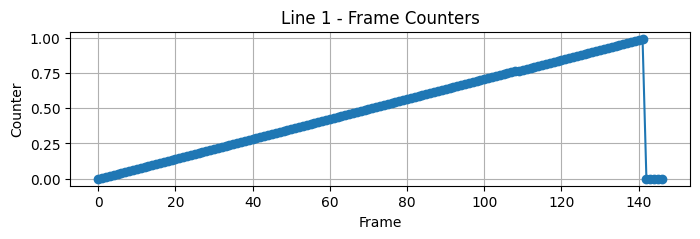


Line 2 - 147 frames
Frame	Counter	Sample Features
1	0.0	[-0.032609 -0.188946 -0.054769 -0.004272 -0.001088] ...
2	0.009	[-0.035367 -0.187685 -0.055947 -0.004053 -0.00112 ] ...
3	0.018	[-0.03827  -0.195151 -0.034729 -0.004775 -0.00099 ] ...
4	0.027	[-0.020617 -0.188635 -0.036708 -0.00484  -0.00033 ] ...
5	0.036	[ 1.66300e-03 -1.94607e-01 -1.97960e-02 -3.55500e-03  5.60000e-05] ...
6	0.045	[-4.52740e-02 -1.96264e-01 -2.75250e-02 -3.70800e-03 -1.42000e-04] ...
7	0.0541	[-0.035867 -0.202266  0.003346 -0.00456  -0.000334] ...
8	0.0631	[-0.031988 -0.204386 -0.024812 -0.004357 -0.001039] ...
9	0.0721	[-0.044259 -0.201177 -0.056624 -0.004246 -0.001572] ...
10	0.0811	[-0.038514 -0.201272 -0.057069 -0.00469  -0.001092] ...
11	0.0901	[-3.71110e-02 -2.00686e-01 -5.54070e-02 -4.84900e-03 -1.26000e-04] ...
12	0.0991	[-4.04650e-02 -2.02243e-01 -6.05030e-02 -5.72700e-03 -1.69000e-04] ...
13	0.1081	[-0.025464 -0.197467 -0.061675 -0.004616 -0.000537] ...
14	0.1171	[-0.020797 -0.183116 -0.106056 -0.0046

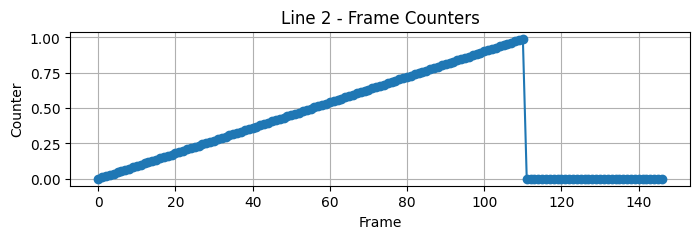


Line 3 - 147 frames
Frame	Counter	Sample Features
1	0.0	[ 0.007941 -0.247535  0.001251 -0.004447 -0.000832] ...
2	0.0238	[ 0.008222 -0.247318  0.001453 -0.004468 -0.000802] ...
3	0.0476	[ 0.002614 -0.247587  0.00319  -0.00435  -0.000849] ...
4	0.0714	[-0.008322 -0.249077 -0.003375 -0.004568 -0.001048] ...
5	0.0952	[-0.036879 -0.243428 -0.019184 -0.004079 -0.000463] ...
6	0.119	[-1.41940e-02 -2.42873e-01 -1.18220e-02 -3.79500e-03  2.18000e-04] ...
7	0.1429	[-2.11740e-02 -2.47461e-01 -2.13180e-02 -3.41200e-03 -7.60000e-05] ...
8	0.1667	[-0.0237   -0.258071  0.002807 -0.003551 -0.000266] ...
9	0.1905	[-0.034829 -0.257775 -0.009732 -0.003921 -0.000382] ...
10	0.2143	[-0.044841 -0.254883 -0.017537 -0.004212 -0.000498] ...
11	0.2381	[-0.050554 -0.252442 -0.008706 -0.003822 -0.000598] ...
12	0.2619	[-0.050665 -0.24888  -0.001187 -0.003738 -0.000601] ...
13	0.2857	[-0.052344 -0.243671 -0.002786 -0.003911 -0.000626] ...
14	0.3095	[-0.060356 -0.241728 -0.00066  -0.004008 -0.000776] ...
15	0.333

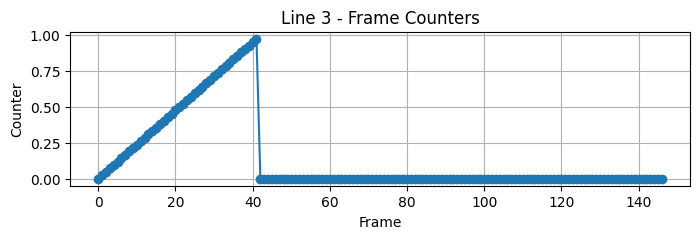


Line 4 - 147 frames
Frame	Counter	Sample Features
1	0.0	[-0.034068 -0.189199 -0.053895 -0.004341 -0.001086] ...
2	0.0068	[-0.03481  -0.188383 -0.054765 -0.004093 -0.001061] ...
3	0.0135	[-0.035768 -0.198415 -0.027675 -0.004828 -0.001033] ...
4	0.0203	[-0.016157 -0.191428 -0.030598 -0.004852 -0.000211] ...
5	0.027	[ 4.26700e-03 -1.97931e-01 -1.26810e-02 -3.45800e-03  1.60000e-05] ...
6	0.0338	[-4.37160e-02 -1.96696e-01 -2.75920e-02 -3.61100e-03 -1.15000e-04] ...
7	0.0405	[-0.034422 -0.203199  0.006056 -0.004583 -0.000345] ...
8	0.0473	[-0.033217 -0.204347 -0.026817 -0.004356 -0.001072] ...
9	0.0541	[-0.043026 -0.201708 -0.055191 -0.004226 -0.001548] ...
10	0.0608	[-0.035722 -0.202301 -0.053042 -0.004695 -0.000967] ...
11	0.0676	[-3.6356e-02 -2.0101e-01 -5.7671e-02 -4.8810e-03 -7.6000e-05] ...
12	0.0743	[-3.85790e-02 -2.02754e-01 -5.73880e-02 -5.64600e-03 -1.08000e-04] ...
13	0.0811	[-0.026569 -0.197637 -0.064267 -0.004712 -0.000522] ...
14	0.0878	[-0.021436 -0.182657 -0.107303 -0.00471

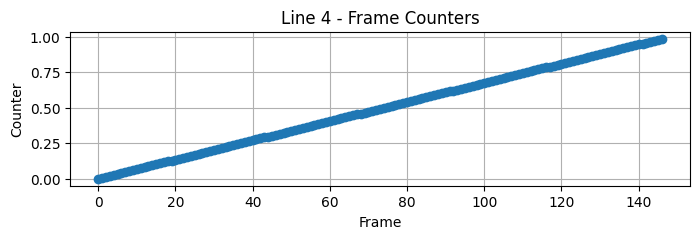


Line 5 - 147 frames
Frame	Counter	Sample Features
1	0.0	[-7.17100e-03 -1.92777e-01 -3.18290e-02 -4.57000e-03 -4.30000e-05] ...
2	0.0108	[-1.2738e-02 -1.8978e-01 -4.0581e-02 -4.4070e-03 -1.8700e-04] ...
3	0.0215	[-1.31360e-02 -1.94755e-01 -2.73880e-02 -4.61500e-03 -2.20000e-05] ...
4	0.0323	[-0.023191 -0.182515 -0.059037 -0.003804  0.000207] ...
5	0.043	[-0.017065 -0.187593 -0.045429 -0.003288  0.000282] ...
6	0.0538	[-0.022219 -0.201185 -0.013263 -0.003876  0.000456] ...
7	0.0645	[-0.025628 -0.204162 -0.00892  -0.003592  0.001106] ...
8	0.0753	[-0.023944 -0.206528  0.002079 -0.002843  0.000965] ...
9	0.086	[-0.027912 -0.207011  0.001026 -0.002079  0.000382] ...
10	0.0968	[-0.02777  -0.206867  0.005003 -0.002945  0.000639] ...
11	0.1075	[-0.027005 -0.206368  0.00262  -0.002993  0.000971] ...
12	0.1183	[-0.026654 -0.207304  0.003291 -0.002962  0.000926] ...
13	0.129	[-0.027985 -0.206916  0.002785 -0.00265   0.000541] ...
14	0.1398	[-0.032665 -0.20484  -0.001604 -0.00254   0.000474] ...


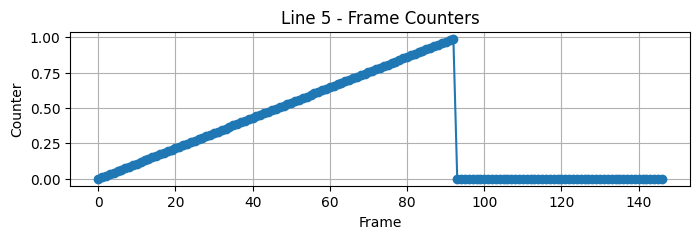

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Path to your file
file_path = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/dev.pred.skels"

# Read and parse the file
with open(file_path, 'r') as f:
    lines = f.readlines()

# Assume 151 values per frame
frame_dim = 151
feature_dim = 150

# Parse and visualize each line
for i, line in enumerate(lines):
    values = np.fromstring(line.strip(), sep=' ')
    num_frames = len(values) // frame_dim
    data = values.reshape(num_frames, frame_dim)

    features = data[:, :feature_dim]
    counters = data[:, -1]


    print(f"\nLine {i+1} - {num_frames} frames")
    print("Frame\tCounter\tSample Features")
    j=0;
    for f in range(num_frames):
        print(f"{f+1}\t{counters[f]}\t{features[f, :5]} ...")

    # Optional: Plot counter values across frames
    plt.figure(figsize=(8, 2))
    plt.plot(counters, marker='o')
    plt.title(f"Line {i+1} - Frame Counters")
    plt.xlabel("Frame")
    plt.ylabel("Counter")
    plt.grid(True)
    plt.show()

In [ ]:
import numpy as np

# Path to the input .skels file
file_path = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/dev.pred.skels"

# Read all lines
with open(file_path, 'r') as f:
    lines = f.readlines()

fixed_lines = []

for i, line in enumerate(lines):
    values = np.fromstring(line.strip(), sep=' ')
    num_frames = len(values) // 151

    # Sanity check
    if len(values) % 151 != 0:
        raise ValueError(f"Line {i+1}: Unexpected length {len(values)} for 151-D features.")

    # Reshape into [frames × 151]
    data = values.reshape(num_frames, 151)

    # Extract features (first 150 columns)
    features = data[:, :150]

    # FIX: Replace last column with evenly spaced values from 0.0 to 1.0
    correct_counters = np.linspace(0.0, 1.0, num_frames).reshape(num_frames, 1)

    # Concatenate fixed features and counter column
    fixed_data = np.concatenate([features, correct_counters], axis=1)

    # Flatten and stringify
    flat_line = ' '.join(map(str, fixed_data.flatten()))
    fixed_lines.append(flat_line)

# Save to new file
fixed_path = file_path.replace(".skels", ".fixed.skels")
with open(fixed_path, 'w') as f:
    for line in fixed_lines:
        f.write(line + '\n')

print(f"✅ Fixed skeletons saved to:\n{fixed_path}")


✅ Fixed skeletons saved to:
/content/drive/MyDrive/Sign-IDD SLT/data/Inference/dev.pred.fixed.skels



Line 1 - 147 frames
Frame	Counter	Sample Features
1	0.0	[-0.031581 -0.199573 -0.029702 -0.004307 -0.00124 ] ...
2	0.00684931506849315	[-0.032786 -0.200893 -0.026416 -0.00424  -0.001233] ...
3	0.0136986301369863	[-0.034456 -0.202972 -0.017222 -0.004627 -0.001256] ...
4	0.02054794520547945	[-0.034795 -0.201999 -0.011731 -0.005019 -0.000769] ...
5	0.0273972602739726	[-2.53270e-02 -2.02674e-01 -1.40000e-03 -4.80400e-03 -6.60000e-05] ...
6	0.03424657534246575	[-0.050608 -0.203272 -0.009485 -0.004561 -0.000373] ...
7	0.0410958904109589	[-0.047572 -0.206092 -0.006808 -0.005187 -0.000955] ...
8	0.04794520547945205	[-0.05118  -0.205186 -0.041507 -0.004965 -0.001523] ...
9	0.0547945205479452	[-0.057365 -0.20251  -0.0678   -0.004891 -0.001797] ...
10	0.06164383561643835	[-0.05453  -0.199635 -0.078505 -0.005192 -0.001448] ...
11	0.0684931506849315	[-0.05455  -0.194831 -0.081472 -0.004991 -0.000677] ...
12	0.07534246575342465	[-0.049295 -0.189491 -0.091973 -0.005768 -0.000655] ...
13	0.08219178082

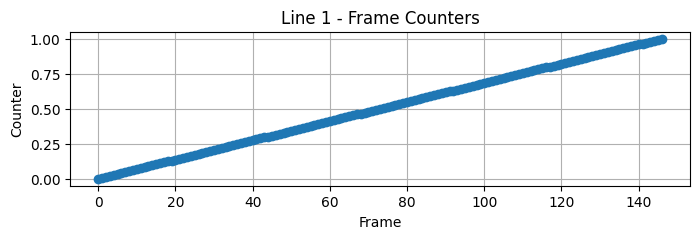


Line 2 - 147 frames
Frame	Counter	Sample Features
1	0.0	[-0.032609 -0.188946 -0.054769 -0.004272 -0.001088] ...
2	0.00684931506849315	[-0.035367 -0.187685 -0.055947 -0.004053 -0.00112 ] ...
3	0.0136986301369863	[-0.03827  -0.195151 -0.034729 -0.004775 -0.00099 ] ...
4	0.02054794520547945	[-0.020617 -0.188635 -0.036708 -0.00484  -0.00033 ] ...
5	0.0273972602739726	[ 1.66300e-03 -1.94607e-01 -1.97960e-02 -3.55500e-03  5.60000e-05] ...
6	0.03424657534246575	[-4.52740e-02 -1.96264e-01 -2.75250e-02 -3.70800e-03 -1.42000e-04] ...
7	0.0410958904109589	[-0.035867 -0.202266  0.003346 -0.00456  -0.000334] ...
8	0.04794520547945205	[-0.031988 -0.204386 -0.024812 -0.004357 -0.001039] ...
9	0.0547945205479452	[-0.044259 -0.201177 -0.056624 -0.004246 -0.001572] ...
10	0.06164383561643835	[-0.038514 -0.201272 -0.057069 -0.00469  -0.001092] ...
11	0.0684931506849315	[-3.71110e-02 -2.00686e-01 -5.54070e-02 -4.84900e-03 -1.26000e-04] ...
12	0.07534246575342465	[-4.04650e-02 -2.02243e-01 -6.05030e-02 -5

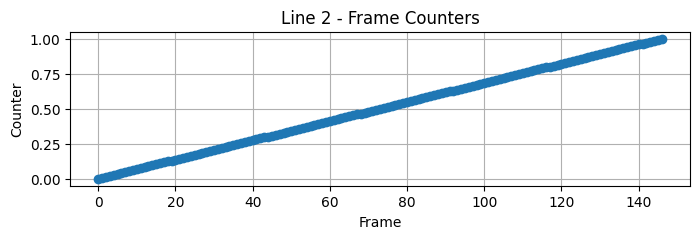


Line 3 - 147 frames
Frame	Counter	Sample Features
1	0.0	[ 0.007941 -0.247535  0.001251 -0.004447 -0.000832] ...
2	0.00684931506849315	[ 0.008222 -0.247318  0.001453 -0.004468 -0.000802] ...
3	0.0136986301369863	[ 0.002614 -0.247587  0.00319  -0.00435  -0.000849] ...
4	0.02054794520547945	[-0.008322 -0.249077 -0.003375 -0.004568 -0.001048] ...
5	0.0273972602739726	[-0.036879 -0.243428 -0.019184 -0.004079 -0.000463] ...
6	0.03424657534246575	[-1.41940e-02 -2.42873e-01 -1.18220e-02 -3.79500e-03  2.18000e-04] ...
7	0.0410958904109589	[-2.11740e-02 -2.47461e-01 -2.13180e-02 -3.41200e-03 -7.60000e-05] ...
8	0.04794520547945205	[-0.0237   -0.258071  0.002807 -0.003551 -0.000266] ...
9	0.0547945205479452	[-0.034829 -0.257775 -0.009732 -0.003921 -0.000382] ...
10	0.06164383561643835	[-0.044841 -0.254883 -0.017537 -0.004212 -0.000498] ...
11	0.0684931506849315	[-0.050554 -0.252442 -0.008706 -0.003822 -0.000598] ...
12	0.07534246575342465	[-0.050665 -0.24888  -0.001187 -0.003738 -0.000601] ...
1

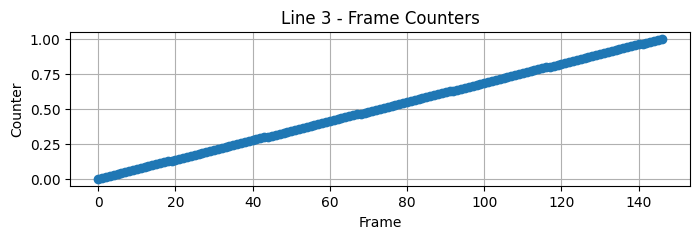


Line 4 - 147 frames
Frame	Counter	Sample Features
1	0.0	[-0.034068 -0.189199 -0.053895 -0.004341 -0.001086] ...
2	0.00684931506849315	[-0.03481  -0.188383 -0.054765 -0.004093 -0.001061] ...
3	0.0136986301369863	[-0.035768 -0.198415 -0.027675 -0.004828 -0.001033] ...
4	0.02054794520547945	[-0.016157 -0.191428 -0.030598 -0.004852 -0.000211] ...
5	0.0273972602739726	[ 4.26700e-03 -1.97931e-01 -1.26810e-02 -3.45800e-03  1.60000e-05] ...
6	0.03424657534246575	[-4.37160e-02 -1.96696e-01 -2.75920e-02 -3.61100e-03 -1.15000e-04] ...
7	0.0410958904109589	[-0.034422 -0.203199  0.006056 -0.004583 -0.000345] ...
8	0.04794520547945205	[-0.033217 -0.204347 -0.026817 -0.004356 -0.001072] ...
9	0.0547945205479452	[-0.043026 -0.201708 -0.055191 -0.004226 -0.001548] ...
10	0.06164383561643835	[-0.035722 -0.202301 -0.053042 -0.004695 -0.000967] ...
11	0.0684931506849315	[-3.6356e-02 -2.0101e-01 -5.7671e-02 -4.8810e-03 -7.6000e-05] ...
12	0.07534246575342465	[-3.85790e-02 -2.02754e-01 -5.73880e-02 -5.6460

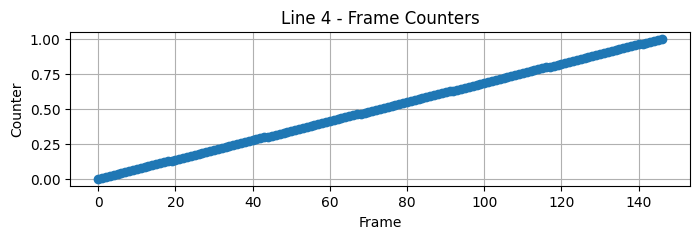


Line 5 - 147 frames
Frame	Counter	Sample Features
1	0.0	[-7.17100e-03 -1.92777e-01 -3.18290e-02 -4.57000e-03 -4.30000e-05] ...
2	0.00684931506849315	[-1.2738e-02 -1.8978e-01 -4.0581e-02 -4.4070e-03 -1.8700e-04] ...
3	0.0136986301369863	[-1.31360e-02 -1.94755e-01 -2.73880e-02 -4.61500e-03 -2.20000e-05] ...
4	0.02054794520547945	[-0.023191 -0.182515 -0.059037 -0.003804  0.000207] ...
5	0.0273972602739726	[-0.017065 -0.187593 -0.045429 -0.003288  0.000282] ...
6	0.03424657534246575	[-0.022219 -0.201185 -0.013263 -0.003876  0.000456] ...
7	0.0410958904109589	[-0.025628 -0.204162 -0.00892  -0.003592  0.001106] ...
8	0.04794520547945205	[-0.023944 -0.206528  0.002079 -0.002843  0.000965] ...
9	0.0547945205479452	[-0.027912 -0.207011  0.001026 -0.002079  0.000382] ...
10	0.06164383561643835	[-0.02777  -0.206867  0.005003 -0.002945  0.000639] ...
11	0.0684931506849315	[-0.027005 -0.206368  0.00262  -0.002993  0.000971] ...
12	0.07534246575342465	[-0.026654 -0.207304  0.003291 -0.002962  0.000

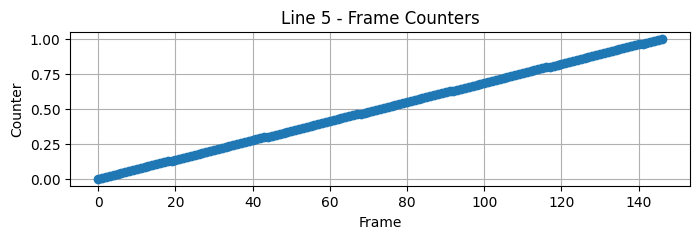

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Path to your file
file_path = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/dev.pred.fixed.skels"

# Read and parse the file
with open(file_path, 'r') as f:
    lines = f.readlines()

# Assume 151 values per frame
frame_dim = 151
feature_dim = 150

# Parse and visualize each line
for i, line in enumerate(lines):
    values = np.fromstring(line.strip(), sep=' ')
    num_frames = len(values) // frame_dim
    data = values.reshape(num_frames, frame_dim)

    features = data[:, :feature_dim]
    counters = data[:, -1]


    print(f"\nLine {i+1} - {num_frames} frames")
    print("Frame\tCounter\tSample Features")
    j=0;
    for f in range(num_frames):
        print(f"{f+1}\t{counters[f]}\t{features[f, :5]} ...")

    # Optional: Plot counter values across frames
    plt.figure(figsize=(8, 2))
    plt.plot(counters, marker='o')
    plt.title(f"Line {i+1} - Frame Counters")
    plt.xlabel("Frame")
    plt.ylabel("Counter")
    plt.grid(True)
    plt.show()


In [ ]:
import numpy as np

# Path to the input .skels file
file_path = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/test.pred.skels"

# Read all lines
with open(file_path, 'r') as f:
    lines = f.readlines()

fixed_lines = []

for i, line in enumerate(lines):
    values = np.fromstring(line.strip(), sep=' ')
    num_frames = len(values) // 151

    # Sanity check
    if len(values) % 151 != 0:
        raise ValueError(f"Line {i+1}: Unexpected length {len(values)} for 151-D features.")

    # Reshape into [frames × 151]
    data = values.reshape(num_frames, 151)

    # Extract features (first 150 columns)
    features = data[:, :150]

    # FIX: Replace last column with evenly spaced values from 0.0 to 1.0
    correct_counters = np.linspace(0.0, 1.0, num_frames).reshape(num_frames, 1)

    # Concatenate fixed features and counter column
    fixed_data = np.concatenate([features, correct_counters], axis=1)

    # Flatten and stringify
    flat_line = ' '.join(map(str, fixed_data.flatten()))
    fixed_lines.append(flat_line)

# Save to new file
fixed_path = file_path.replace(".skels", ".fixed.skels")
with open(fixed_path, 'w') as f:
    for line in fixed_lines:
        f.write(line + '\n')

print(f"✅ Fixed skeletons saved to:\n{fixed_path}")


✅ Fixed skeletons saved to:
/content/drive/MyDrive/Sign-IDD SLT/data/Inference/test.pred.fixed.skels


### Fixed pred skels

In [ ]:
import gzip
import joblib
import pandas as pd

# Config
feature_dim = 150
input_csv = "/content/drive/MyDrive/Sign-IDD SLT/data/PHOENIX2014T/Dev/dev.csv"
input_skels = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/dev.pred.fixed.skels"
output_dir = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference"
output_file = os.path.join(output_dir, "phoenix14t.infer.fixed.skels.dev")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load metadata CSV
df = pd.read_csv(input_csv, sep="|")
assert len(df) == 5, "Expected 5 samples in dev.csv"

# Read skeleton lines
with open(input_skels, "r") as f:
    skel_lines = [line.strip() for line in f.readlines()]

assert len(skel_lines) == len(df), "Mismatch between CSV and skels line count"

samples = []

for idx, (line, meta) in enumerate(zip(skel_lines, df.itertuples())):
    raw = list(map(float, line.split()))
    assert len(raw) % (feature_dim + 1) == 0, f"Line {idx} isn't multiple of {feature_dim+1}"

    num_frames = len(raw) // (feature_dim + 1)
    frames = []
    for i in range(num_frames):
        frame_vec = raw[i * (feature_dim + 1) : i * (feature_dim + 1) + feature_dim]
        frames.append(torch.tensor(frame_vec, dtype=torch.float32))

    sign_tensor = torch.stack(frames, dim=0)  # [T, 150]

    sample = {
        "name": meta.name,
        "signer": meta.speaker,
        "sign": sign_tensor + 1e-8,  # small value added for numerical stability
        "gloss": meta.orth.strip(),
        "text": meta.translation.strip(),
    }
    samples.append(sample)

# Save as joblib file in gzip
with gzip.open(output_file, "wb") as f:
    joblib.dump(samples, f)

print(f"Saved {len(samples)} samples to {output_file}")


Saved 5 samples to /content/drive/MyDrive/Sign-IDD SLT/data/Inference/phoenix14t.infer.fixed.skels.dev


In [ ]:
import gzip
import joblib
import pandas as pd

# Config
feature_dim = 150
input_csv = "/content/drive/MyDrive/Sign-IDD SLT/data/PHOENIX2014T/Test/test.csv"
input_skels = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/test.pred.fixed.skels"
output_dir = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference"
output_file = os.path.join(output_dir, "phoenix14t.infer.fixed.skels.test")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load metadata CSV
df = pd.read_csv(input_csv, sep="|")
assert len(df) == 5, "Expected 5 samples in dev.csv"

# Read skeleton lines
with open(input_skels, "r") as f:
    skel_lines = [line.strip() for line in f.readlines()]

assert len(skel_lines) == len(df), "Mismatch between CSV and skels line count"

samples = []

for idx, (line, meta) in enumerate(zip(skel_lines, df.itertuples())):
    raw = list(map(float, line.split()))
    assert len(raw) % (feature_dim + 1) == 0, f"Line {idx} isn't multiple of {feature_dim+1}"

    num_frames = len(raw) // (feature_dim + 1)
    frames = []
    for i in range(num_frames):
        frame_vec = raw[i * (feature_dim + 1) : i * (feature_dim + 1) + feature_dim]
        frames.append(torch.tensor(frame_vec, dtype=torch.float32))

    sign_tensor = torch.stack(frames, dim=0)  # [T, 150]

    sample = {
        "name": meta.name,
        "signer": meta.speaker,
        "sign": sign_tensor + 1e-8,  # small value added for numerical stability
        "gloss": meta.orth.strip(),
        "text": meta.translation.strip(),
    }
    samples.append(sample)

# Save as joblib file in gzip
with gzip.open(output_file, "wb") as f:
    joblib.dump(samples, f)

print(f"Saved {len(samples)} samples to {output_file}")


Saved 5 samples to /content/drive/MyDrive/Sign-IDD SLT/data/Inference/phoenix14t.infer.fixed.skels.test


### Inference(try again)

In [ ]:
test(cfg_file='/content/drive/MyDrive/Sign-IDD SLT/configs/fixed_inference.yaml',
     ckpt='/content/drive/MyDrive/Sign-IDD SLT/signjoey/sign_skels_model/best.ckpt',
     output_path='/content/drive/MyDrive/Sign-IDD SLT/signjoey/sign_skels_model/Inference_output')

INFO:prediction:----------------------------------------------------------------------------------------
INFO:prediction:[DEV] partition [RECOGNITION] experiment [BW]: 10


RuntimeError: The size of tensor a (147) must match the size of tensor b (148) at non-singleton dimension 3

### Fix again by padding frames

In [ ]:
import numpy as np

# Original (ground truth) dev skels path
original_path = "/content/drive/MyDrive/Sign-IDD SLT/data/PHOENIX2014T/Dev/dev.skels"
# Predicted skels path
pred_path = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/dev.pred.skels"
# Output fixed prediction file
fixed_path = pred_path.replace(".skels", ".frame_aligned.skels")

feature_dim = 150
total_dim = 151

# Read original and predicted
with open(original_path, 'r') as f:
    original_lines = f.readlines()

with open(pred_path, 'r') as f:
    pred_lines = f.readlines()

assert len(original_lines) == len(pred_lines), "Mismatch in number of samples."

fixed_lines = []

for i, (orig_line, pred_line) in enumerate(zip(original_lines, pred_lines)):
    orig_vals = np.fromstring(orig_line.strip(), sep=' ')
    pred_vals = np.fromstring(pred_line.strip(), sep=' ')

    orig_frames = len(orig_vals) // total_dim
    pred_frames = len(pred_vals) // total_dim

    # Reshape prediction and fix counters
    pred_data = pred_vals.reshape(pred_frames, -1)
    pred_data[:, -1] = np.linspace(0.0, 1.0, pred_frames)  # fix counters

    if pred_frames < orig_frames:
        # Pad with zeros to match
        pad_len = orig_frames - pred_frames
        padding = np.zeros((pad_len, total_dim))
        pred_data = np.vstack([pred_data, padding])
    elif pred_frames > orig_frames:
        # Truncate
        print(f"⚠️ Warning: Sample {i+1} has {pred_frames} > {orig_frames} frames, truncating.")
        pred_data = pred_data[:orig_frames]

    flat_line = ' '.join(map(str, pred_data.flatten()))
    fixed_lines.append(flat_line)

# Save
with open(fixed_path, 'w') as f:
    for line in fixed_lines:
        f.write(line + '\n')

print(f"✅ Frame-aligned predictions saved to: {fixed_path}")


⚠️ Warning: Sample 1 has 147 > 42 frames, truncating.
⚠️ Warning: Sample 2 has 147 > 111 frames, truncating.
⚠️ Warning: Sample 4 has 147 > 142 frames, truncating.
⚠️ Warning: Sample 5 has 147 > 93 frames, truncating.
✅ Frame-aligned predictions saved to: /content/drive/MyDrive/Sign-IDD SLT/data/Inference/dev.pred.frame_aligned.skels


In [ ]:
import numpy as np

# Original (ground truth) dev skels path
original_path = "/content/drive/MyDrive/Sign-IDD SLT/data/PHOENIX2014T/Test/test.skels"
# Predicted skels path
pred_path = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/test.pred.skels"
# Output fixed prediction file
fixed_path = pred_path.replace(".skels", ".frame_aligned.skels")

feature_dim = 150
total_dim = 151

# Read original and predicted
with open(original_path, 'r') as f:
    original_lines = f.readlines()

with open(pred_path, 'r') as f:
    pred_lines = f.readlines()

assert len(original_lines) == len(pred_lines), "Mismatch in number of samples."

fixed_lines = []

for i, (orig_line, pred_line) in enumerate(zip(original_lines, pred_lines)):
    orig_vals = np.fromstring(orig_line.strip(), sep=' ')
    pred_vals = np.fromstring(pred_line.strip(), sep=' ')

    orig_frames = len(orig_vals) // total_dim
    pred_frames = len(pred_vals) // total_dim

    # Reshape prediction and fix counters
    pred_data = pred_vals.reshape(pred_frames, -1)
    pred_data[:, -1] = np.linspace(0.0, 1.0, pred_frames)  # fix counters

    if pred_frames < orig_frames:
        # Pad with zeros to match
        pad_len = orig_frames - pred_frames
        padding = np.zeros((pad_len, total_dim))
        pred_data = np.vstack([pred_data, padding])
    elif pred_frames > orig_frames:
        # Truncate
        print(f"⚠️ Warning: Sample {i+1} has {pred_frames} > {orig_frames} frames, truncating.")
        pred_data = pred_data[:orig_frames]

    flat_line = ' '.join(map(str, pred_data.flatten()))
    fixed_lines.append(flat_line)

# Save
with open(fixed_path, 'w') as f:
    for line in fixed_lines:
        f.write(line + '\n')

print(f"✅ Frame-aligned predictions saved to: {fixed_path}")


⚠️ Warning: Sample 1 has 197 > 181 frames, truncating.
⚠️ Warning: Sample 2 has 197 > 150 frames, truncating.
⚠️ Warning: Sample 4 has 197 > 130 frames, truncating.
⚠️ Warning: Sample 5 has 197 > 111 frames, truncating.
✅ Frame-aligned predictions saved to: /content/drive/MyDrive/Sign-IDD SLT/data/Inference/test.pred.frame_aligned.skels


## frame aligned dataset creation

In [ ]:
import gzip
import joblib
import pandas as pd

# Config
feature_dim = 150
input_csv = "/content/drive/MyDrive/Sign-IDD SLT/data/PHOENIX2014T/Dev/dev.csv"
input_skels = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/dev.pred.frame_aligned.skels"
output_dir = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference"
output_file = os.path.join(output_dir, "phoenix14t.infer.fixed2.skels.dev")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load metadata CSV
df = pd.read_csv(input_csv, sep="|")
assert len(df) == 5, "Expected 5 samples in dev.csv"

# Read skeleton lines
with open(input_skels, "r") as f:
    skel_lines = [line.strip() for line in f.readlines()]

assert len(skel_lines) == len(df), "Mismatch between CSV and skels line count"

samples = []

for idx, (line, meta) in enumerate(zip(skel_lines, df.itertuples())):
    raw = list(map(float, line.split()))
    assert len(raw) % (feature_dim + 1) == 0, f"Line {idx} isn't multiple of {feature_dim+1}"

    num_frames = len(raw) // (feature_dim + 1)
    frames = []
    for i in range(num_frames):
        frame_vec = raw[i * (feature_dim + 1) : i * (feature_dim + 1) + feature_dim]
        frames.append(torch.tensor(frame_vec, dtype=torch.float32))

    sign_tensor = torch.stack(frames, dim=0)  # [T, 150]

    sample = {
        "name": meta.name,
        "signer": meta.speaker,
        "sign": sign_tensor + 1e-8,  # small value added for numerical stability
        "gloss": meta.orth.strip(),
        "text": meta.translation.strip(),
    }
    samples.append(sample)

# Save as joblib file in gzip
with gzip.open(output_file, "wb") as f:
    joblib.dump(samples, f)

print(f"Saved {len(samples)} samples to {output_file}")


Saved 5 samples to /content/drive/MyDrive/Sign-IDD SLT/data/Inference/phoenix14t.infer.fixed2.skels.dev


In [ ]:
import gzip
import joblib
import pandas as pd

# Config
feature_dim = 150
input_csv = "/content/drive/MyDrive/Sign-IDD SLT/data/PHOENIX2014T/Test/test.csv"
input_skels = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference/test.pred.frame_aligned.skels"
output_dir = "/content/drive/MyDrive/Sign-IDD SLT/data/Inference"
output_file = os.path.join(output_dir, "phoenix14t.infer.fixed2.skels.test")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load metadata CSV
df = pd.read_csv(input_csv, sep="|")
assert len(df) == 5, "Expected 5 samples in dev.csv"

# Read skeleton lines
with open(input_skels, "r") as f:
    skel_lines = [line.strip() for line in f.readlines()]

assert len(skel_lines) == len(df), "Mismatch between CSV and skels line count"

samples = []

for idx, (line, meta) in enumerate(zip(skel_lines, df.itertuples())):
    raw = list(map(float, line.split()))
    assert len(raw) % (feature_dim + 1) == 0, f"Line {idx} isn't multiple of {feature_dim+1}"

    num_frames = len(raw) // (feature_dim + 1)
    frames = []
    for i in range(num_frames):
        frame_vec = raw[i * (feature_dim + 1) : i * (feature_dim + 1) + feature_dim]
        frames.append(torch.tensor(frame_vec, dtype=torch.float32))

    sign_tensor = torch.stack(frames, dim=0)  # [T, 150]

    sample = {
        "name": meta.name,
        "signer": meta.speaker,
        "sign": sign_tensor + 1e-8,  # small value added for numerical stability
        "gloss": meta.orth.strip(),
        "text": meta.translation.strip(),
    }
    samples.append(sample)

# Save as joblib file in gzip
with gzip.open(output_file, "wb") as f:
    joblib.dump(samples, f)

print(f"Saved {len(samples)} samples to {output_file}")


Saved 5 samples to /content/drive/MyDrive/Sign-IDD SLT/data/Inference/phoenix14t.infer.fixed2.skels.test


## Inference (AGAIN)

In [ ]:
test(cfg_file='/content/drive/MyDrive/Sign-IDD SLT/configs/frame_inference.yaml',
     ckpt='/content/drive/MyDrive/Sign-IDD SLT/signjoey/sign_skels_model/best.ckpt',
     output_path='/content/drive/MyDrive/Sign-IDD SLT/signjoey/sign_skels_model/Inference_output')

INFO:prediction:----------------------------------------------------------------------------------------
INFO:prediction:[DEV] partition [RECOGNITION] experiment [BW]: 10
INFO:prediction:finished in 5.7053s 
INFO:prediction:****************************************************************************************
INFO:prediction:[DEV] partition [RECOGNITION] results:
	New Best CTC Decode Beam Size: 10
	WER 88.57	(DEL: 20.00,	INS: 2.86,	SUB: 65.71)
INFO:prediction:****************************************************************************************
INFO:prediction:========================================================================================
INFO:prediction:[DEV] partition [Translation] results:
	New Best Translation Beam Size: 10 and Alpha: -1
	BLEU-4 2.89	(BLEU-1: 8.00,	BLEU-2: 4.70,	BLEU-3: 3.62,	BLEU-4: 2.89)
	CHRF 24.19	ROUGE 12.39	FID 0.73	MPJPE 0.50	MPVPE 0.00	MPJAE 33.69	
INFO:prediction:---------------------------------------------------------------------------------